# motif enrichment comparisons

## summary

- want to see what motifs are enriched by combining shap contribution and ISM approahces (union)
- want to compare what is enriched in one group relative to background 

## analysis overview

### subclones

- 

In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
from scipy import stats
import datetime
import time
import sys
sys.path.append('/home/nravindra/project/')
from reg_diffs.scripts import evalism_v22 as evalism 
from reg_diffs.scripts.analysis import motif_enrichment_cmp as mtfcmp
from reg_diffs.scripts import utils as regutils
import glob
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency

import re
import pybedtools
import scipy

from sklearn.linear_model import LinearRegression
from adjustText import adjust_text
from scipy.stats import spearmanr

import scanpy as sc

## GBM 39

### cmp btw subclones

* clone A
* clone B

In [2]:
cleaned_motif_file = '/illumina/scratch/deep_learning/nravindra/results/reg_diffs/ismshap_gbm_subclone_vierstrav1.pkl'
data = regutils.load_from_pickle(cleaned_motif_file)

Loading: /illumina/scratch/deep_learning/nravindra/results/reg_diffs/ismshap_gbm_subclone_vierstrav1.pkl
... done in 3.3-s
  keys: dict_keys(['GBM39_cloneA', 'GBM39_cloneB', 'GBM45_cloneA', 'GBM45_cloneB'])


In [3]:
# # specify groups

# groups = {'luminal': ['brca{}'.format(n) for n in ['10', '12', '15', '20', '22', ]],
#           'basal': ['brca{}'.format(n) for n in ['14', '16', '23', '24', '25', ]],
#           'her2': ['brca{}'.format(n) for n in ['11', '13', '17', '18', '19', '21', ]]}

# sample2grp = {}
# for k, v in groups.items():
#     for s in v:
#         sample2grp[s] = '{}.{}'.format(k, s.split('brca')[-1])
# sample2grp

# names

Need to modify motif names for simplicity

In [4]:
load = True

In [5]:
# get names
names = []
for k in data.keys():
    names += data[k]['group_name'].unique().tolist()
    names = list(np.unique(names))

In [6]:
len(names)

282

In [7]:
# make keys of middle part, sort, if first 3 letters are shared 
name_keys = {} 
for name in names:
    s = name.split('/')
    s.sort()
    if len(s) > 2:
        print('Problem? See:', s, 'as:', '/'.join(s[1:]))
        s = s[1:]
    if (len(s) > 1 and s[0][:3] == s[1][:3]) or (len(s) == 1): # first 3 letters, take only first element or manual rename
        if (re.search('....\d', s[0]) or s[0][:4] in ['CTCF', 'GATA', ]) and 'ZNF' not in s[0][:4]: 
            s = [s[0][:4]]
        else:
            s = [s[0][:3]]
    elif len(s) == 2 and re.search('^\d', s[0]):
        s = [s[1]]
    name_keys[name] = '/'.join(s)

# remap the solos to existing ones

Problem? See: ['1', 'ATF', 'CREB'] as: ATF/CREB
Problem? See: ['2', 'ATF', 'CREB'] as: ATF/CREB
Problem? See: ['3', 'ATF', 'CREB'] as: ATF/CREB
Problem? See: ['1', 'CACGTG', 'Ebox'] as: CACGTG/Ebox
Problem? See: ['2', 'CACGTG', 'Ebox'] as: CACGTG/Ebox
Problem? See: ['1', 'KLF', 'SP'] as: KLF/SP
Problem? See: ['2', 'KLF', 'SP'] as: KLF/SP
Problem? See: ['3', 'KLF', 'SP'] as: KLF/SP


In [8]:
len(list(np.unique(list(name_keys.values()))))

112

### transfer name keys

In [9]:
# add name keys
data['GBM39_cloneA']['modified_names'] = data['GBM39_cloneA']['group_name'].map(name_keys)
data['GBM39_cloneB']['modified_names'] = data['GBM39_cloneB']['group_name'].map(name_keys)
data['GBM45_cloneA']['modified_names'] = data['GBM45_cloneA']['group_name'].map(name_keys)
data['GBM45_cloneB']['modified_names'] = data['GBM45_cloneB']['group_name'].map(name_keys)

# split into two clones
gbm39 = {'cloneA': data['GBM39_cloneA'],
         'cloneB': data['GBM39_cloneB']}
gbm45 = {'cloneA': data['GBM45_cloneA'],
         'cloneB': data['GBM45_cloneB']}

In [10]:
gbm45['cloneA']

group_name seqnames     start       end        es   enrichment  \
5               AHR     chr2  47174392  47174398  0.207018      cleaned   
9               AHR     chr2  47344969  47344975  0.330203      cleaned   
11              AHR     chr2  47904564  47904570  0.025418  not cleaned   
15              AHR     chr2  48420907  48420913  0.773188      cleaned   
18              AHR     chr2  50536540  50536546  0.207886      cleaned   
...             ...      ...       ...       ...       ...          ...   
15787865     ZSCAN4    chr11  16353306  16353319  0.792213      cleaned   
15787871     ZSCAN4    chr11  16820465  16820478  1.406432      cleaned   
15787875     ZSCAN4    chr11  17529907  17529920  0.083294  not cleaned   
15787877     ZSCAN4    chr11  18396224  18396237  0.133308  not cleaned   
15787900     ZSCAN4    chr11  26766523  26766536  0.288917      cleaned   

          contribution  enrichment_shap  end_cnt_before  end_cnt_after  \
5             0.004352            False           15105           1638   
9             0.000152            False           15105           1638   
11            0.006836             True           15105           1638   
15            0.017345             True           15105           1638   
18            0.007129             True           15105           1638   
...                ...              ...             ...            ...   
15787865      0.000791            False           23399           2236   
15787871      0.012567             True           23399           2236   
15787875      0.008155             True           23399           2236   
15787877      0.007972             True           23399           2236   
15787900      0.006520            False           23399           2236   

         modified_names  
5                   AHR  
9                   AHR  
11                  AHR  
15                  AHR  
18                  AHR  
...                 ...  
15787865           ZSCA  
15787871           ZSCA  
15787875           ZSCA  
15787877           ZSCA  
15787900           ZSCA  

[2420008 rows x 11 columns]

# GBM 39

In [17]:
export = False
load = False

In [77]:
# run pipeline

name_key = 'modified_names'

## tst w/o modified names
enrich_out = evalism.chi2ovr(
    data=gbm39,
    groups=None,
    notB_key='end_cnt_before', 
    B_key='end_cnt_after',
    return_df=True,
    verbose=True,
    name_key=name_key,
    )
# print('pct significant: {:.2f}'.format(100*(enrich_out['p_bonferonni'] < 0.5).sum()/enrich_out.shape[0]))
# if export:
#     enrich_out.to_csv('/illumina/scratch/deep_learning/nravindra/tmp/reg_diffs/results/mtfcmp_cloneAvB_ism_shap_gbm39.csv')
        
# ## 3. visualize
# agg = mtfcmp.viz_compare_enrich(enrich_out, name_key=name_key, drop_duplicates_key=name_key, names2display=None)
# agg


data merged into one df in 2-s
through cloneA. time elapsed: 2-s
through cloneB. time elapsed: 2-s
n_tst: 224


In [78]:
export = True

0 row_10_ZNF
  wrote /illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/clstrmp_mtfcmp_gbm39AvB_zrow_top10_dropZNF_preZ.csv
1 row_10_None
  wrote /illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/clstrmp_mtfcmp_gbm39AvB_zrow_top10_dropNone_preZ.csv
2 row_20_ZNF
  wrote /illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/clstrmp_mtfcmp_gbm39AvB_zrow_top20_dropZNF_preZ.csv
3 row_20_None
  wrote /illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/clstrmp_mtfcmp_gbm39AvB_zrow_top20_dropNone_preZ.csv
4 row_None_ZNF
  wrote /illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/clstrmp_mtfcmp_gbm39AvB_zrow_topNone_dropZNF_preZ.csv
5 row_None_None
  wrote /illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/clstrmp_mtfcmp_gbm39AvB_zrow_topNone_dropNone_preZ.csv
6 col_10_ZNF
  wrote /illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/clstrmp_mtfcmp_gbm39AvB_zcol_top10_dropZNF_preZ.csv
7 col_10_None
  wrote /illu

/home/nravindra/miniconda3/envs/seq2atac/lib/python3.10/site-packages/seaborn/matrix.py:812: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(figsize=figsize)


  wrote /illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/clstrmp_mtfcmp_gbm39AvB_zNone_top20_dropZNF_preZ.csv
21 None_20_None
  wrote /illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/clstrmp_mtfcmp_gbm39AvB_zNone_top20_dropNone_preZ.csv
22 None_None_ZNF
  wrote /illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/clstrmp_mtfcmp_gbm39AvB_zNone_topNone_dropZNF_preZ.csv
23 None_None_None
  wrote /illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/clstrmp_mtfcmp_gbm39AvB_zNone_topNone_dropNone_preZ.csv


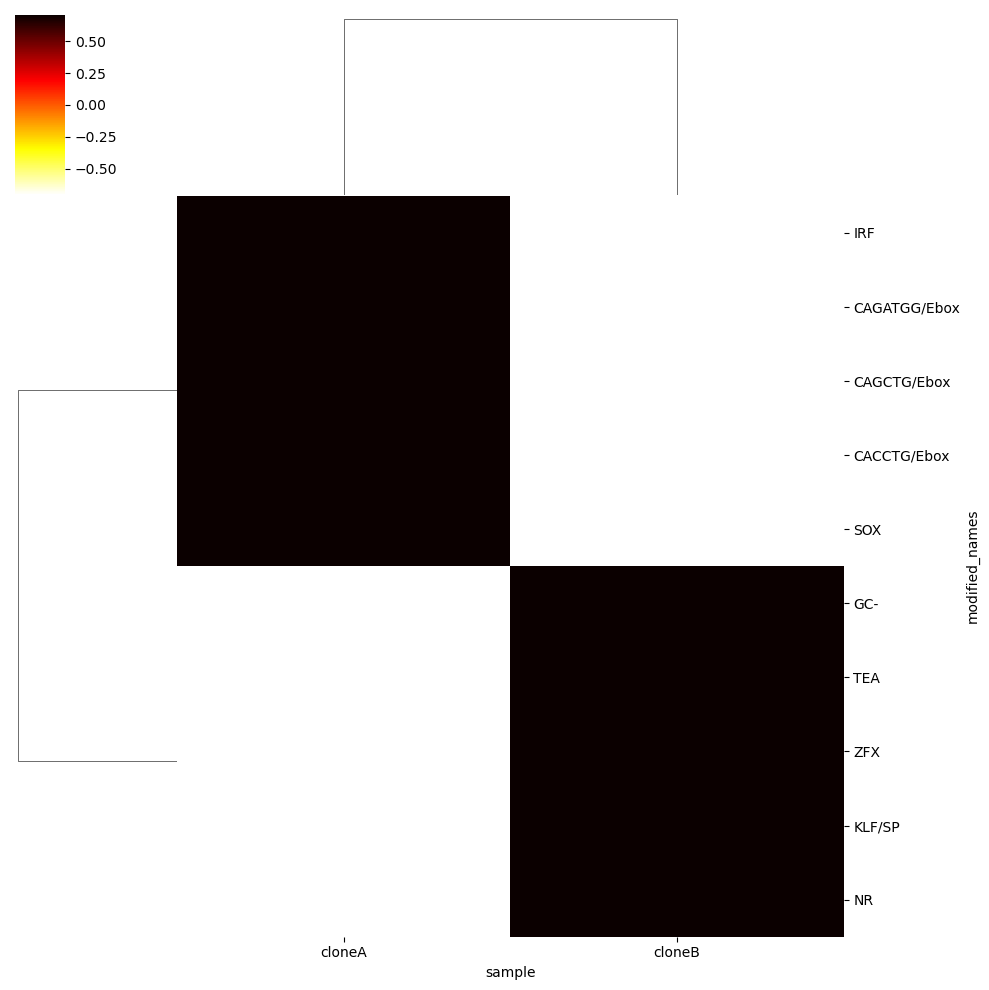

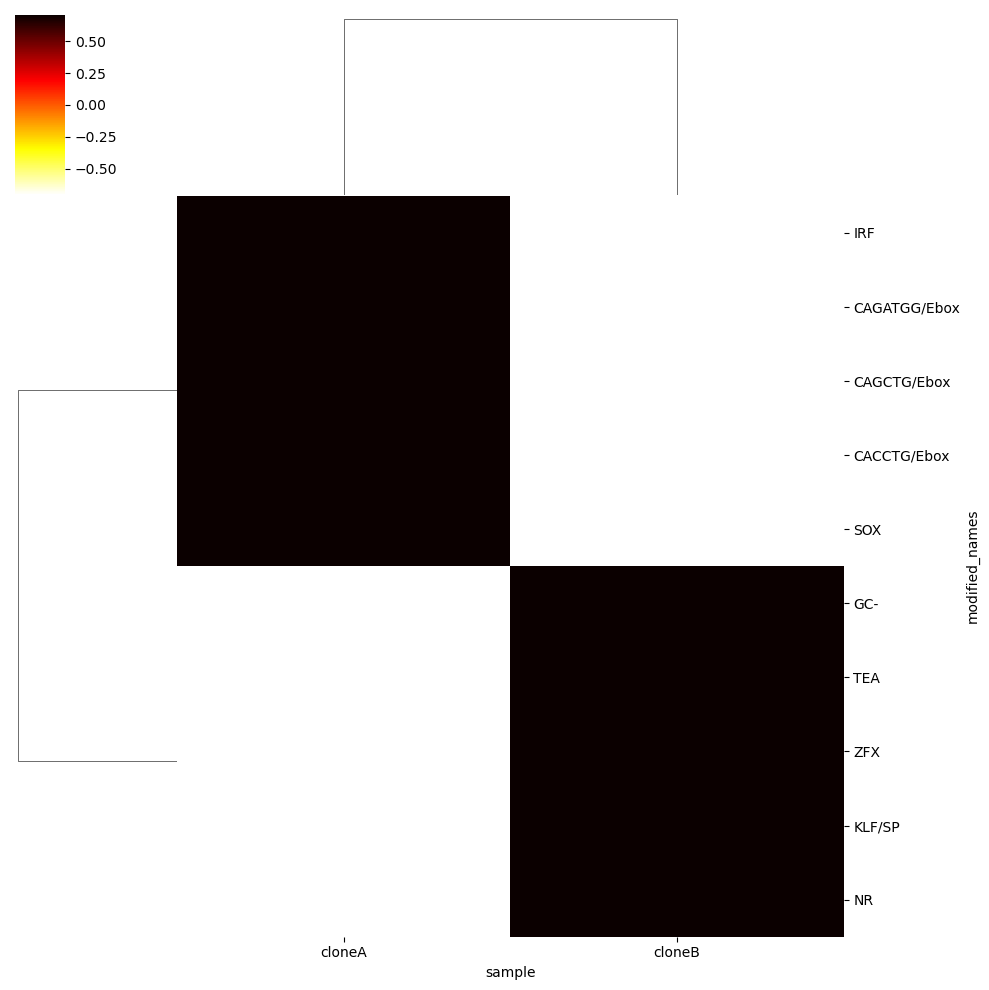

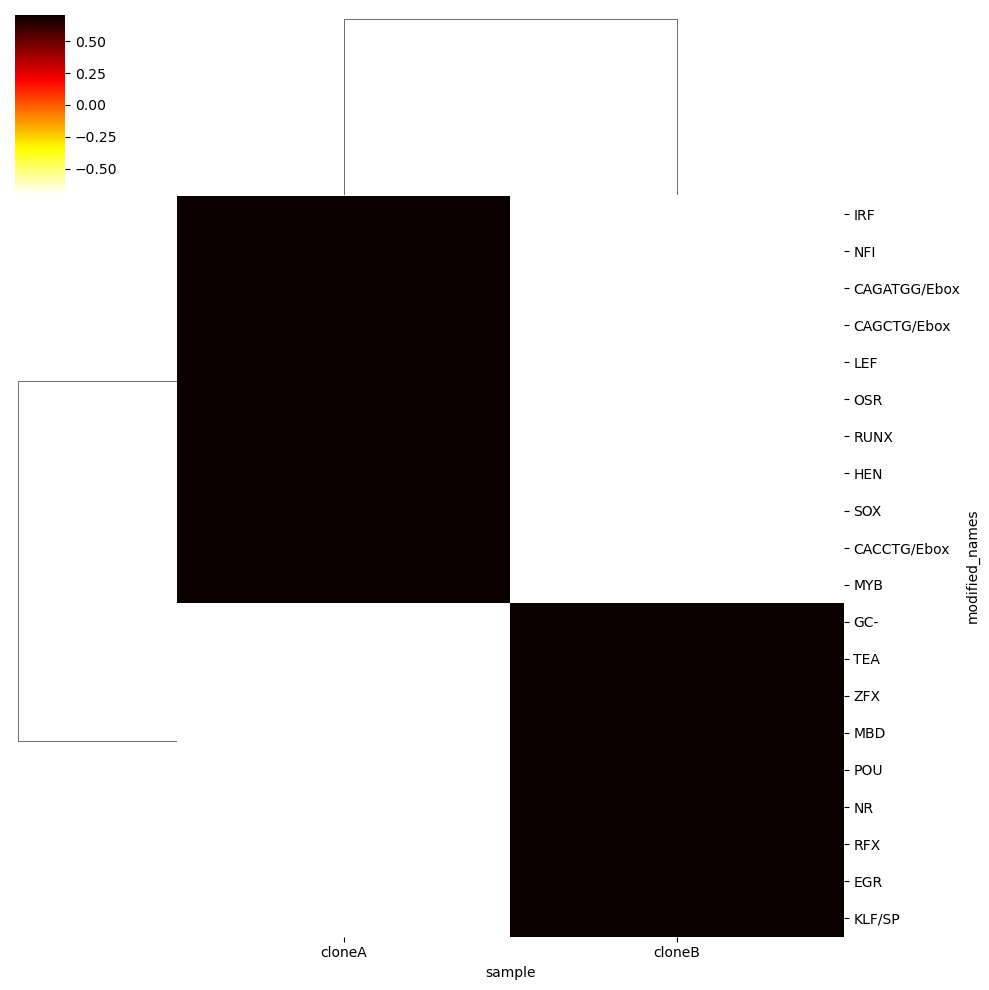

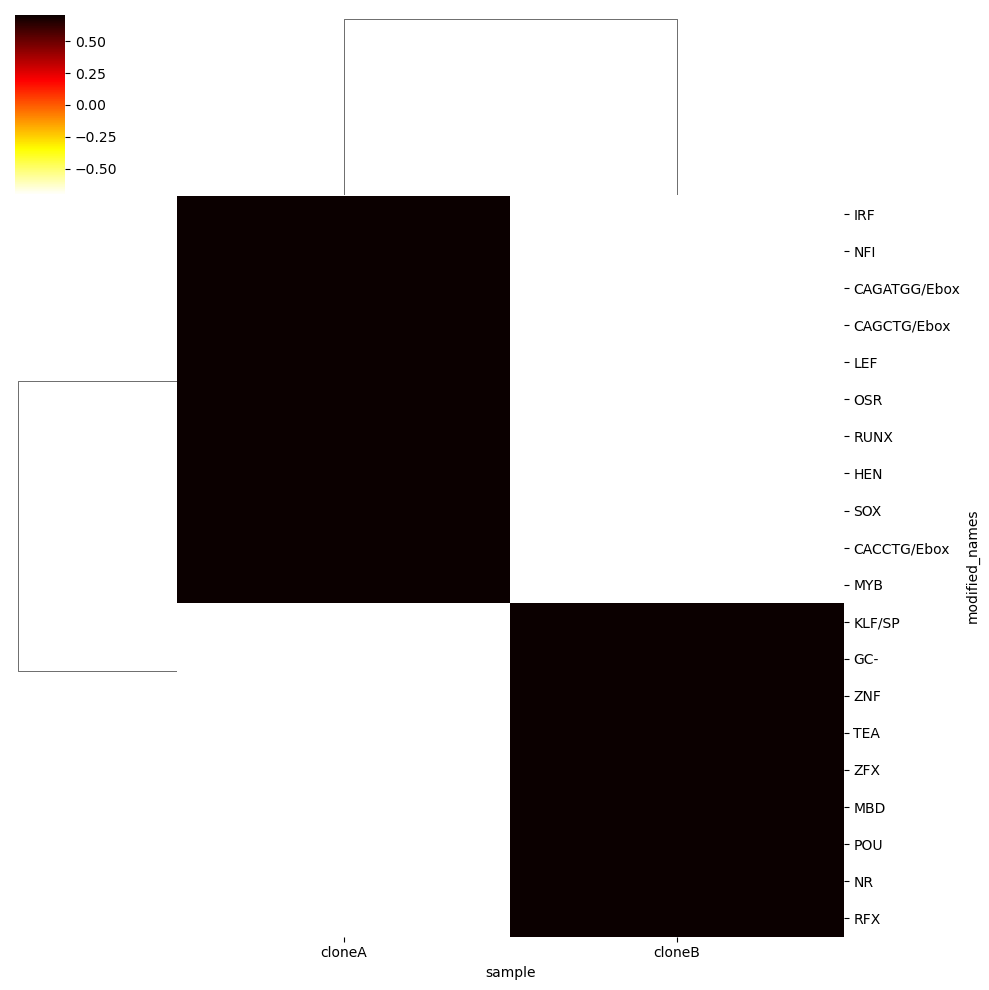

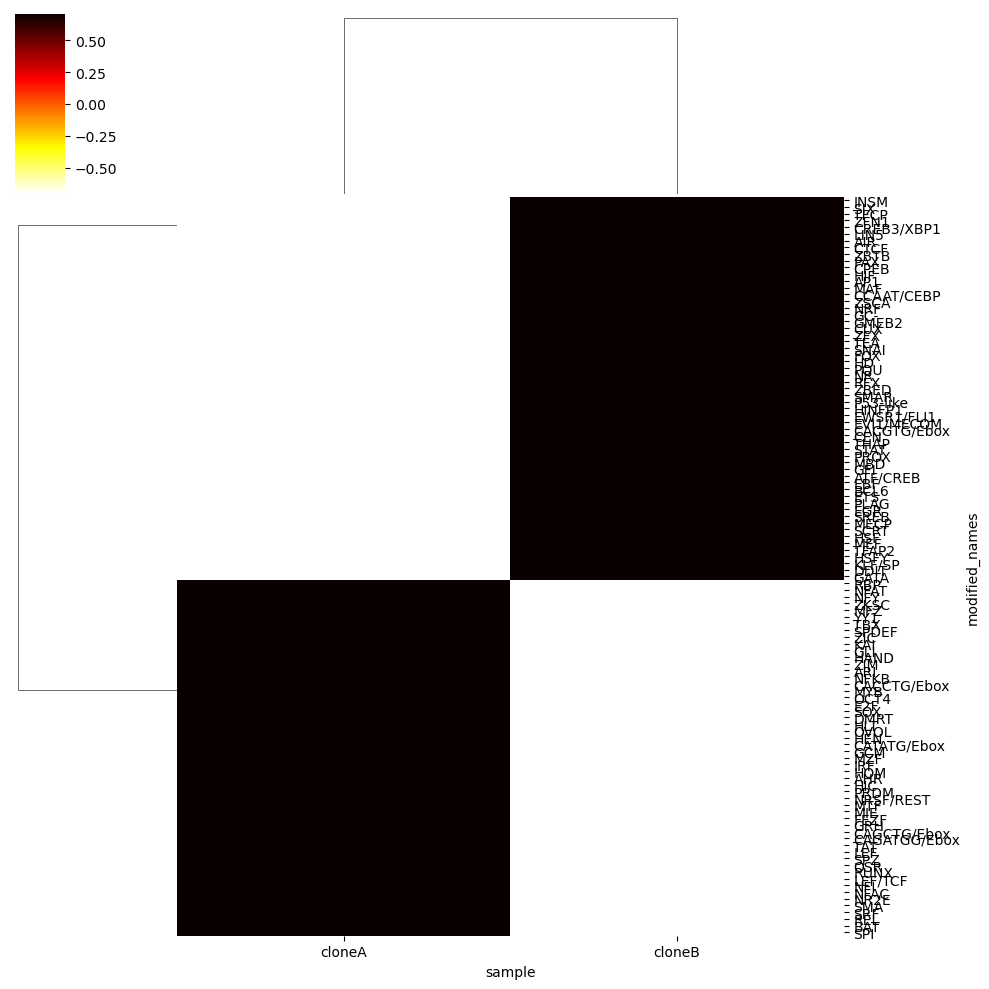

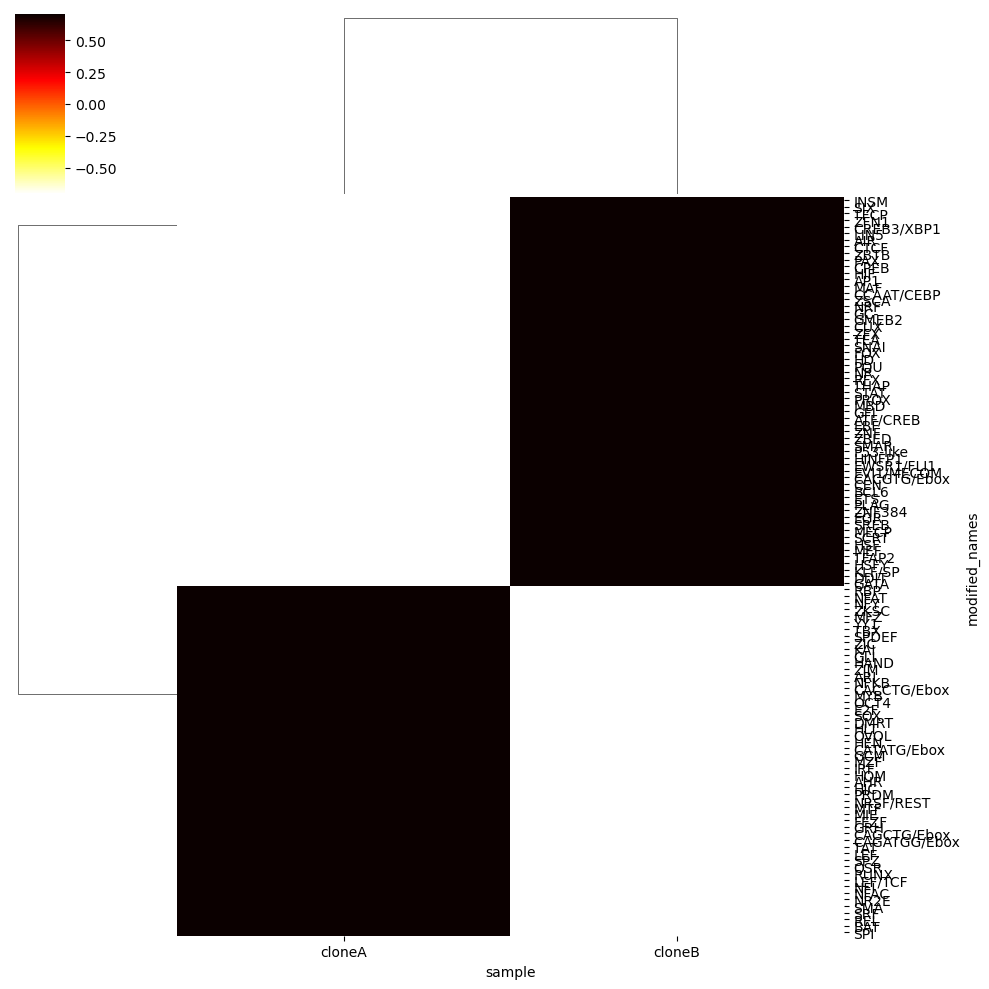

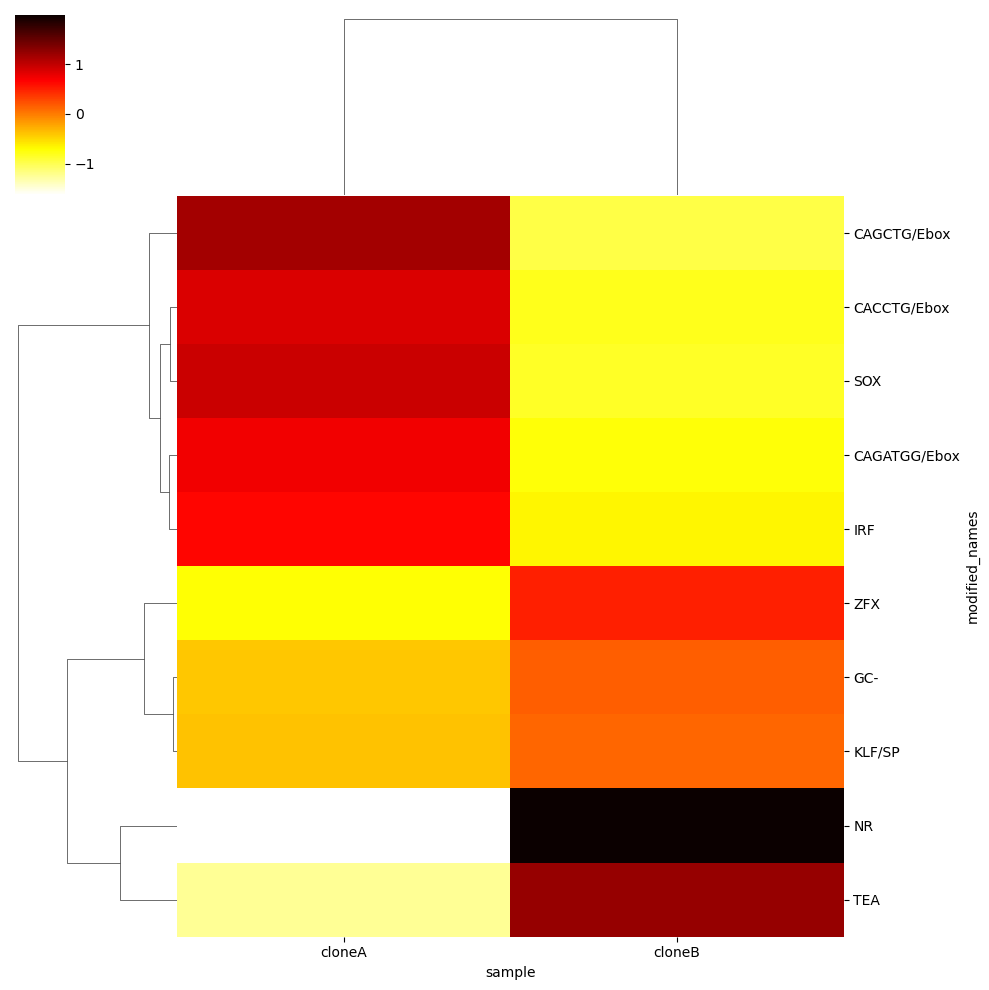

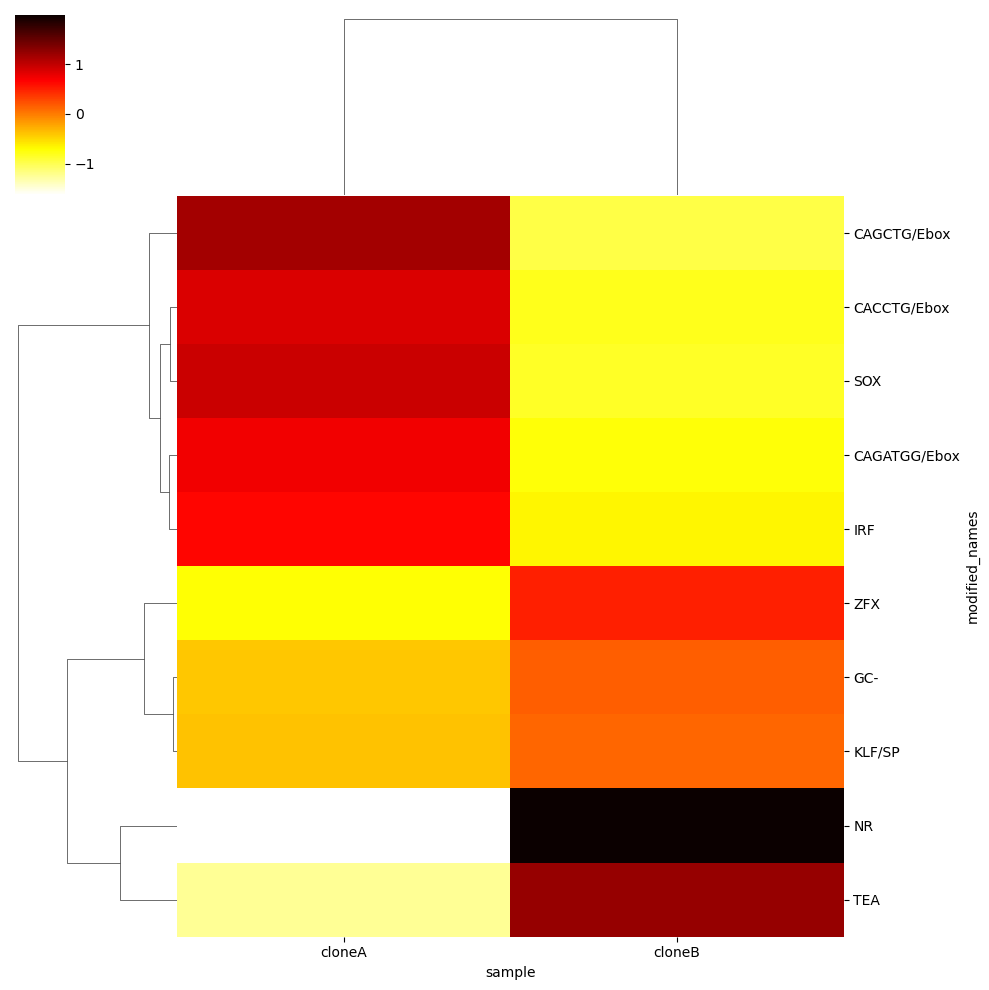

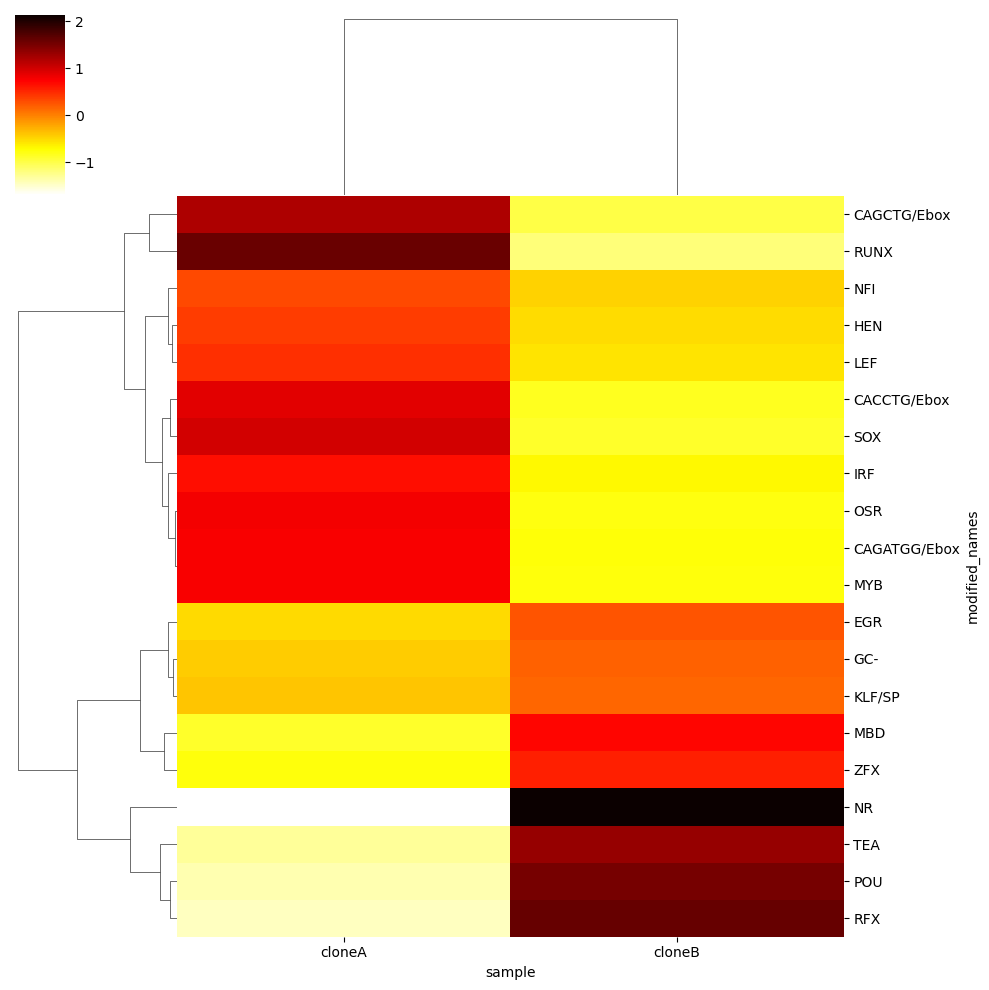

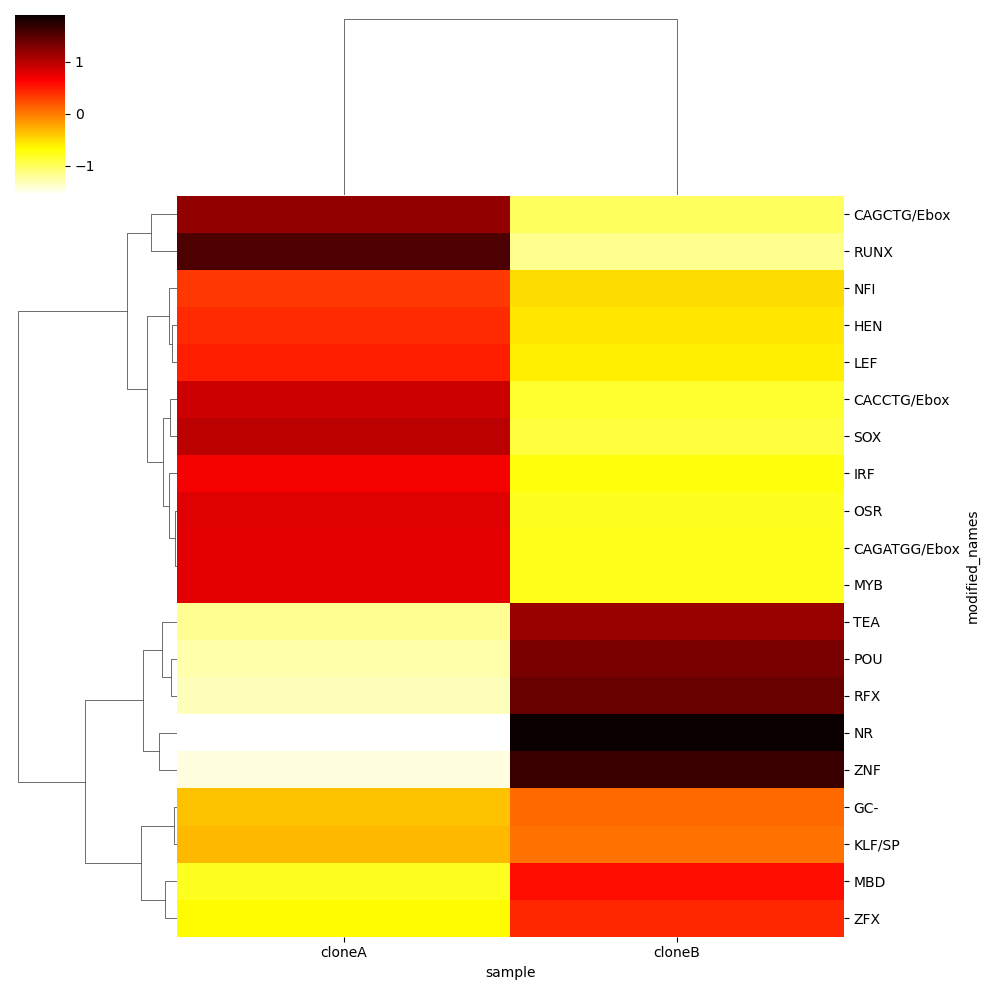

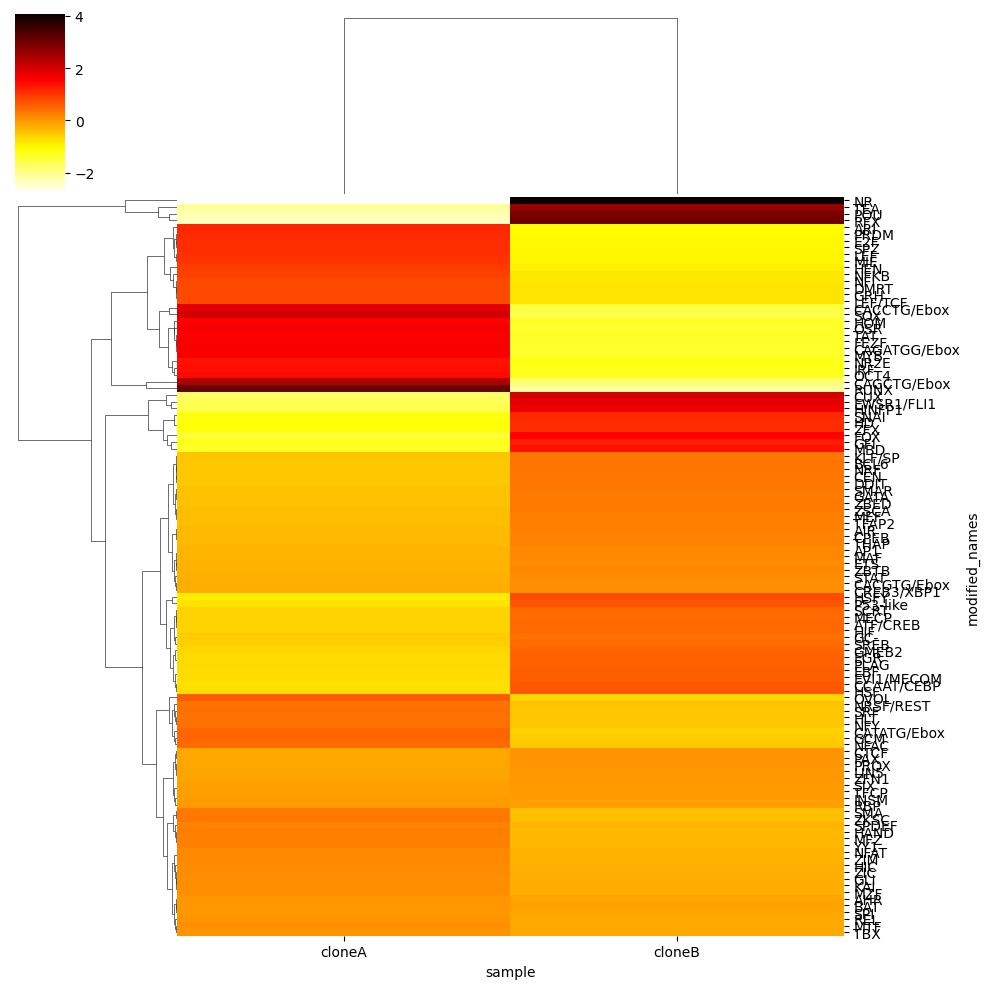

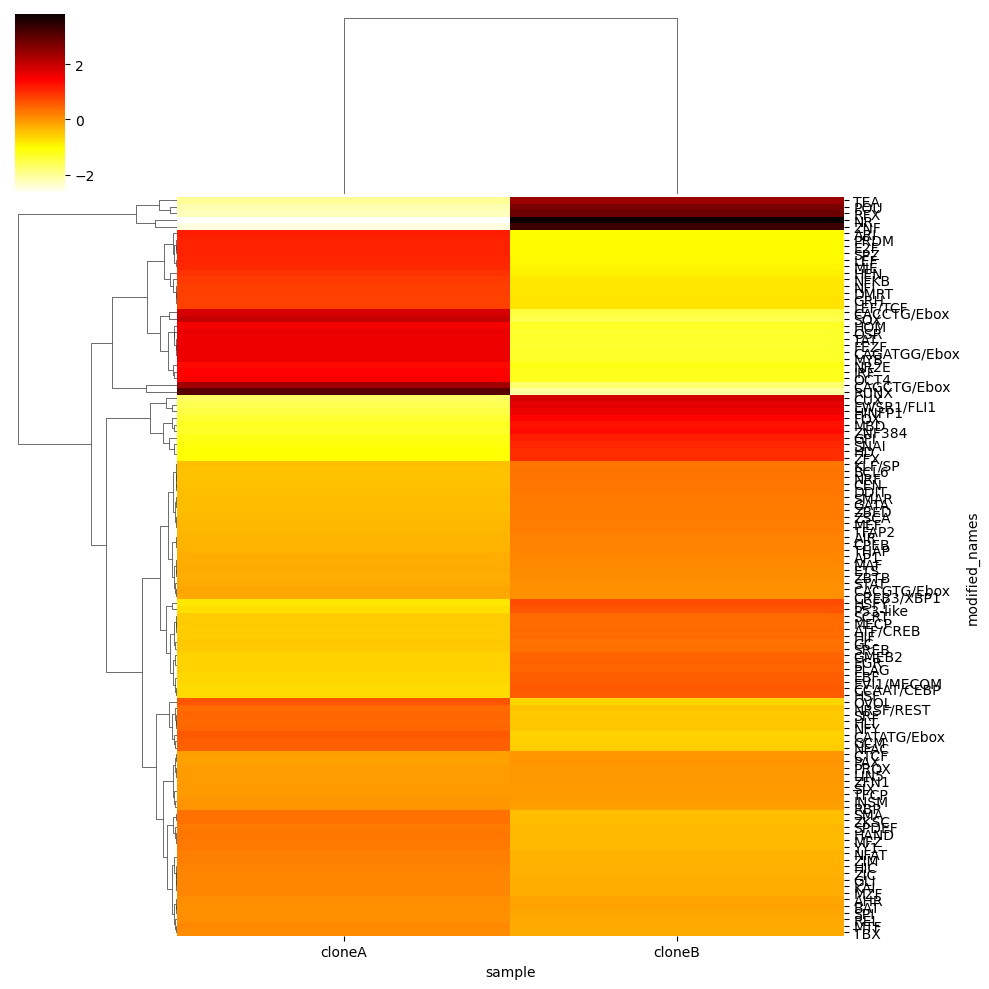

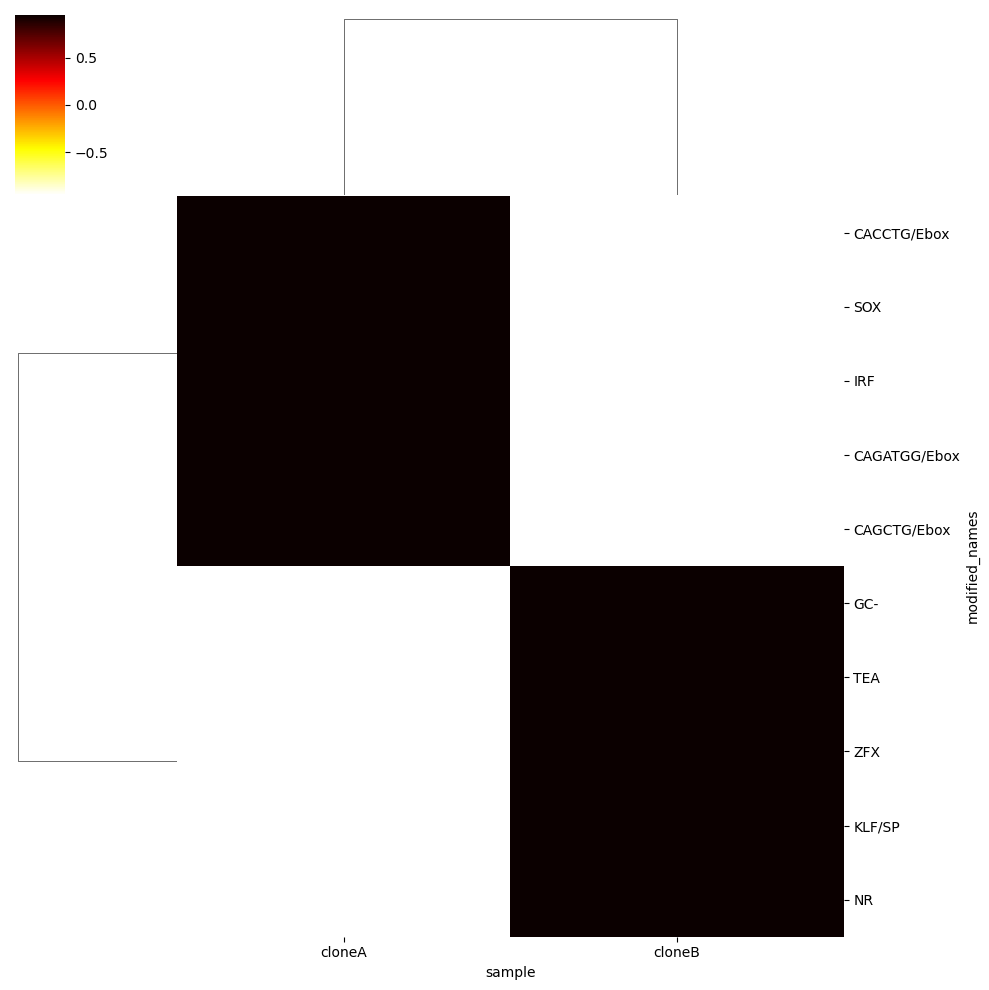

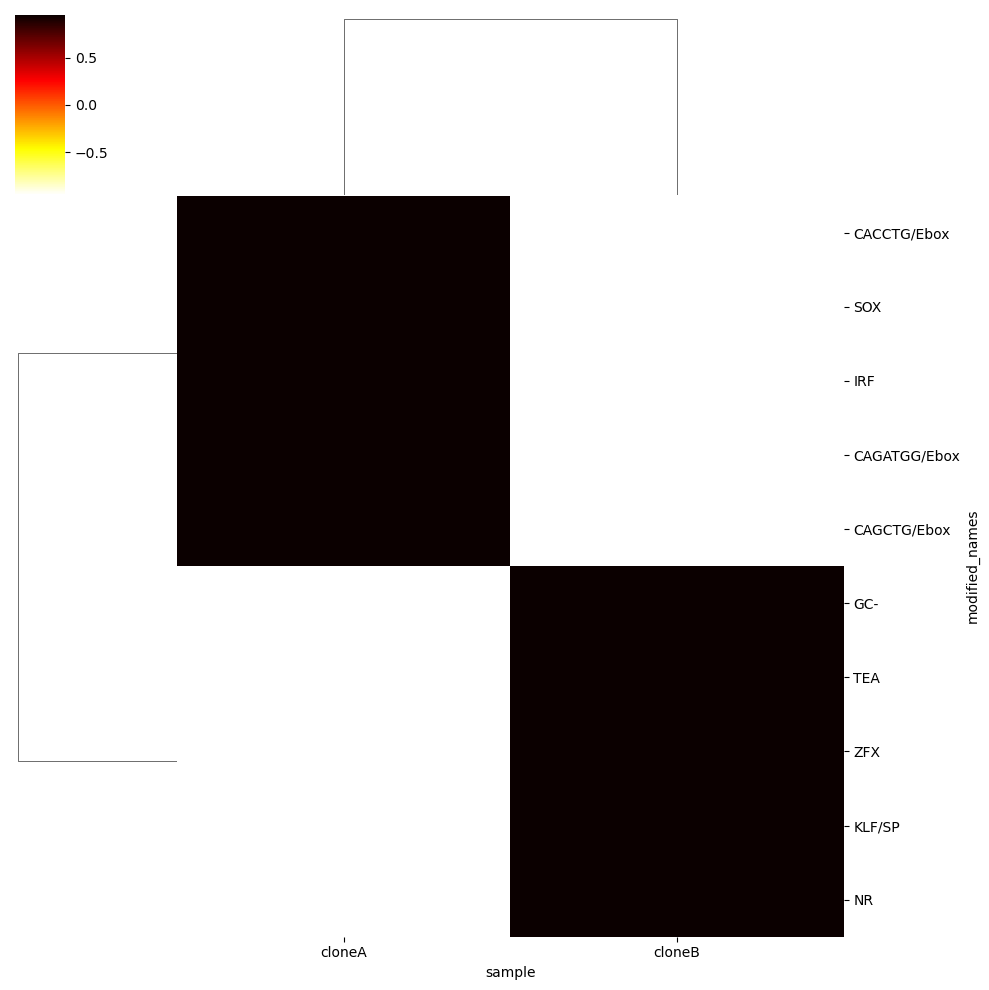

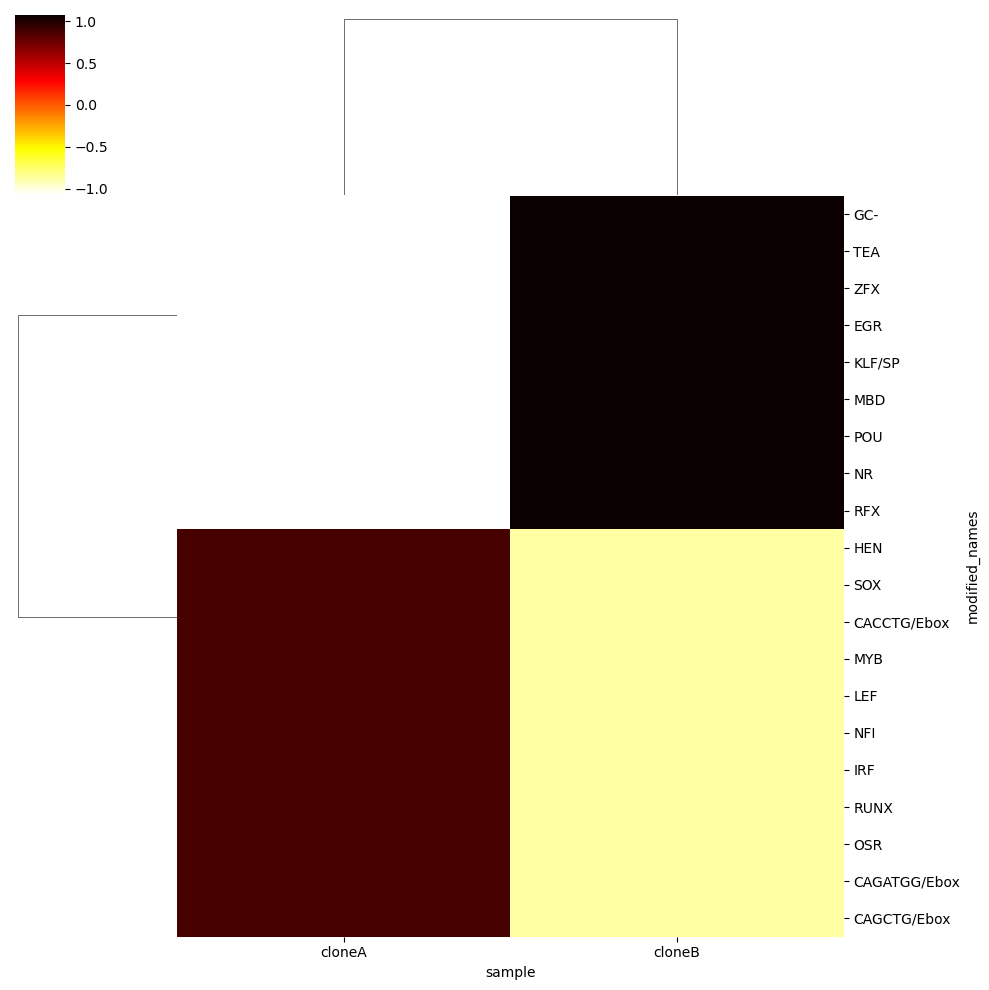

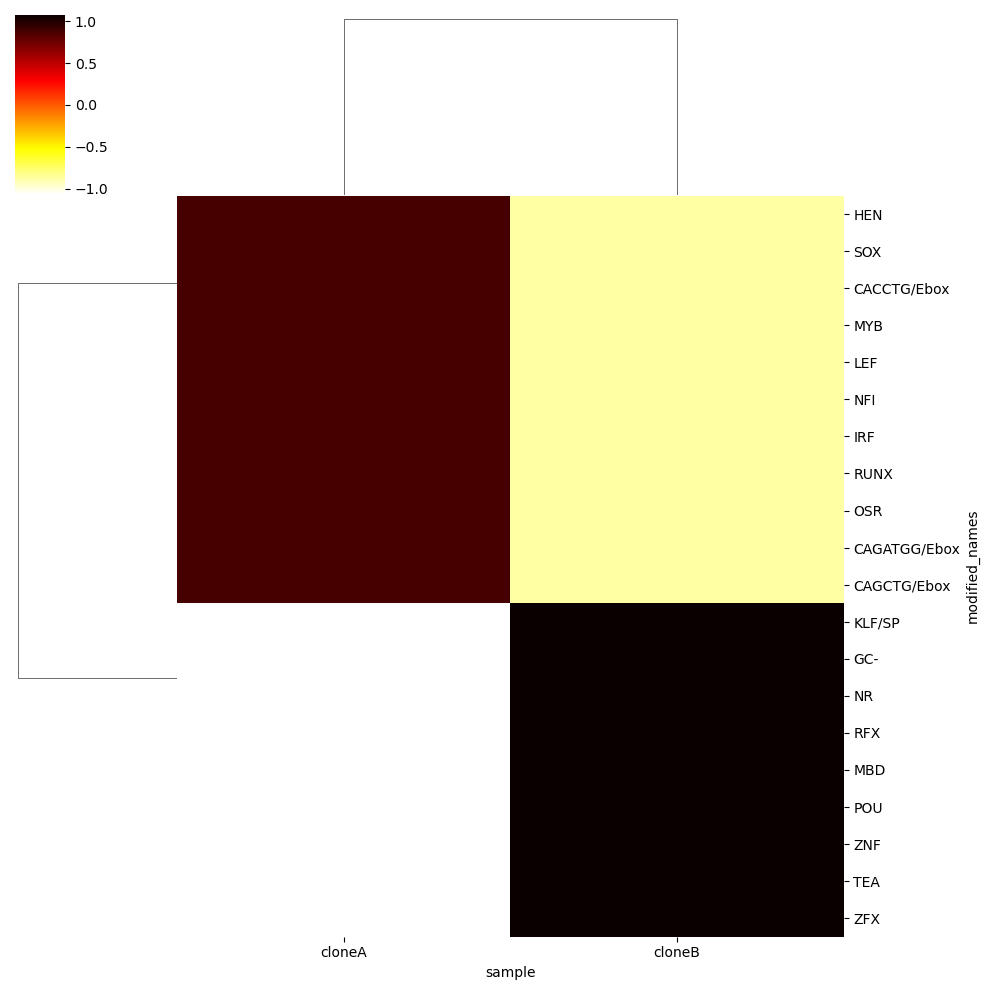

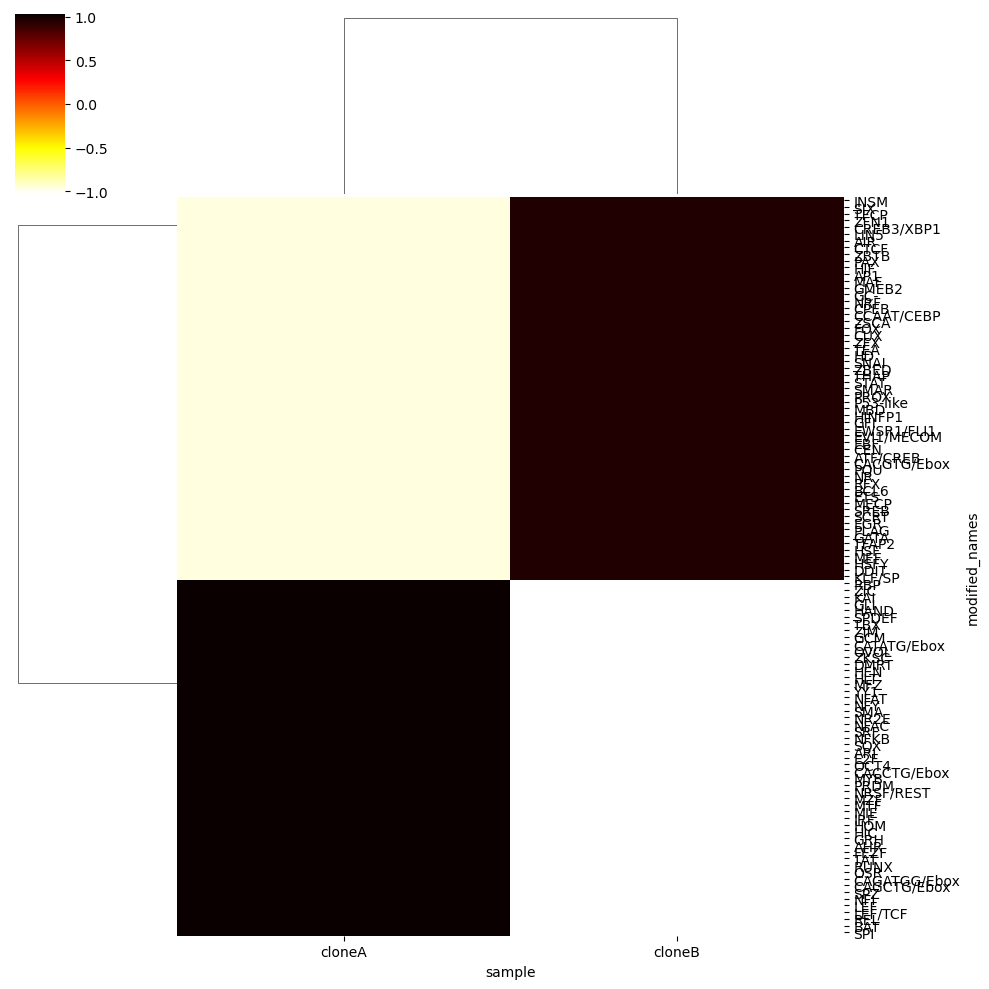

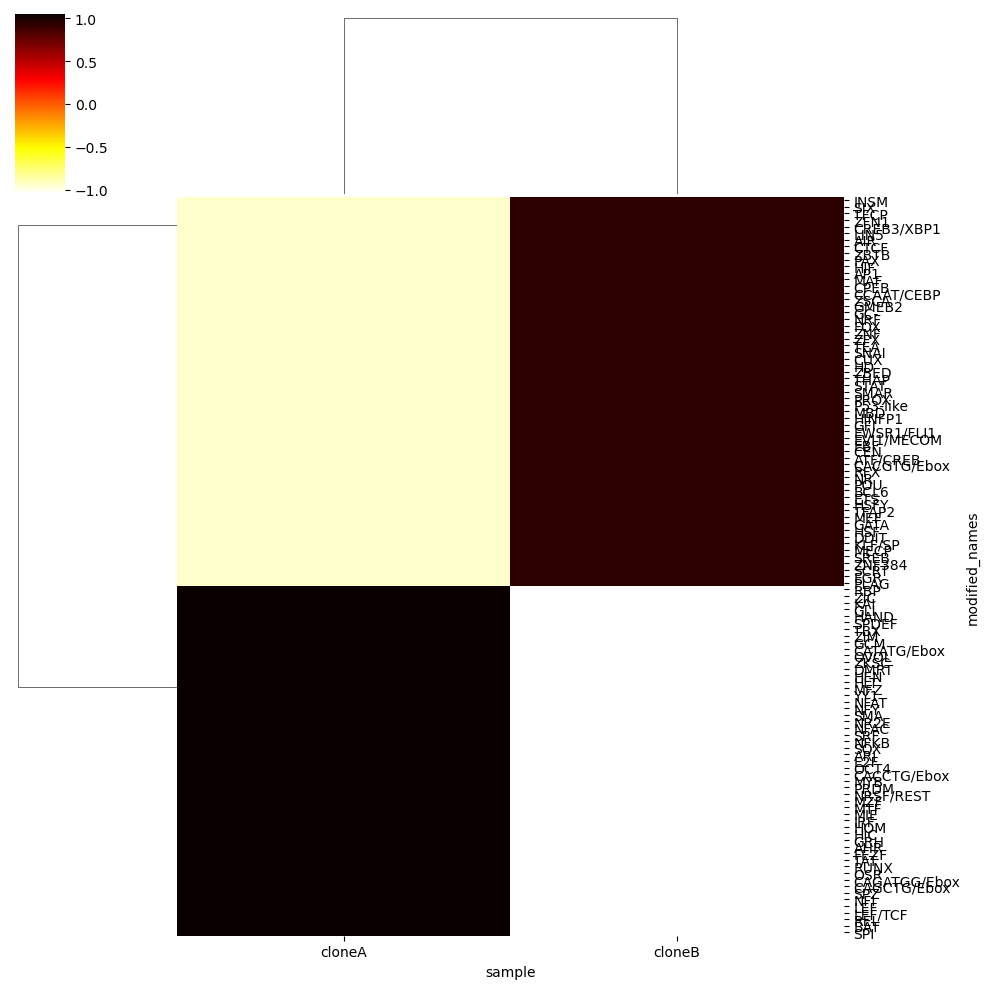

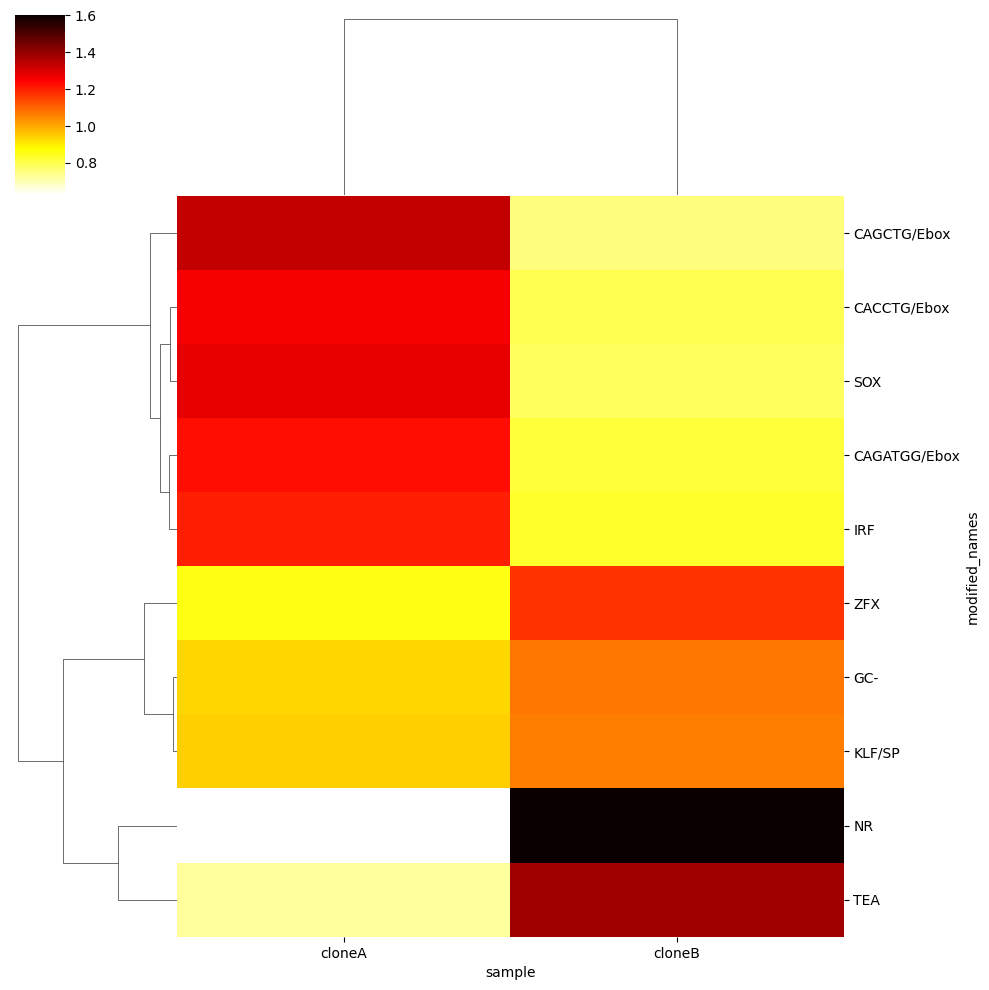

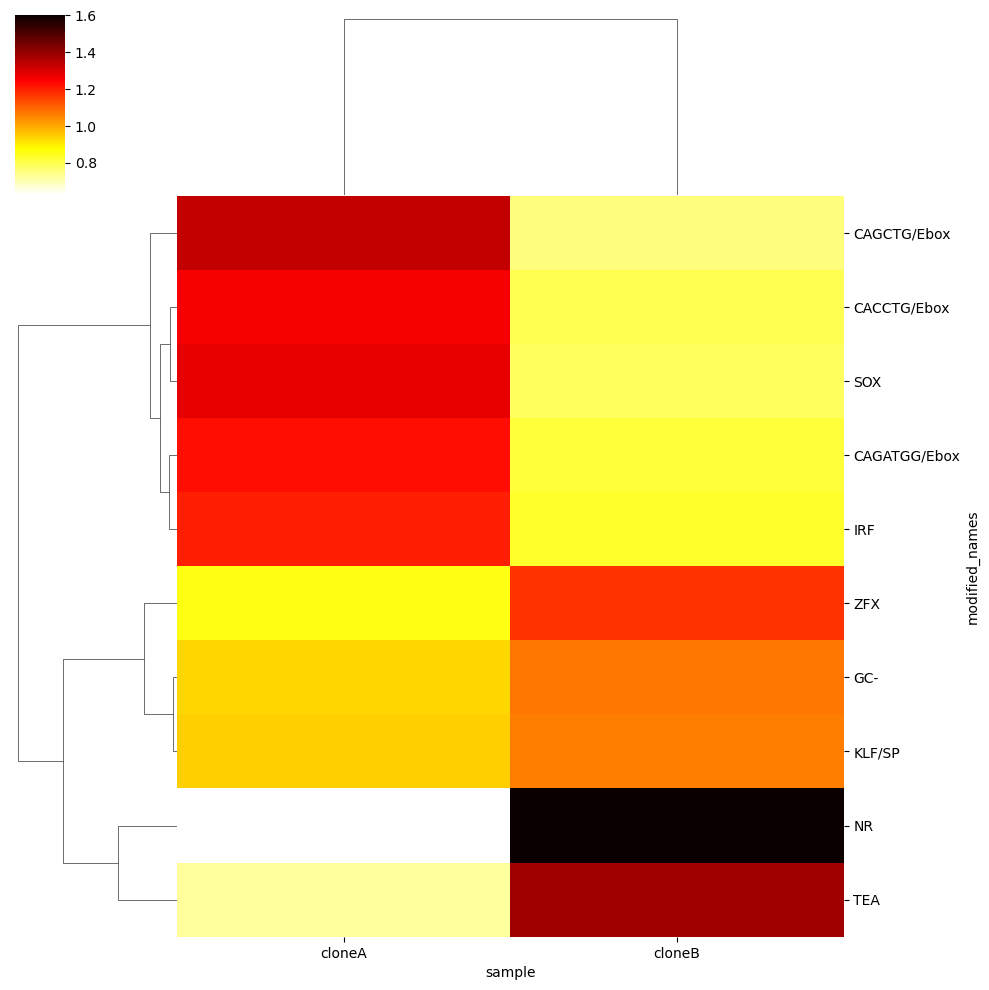

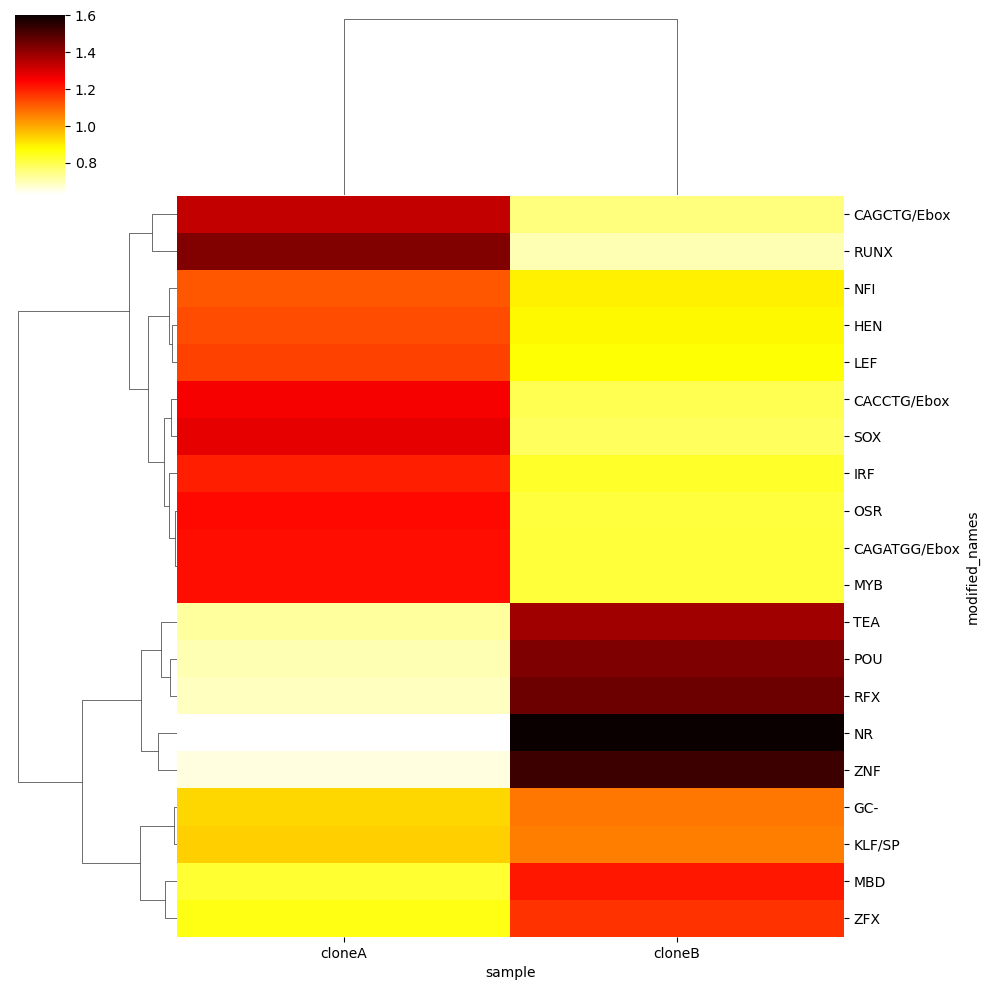

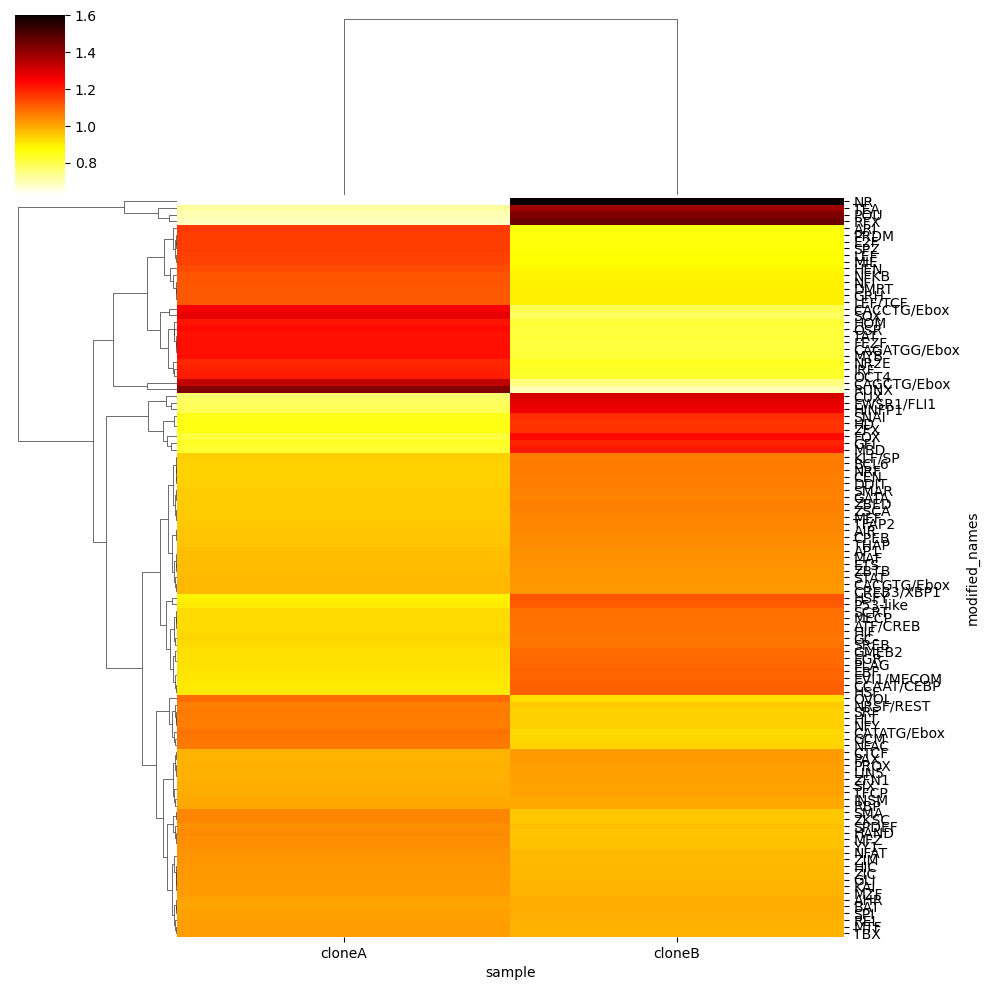

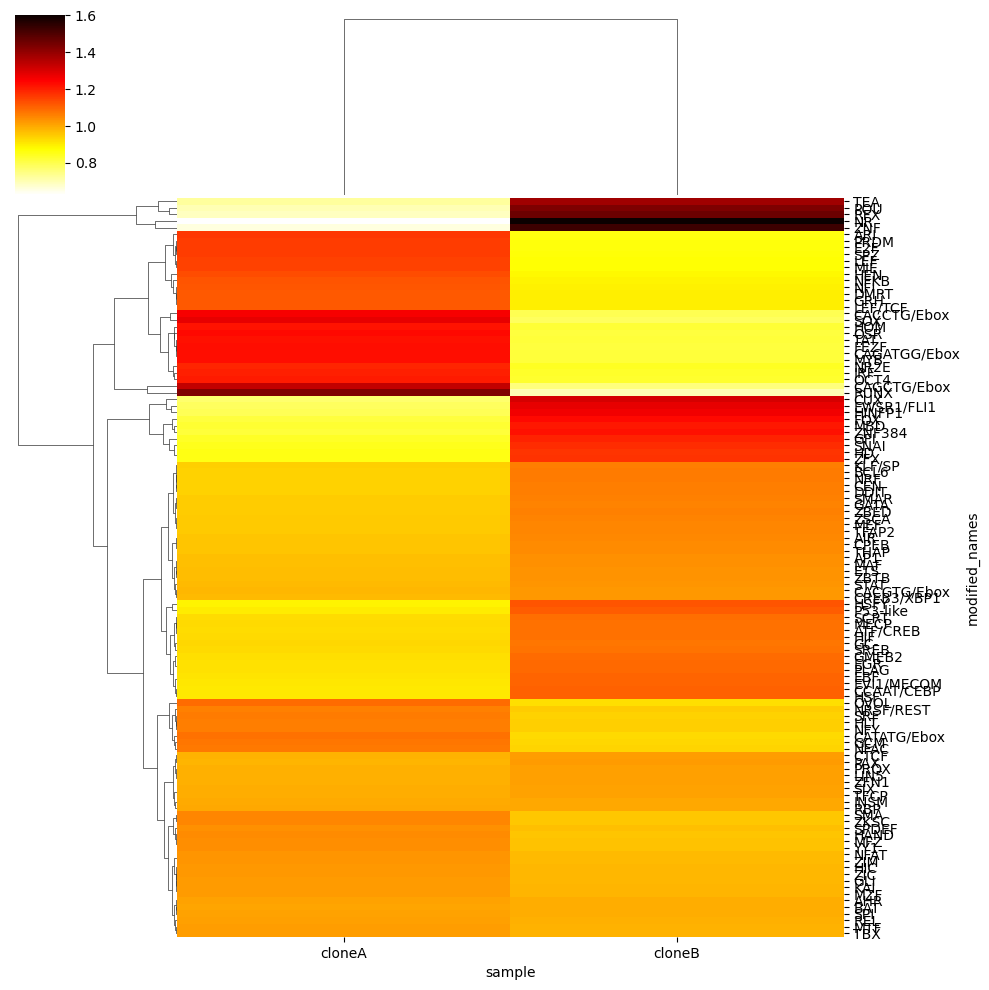

In [79]:
####################################################
# args
####################################################
suffix = 'clstrmp_mtfcmp_gbm39AvB'
grid ={'zscore': ['row', 'col', 'rowcol', None, ],
       'topn': [10, 20, None],
       'drop': ['ZNF', None]}
####################################################

dt = datetime.datetime.now().strftime('%y%m%d')
pfp = os.path.join('/home/nravindra/project/reg_diffs/results/tmp/', dt)
if not os.path.exists(pfp):
    os.makedirs(pfp)

count = 0
for zscore_type in grid['zscore']:
    for n in grid['topn']:
        for drop_motif in grid['drop']:
            print(count, '{}_{}_{}'.format(zscore_type, n, drop_motif))
            agg, p, dt = mtfcmp.viz_compare_enrich(
                enrich_out, 
                name_key=name_key, 
                drop_duplicates_key='modified_names', 
                names2display=None,
                topn=n,
                drop=drop_motif,
                zscore=zscore_type,
                save_plot=None if not export else os.path.join(pfp, '{}_z{}_top{}_drop{}.pdf'.format(suffix, zscore_type, n, drop_motif)),
                save_mat=None if not export else '/illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/{}_z{}_top{}_drop{}.csv'.format(suffix, zscore_type, n, drop_motif),
                return_plot_obj=True,
            )
            if export:
                dt['df_prez'].to_csv('/illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/{}_z{}_top{}_drop{}_preZ.csv'.format(suffix, zscore_type, n, drop_motif))
                print('  wrote {}'.format('/illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/{}_z{}_top{}_drop{}_preZ.csv'.format(suffix, zscore_type, n, drop_motif)))
            count+=1


In [13]:
print(dt.index[p.dendrogram_row.reordered_ind])
print(dt.columns[p.dendrogram_col.reordered_ind])

Index(['CTCF/ZNF', 'ZNF', 'MXI/RFX', 'RFX', 'NHLH/TFAP', 'OLIG/ZBTB', 'KLF',
       'MYOD/TFAP', 'NFI', 'RBP', 'HIC', 'SMA', 'TFAP', 'MEF', 'AR/NR3C',
       'SOX', 'SOX/SRY', 'CTCF', 'SRE', 'BCL1', 'BHLHE/USF', 'HES/MAX',
       'BARX/NKX', 'HNF', 'HNF4A/ZNF', 'ESRRA/NR5A', 'NR2', 'NR2C/NR4A',
       'NR2C/RXRA', 'RAR', 'CRX/PAX', 'DLX/LHX', 'PAX/VSX', 'CENPBD/GMEB',
       'HESX/HOXB', 'VEN', 'RUN', 'HMX', 'NKX', 'HMX/ISL', 'MSANTD/NKX', 'TEA',
       'TP', 'FLI/ZNF', 'GRHL/TFCP', 'FOXO', 'BCL11A/SPI', 'ELF/SPIB',
       'EOMES/TBX', 'PAX/ZNF', 'RRE', 'ASCL/TCF', 'SNAI/ZEB', 'KLF/SP',
       'MAZ/ZNF', 'IRF/STAT', 'PRD', 'EGR/HES', 'NR2F/RXRG', 'HOXD/TBP',
       'CDX/HOXA', 'CDX/HOXC', 'HOX', 'GATA/TRPS', 'LEF/TCF7L', 'PRDM/ZNF',
       'ZFP/ZNF', 'FOXC/HOXD', 'GATA', 'FOXC/TBP', 'PAX', 'FOX', 'SRY'],
      dtype='object', name='modified_names')
Index(['brca', 'luad', 'blca', 'coad', 'kirc', 'kirp', 'gbm', 'skcm'], dtype='object', name='sample')


# GBM 45

In [81]:
# run tst
enrich_out = evalism.chi2ovr(
        data=gbm45,
        groups=None,
        notB_key='end_cnt_before', 
        B_key='end_cnt_after',
        return_df=True,
        verbose=True,
        name_key=name_key,
        )


data merged into one df in 2-s
through cloneA. time elapsed: 2-s
through cloneB. time elapsed: 2-s
n_tst: 224


0 row_10_ZNF
  wrote /illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/clstrmp_mtfcmp_gbm45AvB_zrow_top10_dropZNF_preZ.csv
1 row_10_None
  wrote /illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/clstrmp_mtfcmp_gbm45AvB_zrow_top10_dropNone_preZ.csv
2 row_20_ZNF
  wrote /illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/clstrmp_mtfcmp_gbm45AvB_zrow_top20_dropZNF_preZ.csv
3 row_20_None
  wrote /illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/clstrmp_mtfcmp_gbm45AvB_zrow_top20_dropNone_preZ.csv
4 row_None_ZNF
  wrote /illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/clstrmp_mtfcmp_gbm45AvB_zrow_topNone_dropZNF_preZ.csv
5 row_None_None
  wrote /illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/clstrmp_mtfcmp_gbm45AvB_zrow_topNone_dropNone_preZ.csv
6 col_10_ZNF
  wrote /illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/clstrmp_mtfcmp_gbm45AvB_zcol_top10_dropZNF_preZ.csv
7 col_10_None
  wrote /illu

/home/nravindra/miniconda3/envs/seq2atac/lib/python3.10/site-packages/seaborn/matrix.py:812: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(figsize=figsize)


  wrote /illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/clstrmp_mtfcmp_gbm45AvB_zNone_top20_dropZNF_preZ.csv
21 None_20_None
  wrote /illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/clstrmp_mtfcmp_gbm45AvB_zNone_top20_dropNone_preZ.csv
22 None_None_ZNF
  wrote /illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/clstrmp_mtfcmp_gbm45AvB_zNone_topNone_dropZNF_preZ.csv
23 None_None_None
  wrote /illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/clstrmp_mtfcmp_gbm45AvB_zNone_topNone_dropNone_preZ.csv


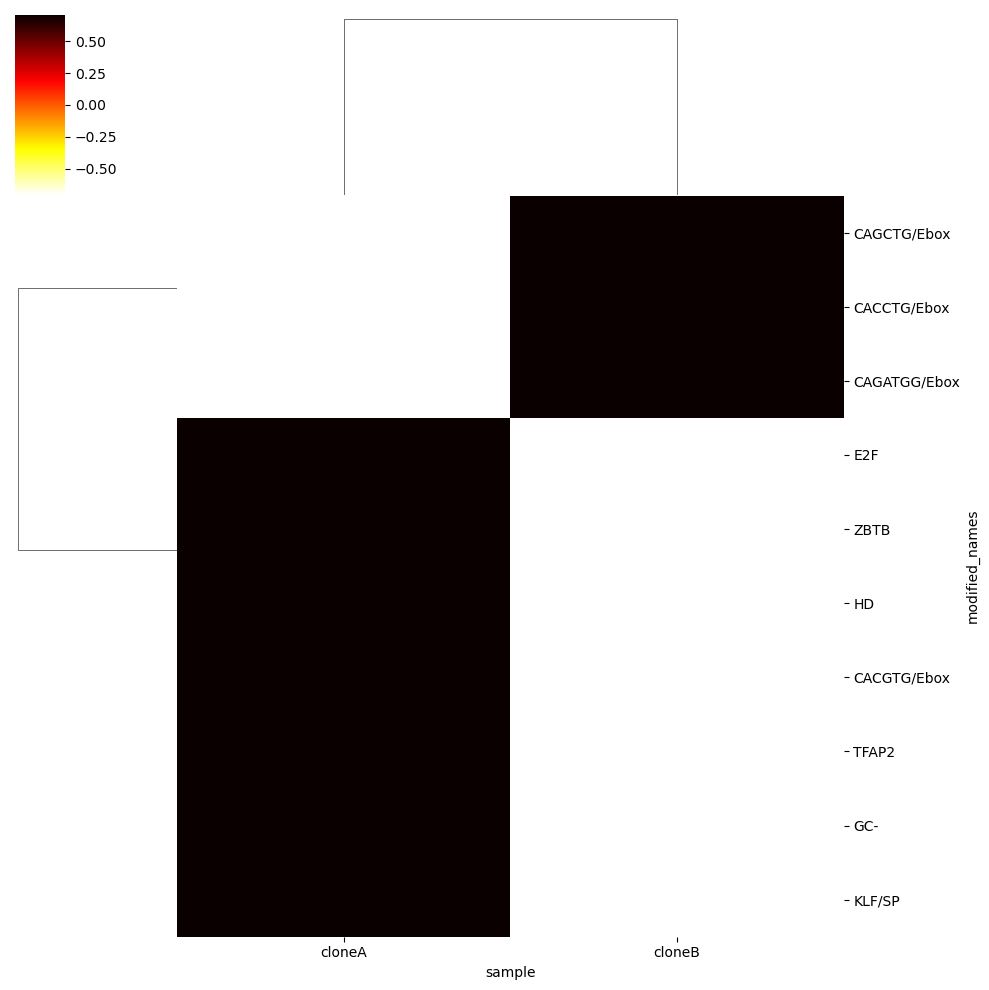

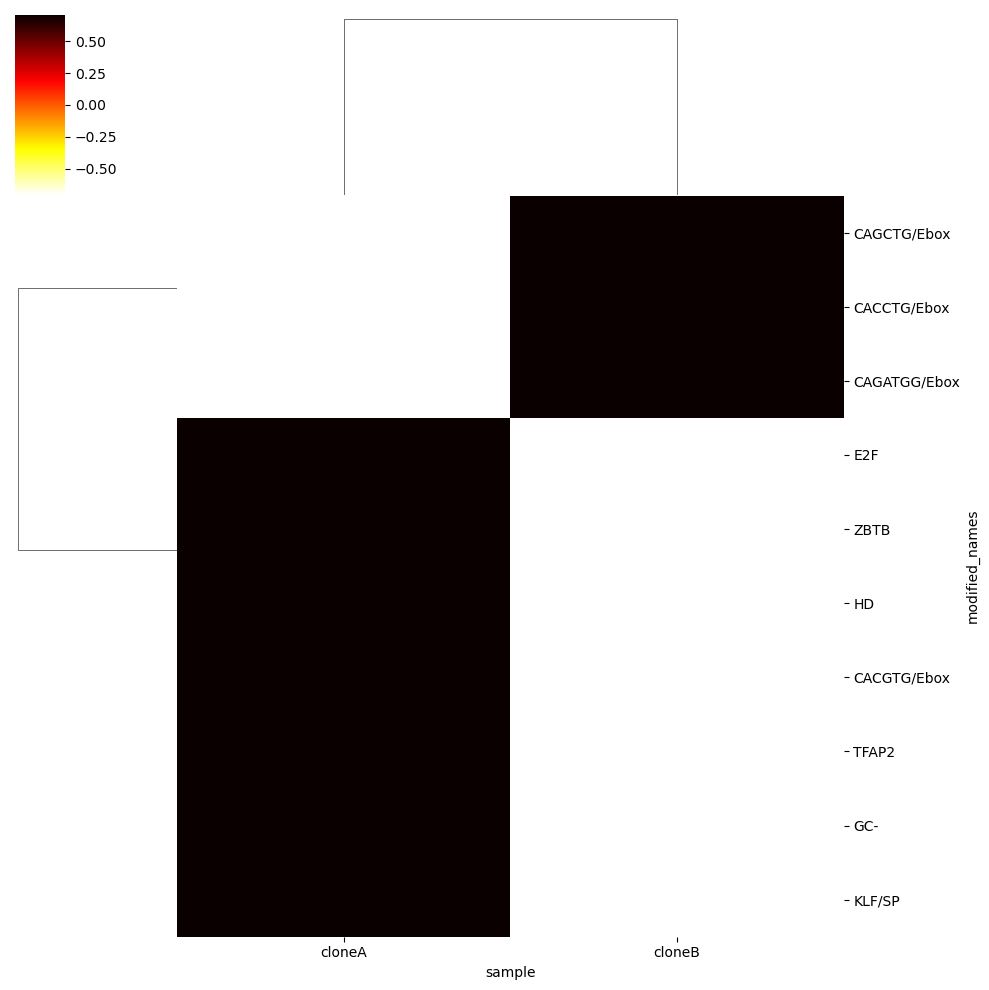

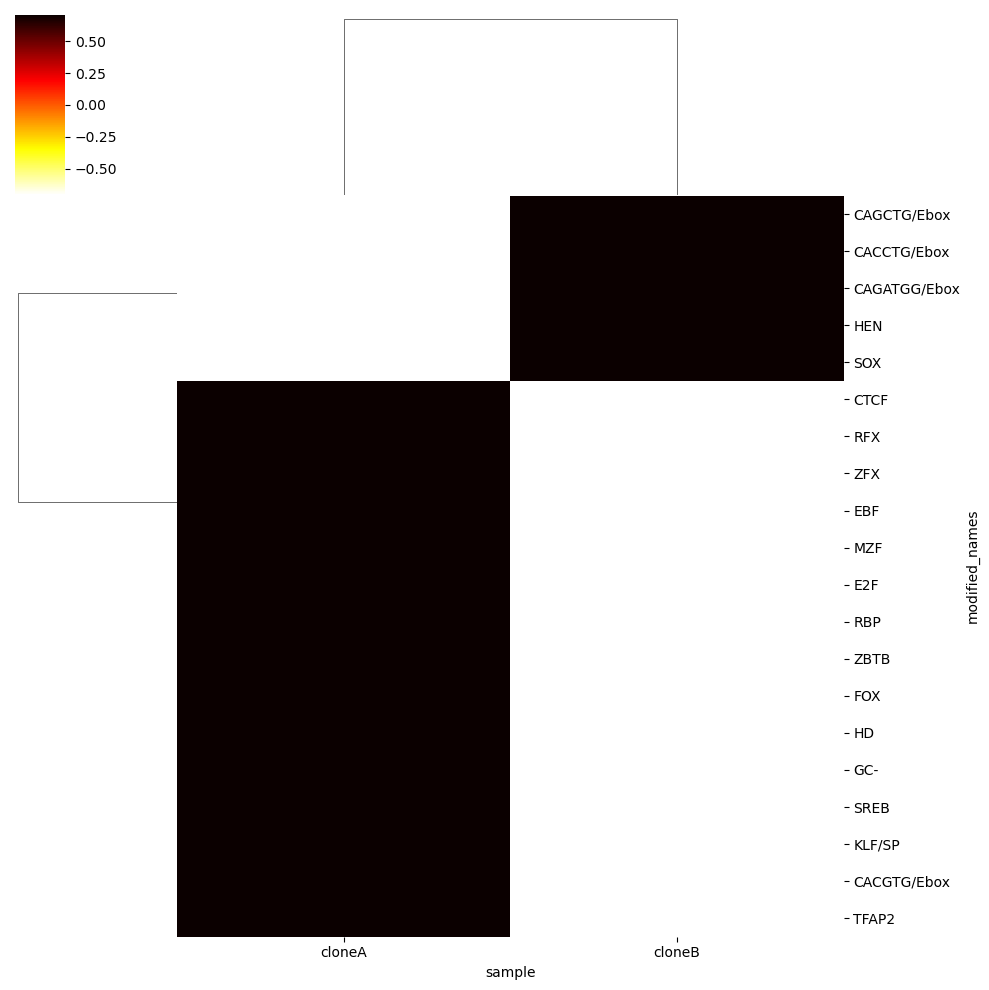

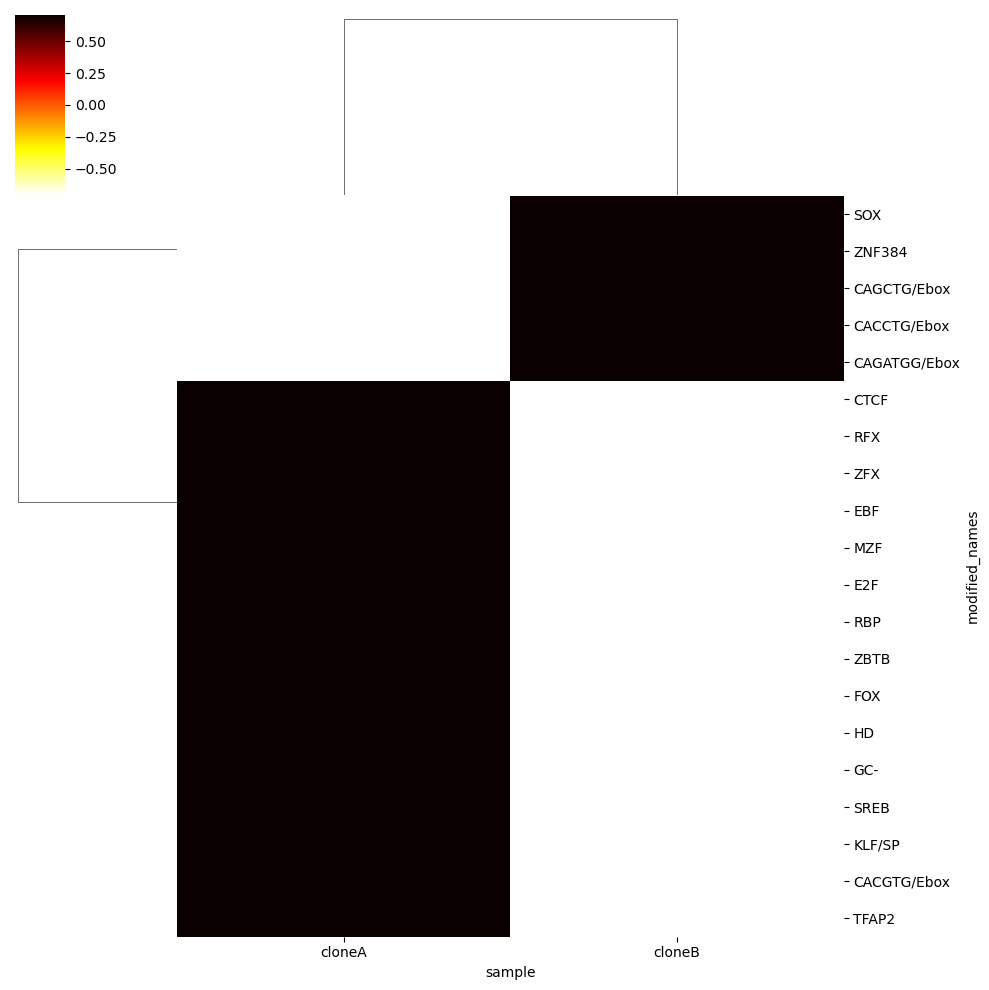

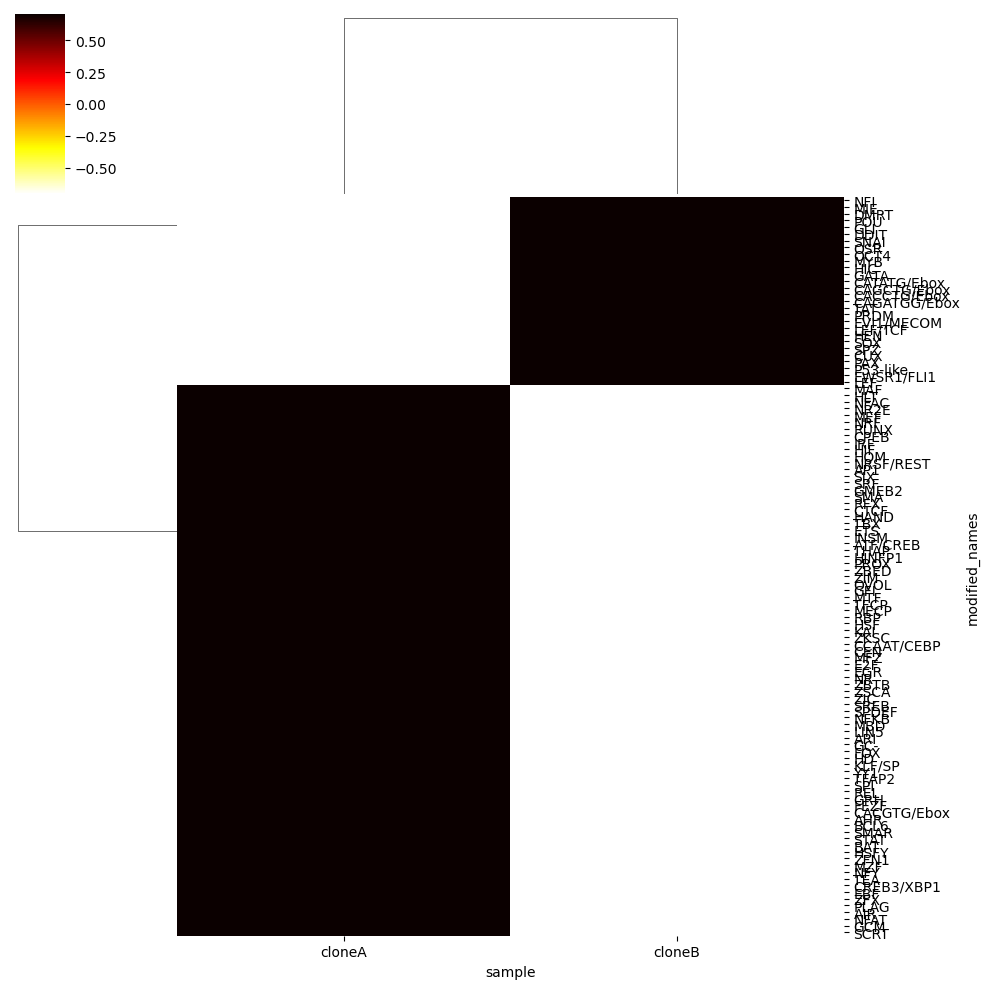

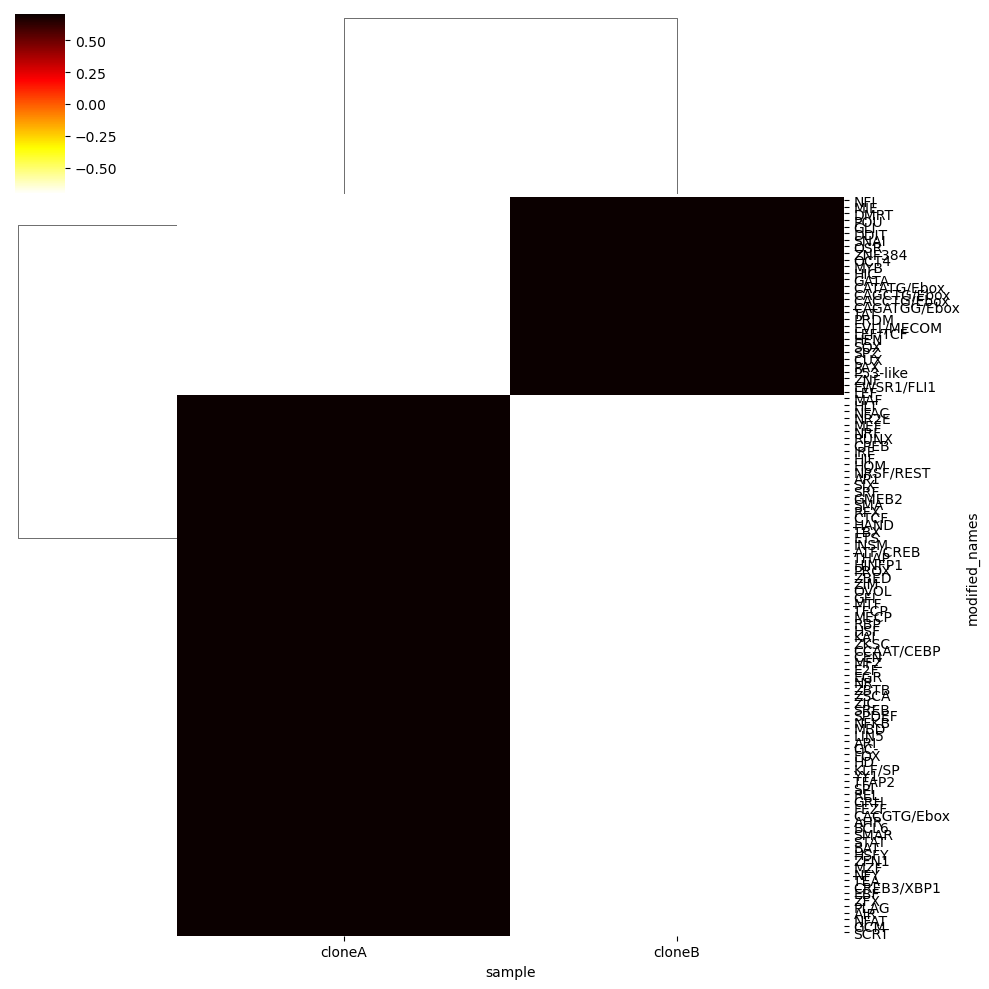

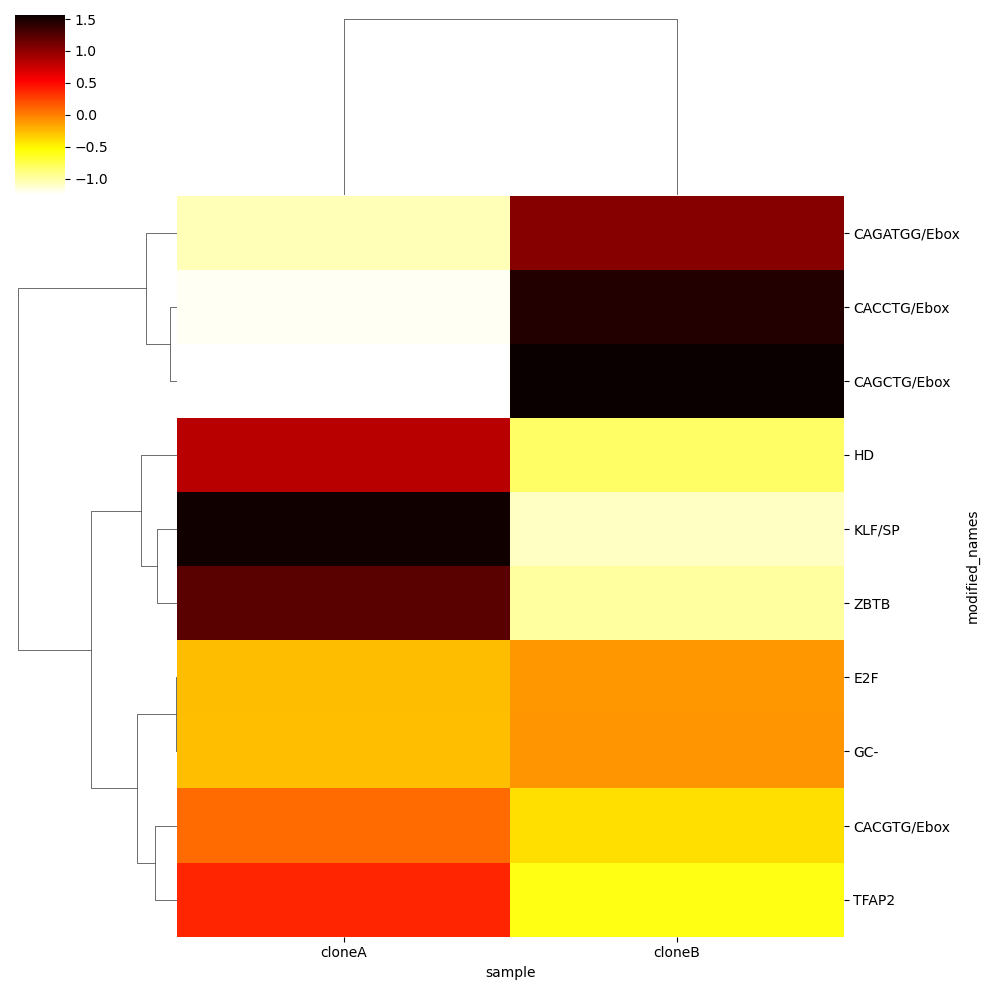

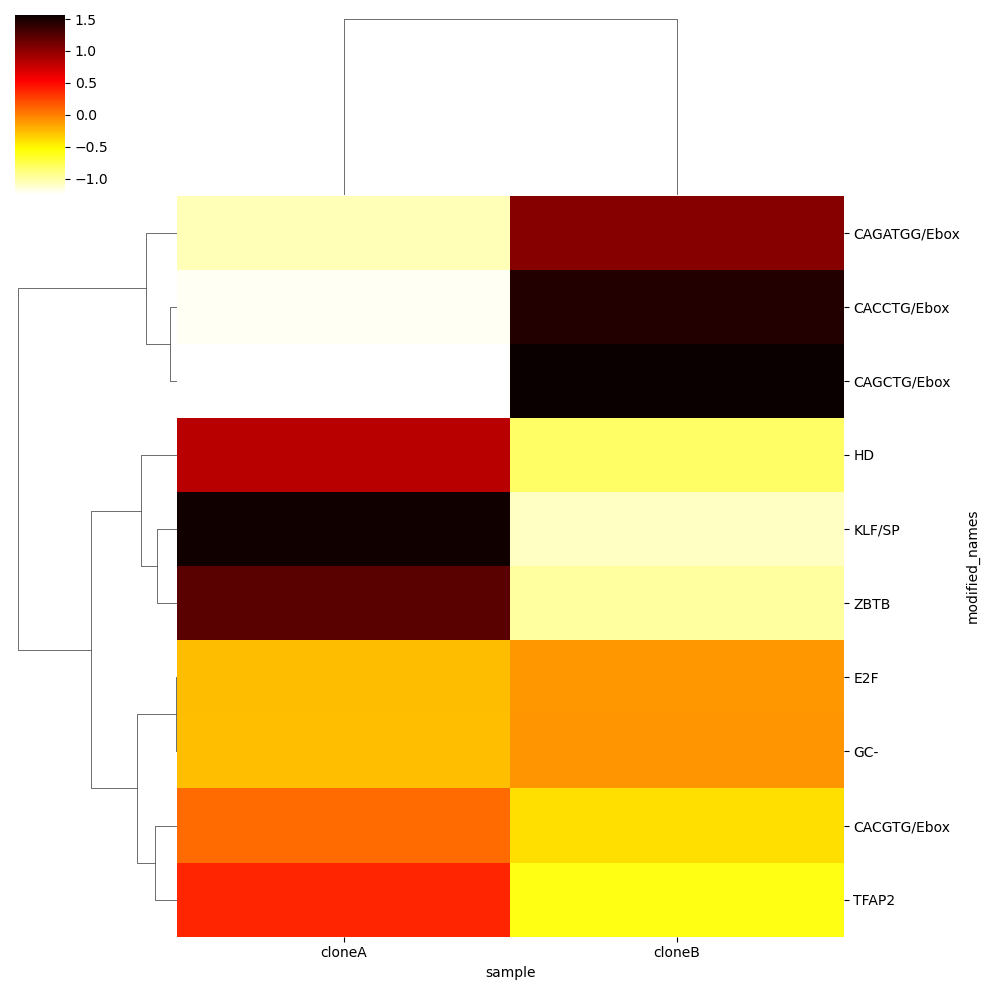

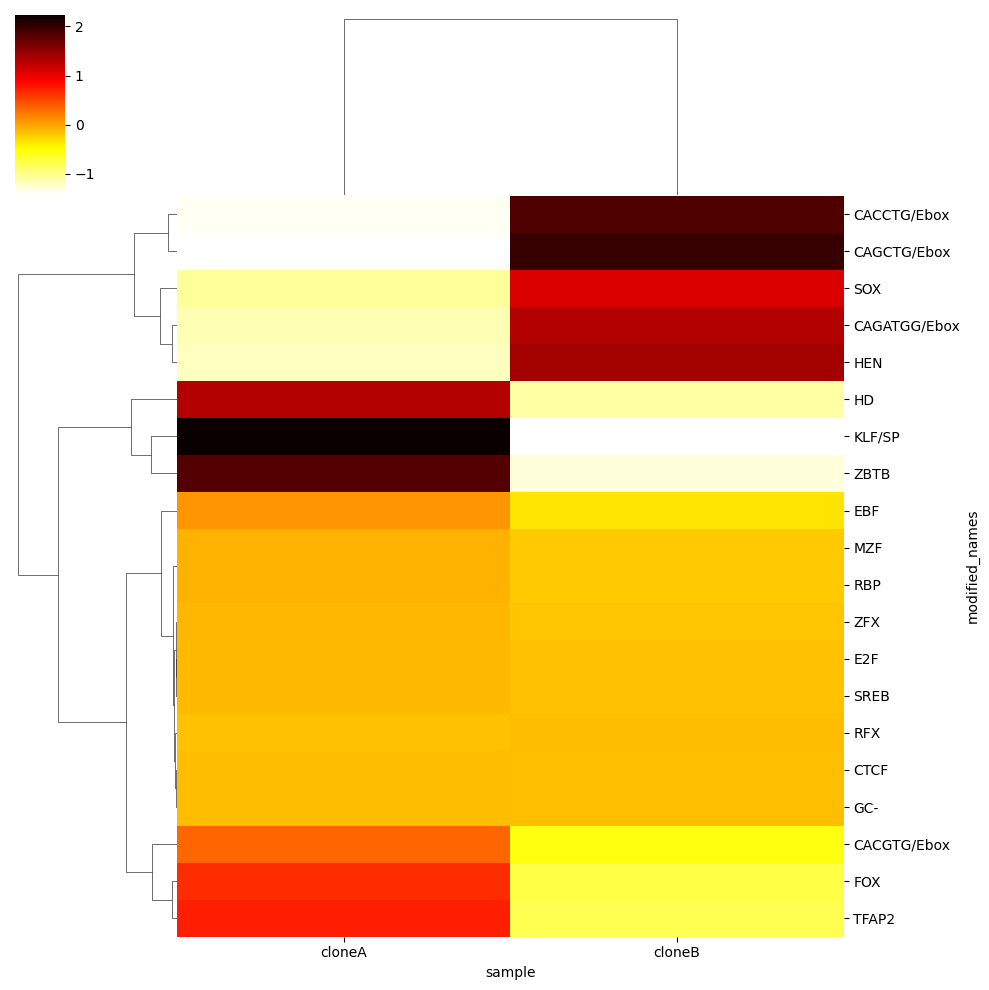

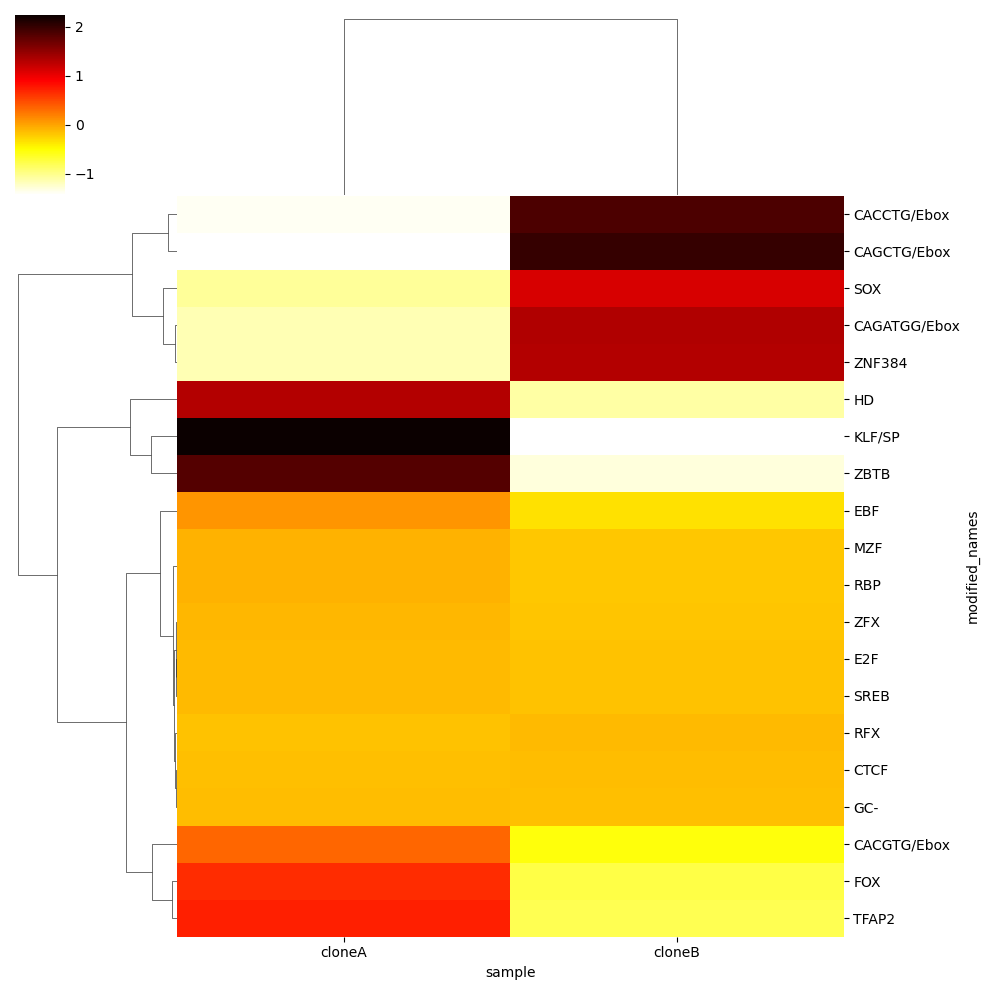

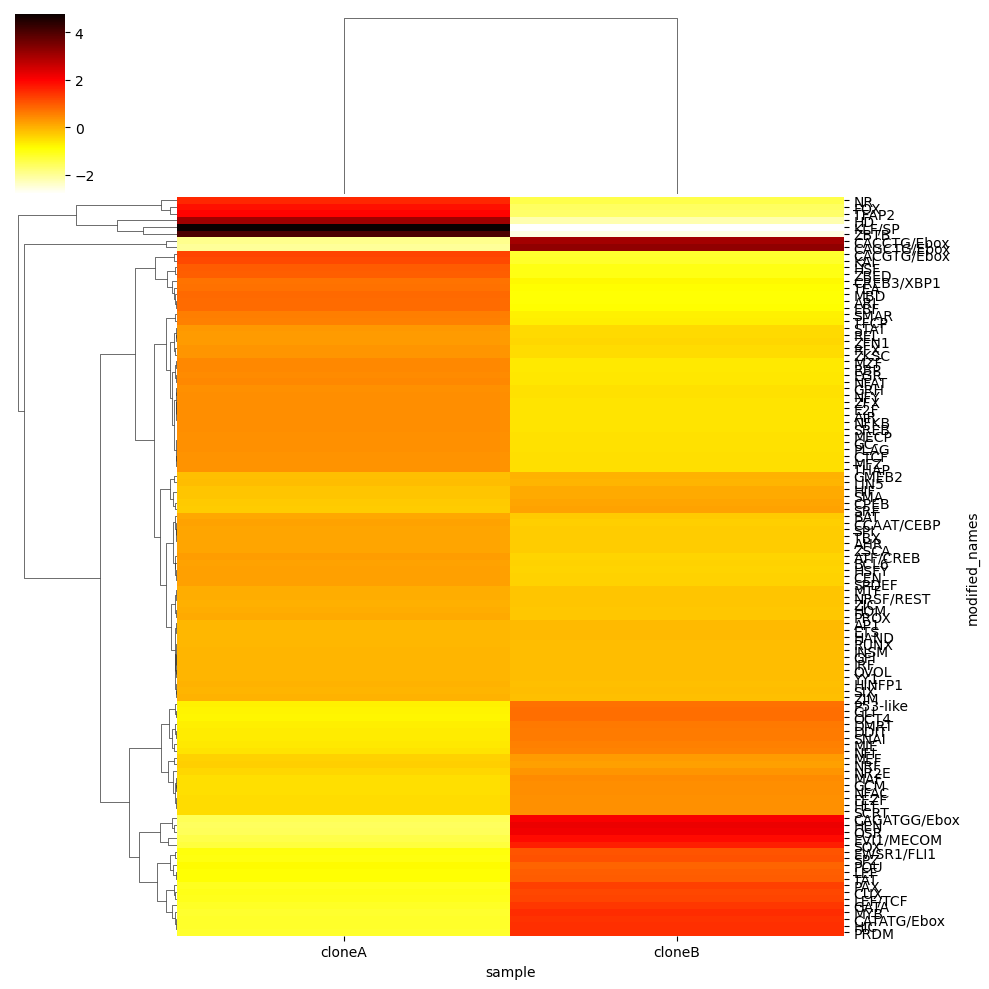

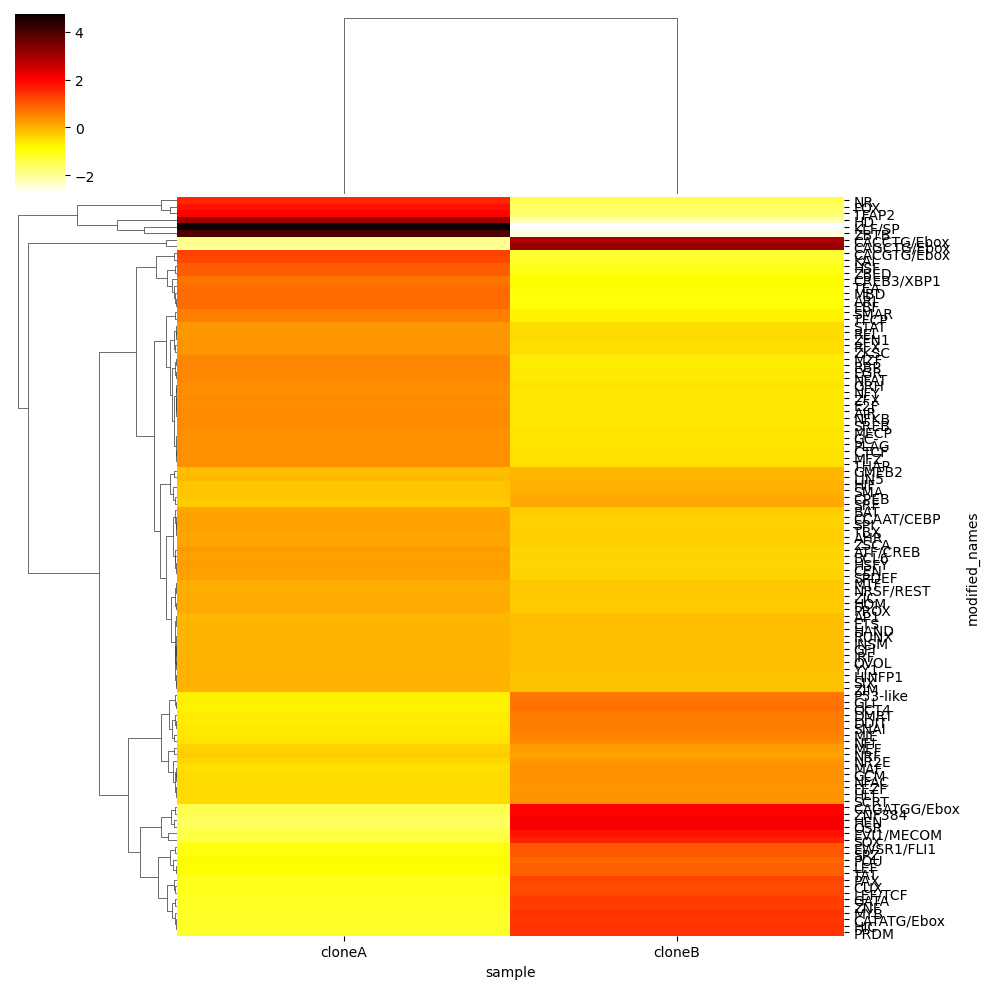

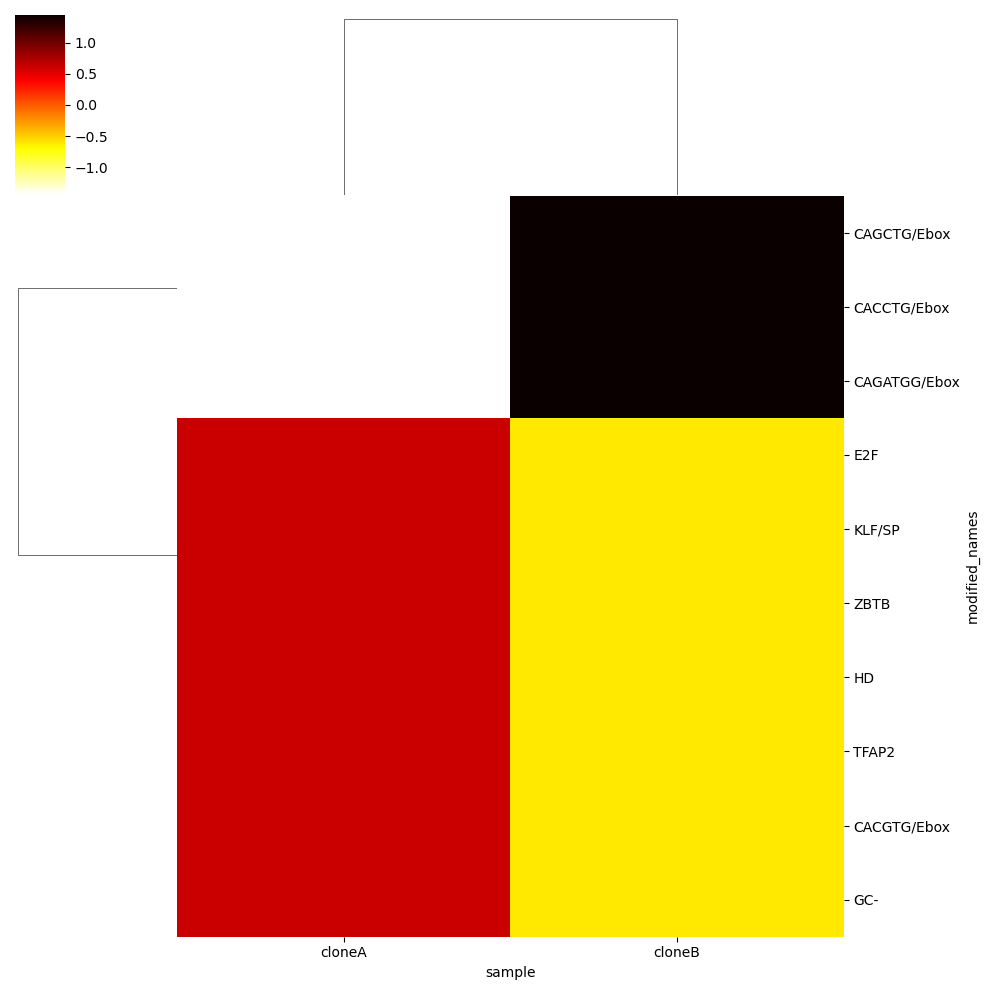

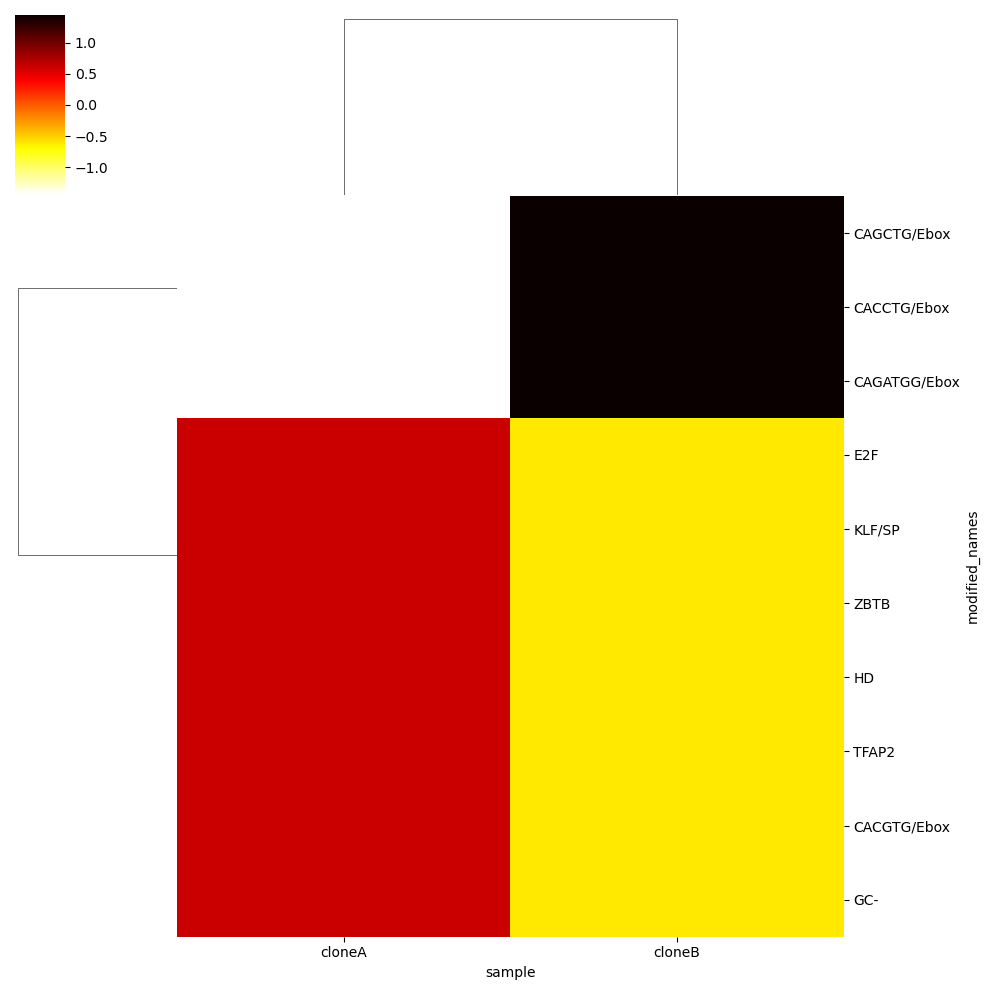

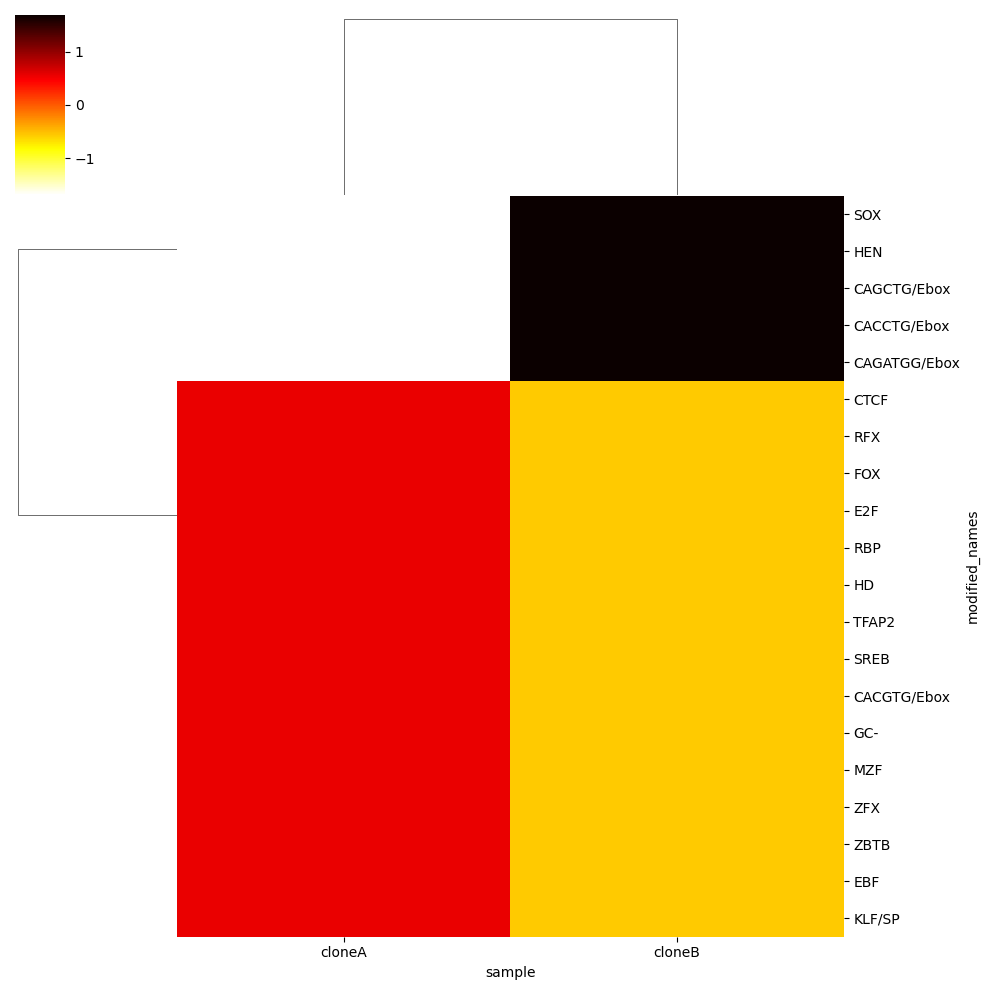

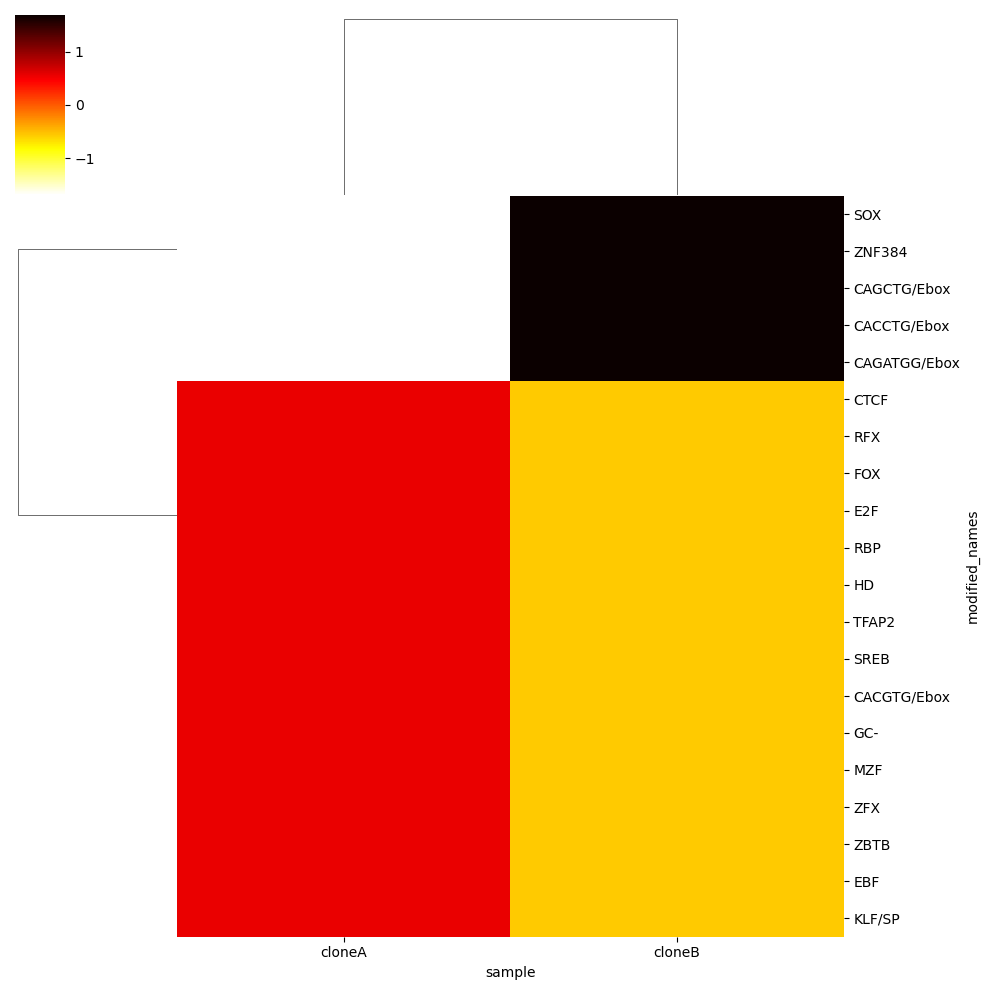

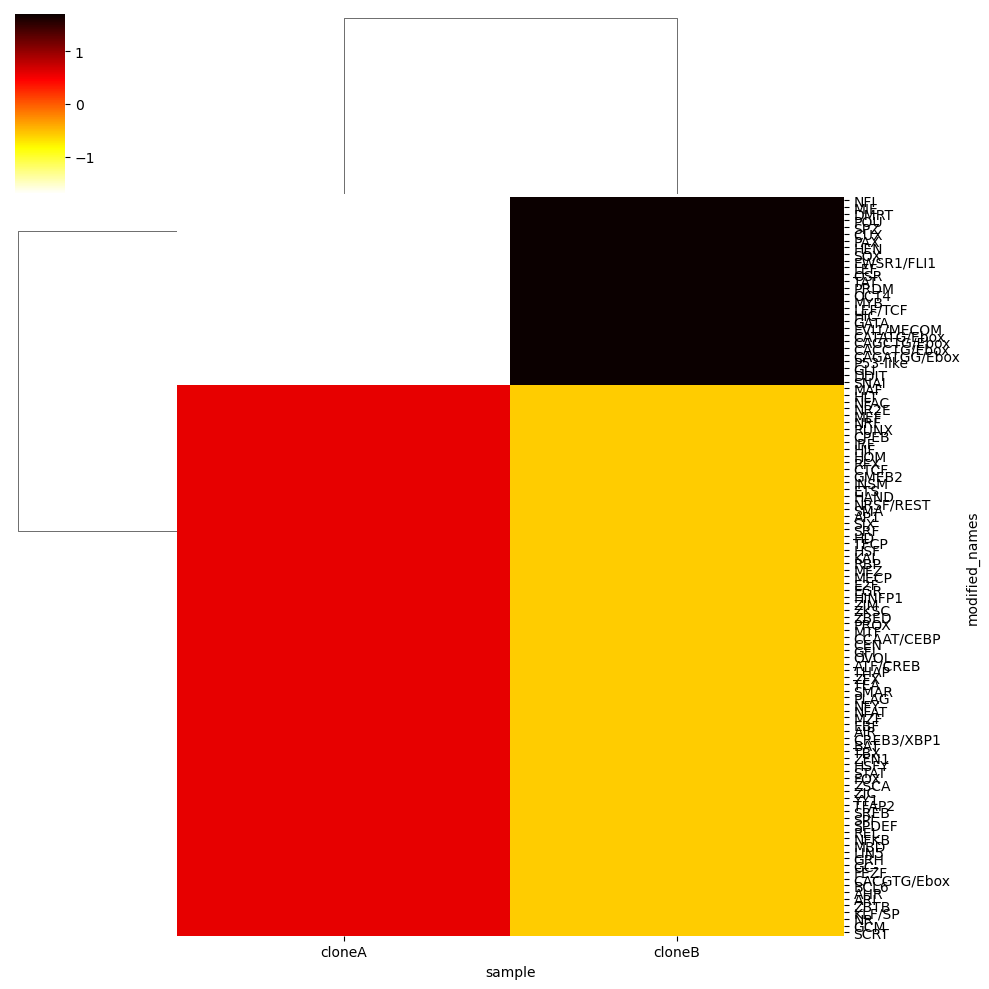

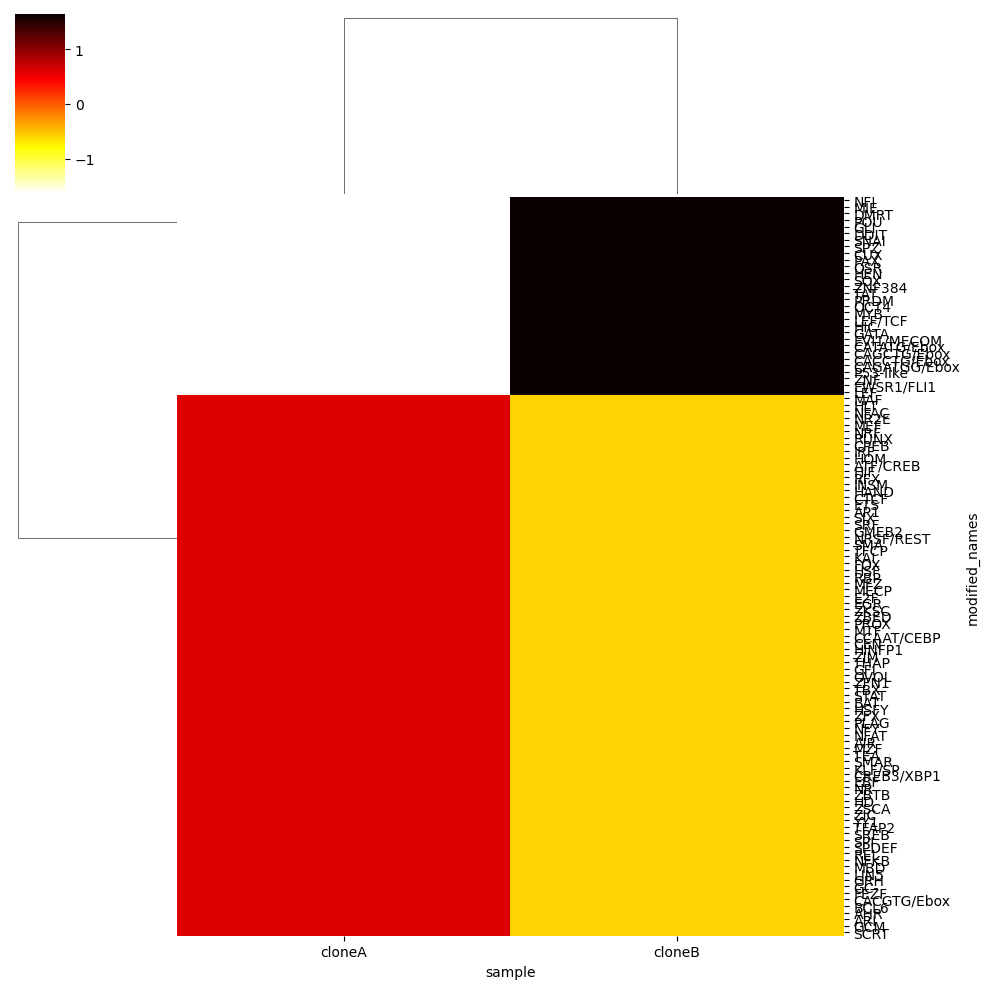

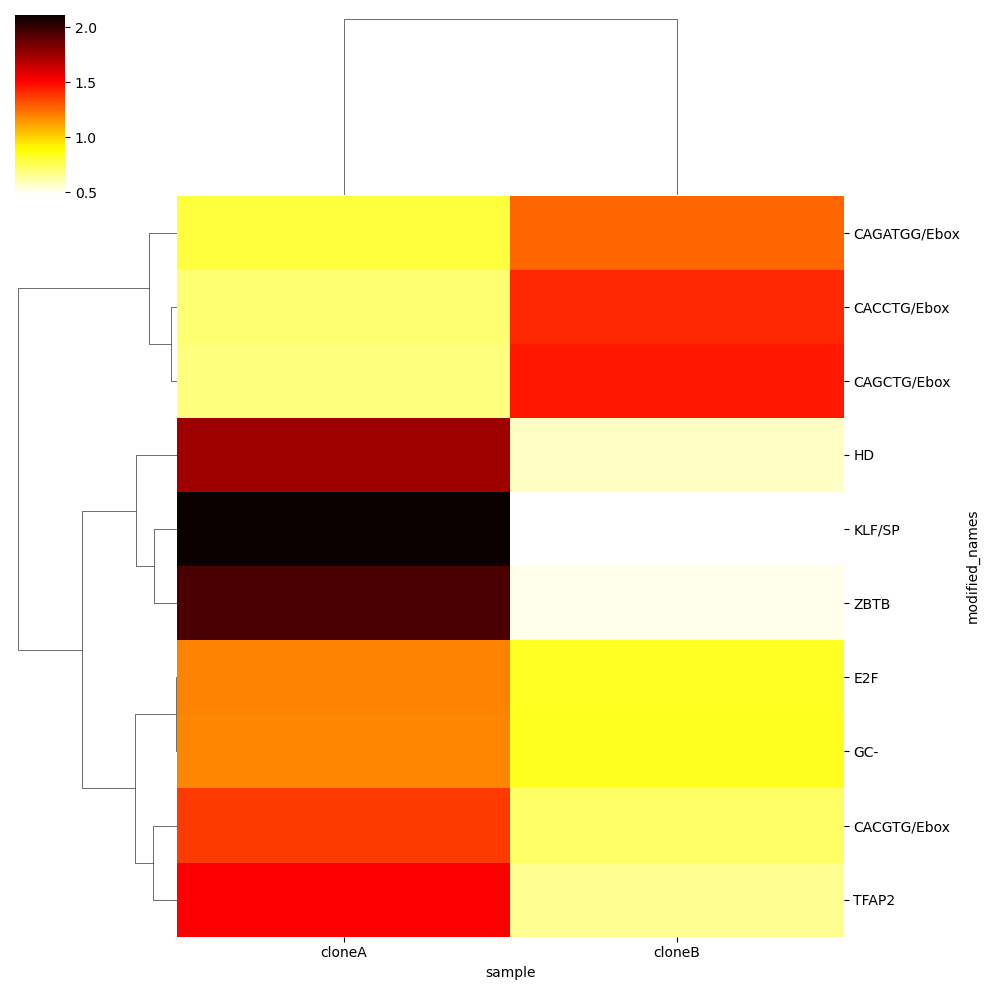

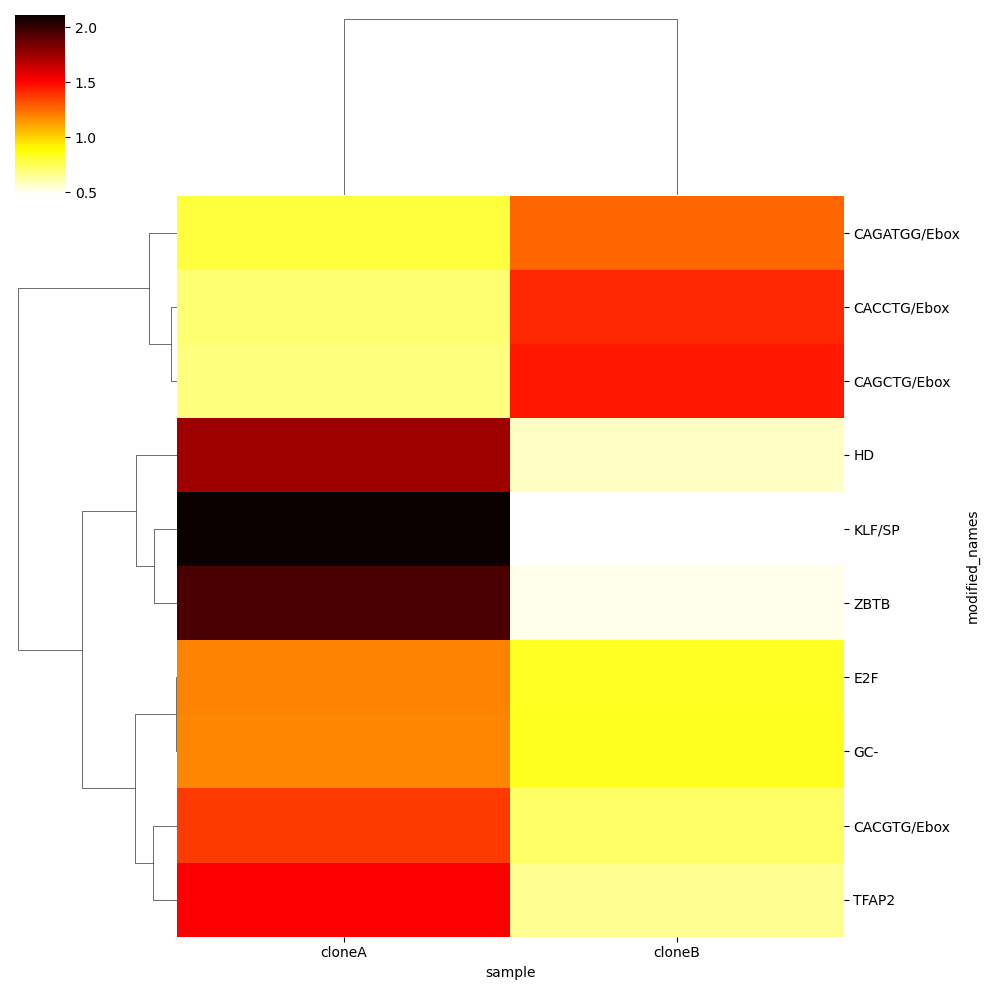

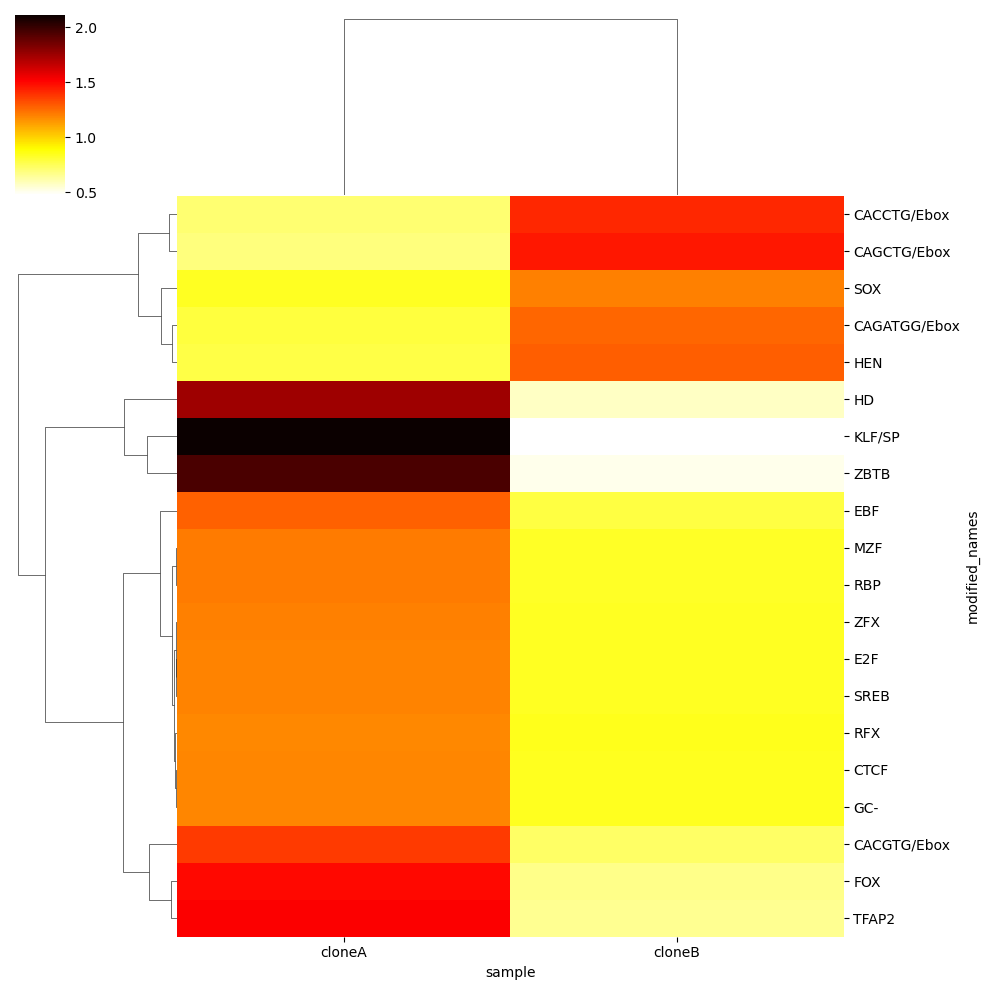

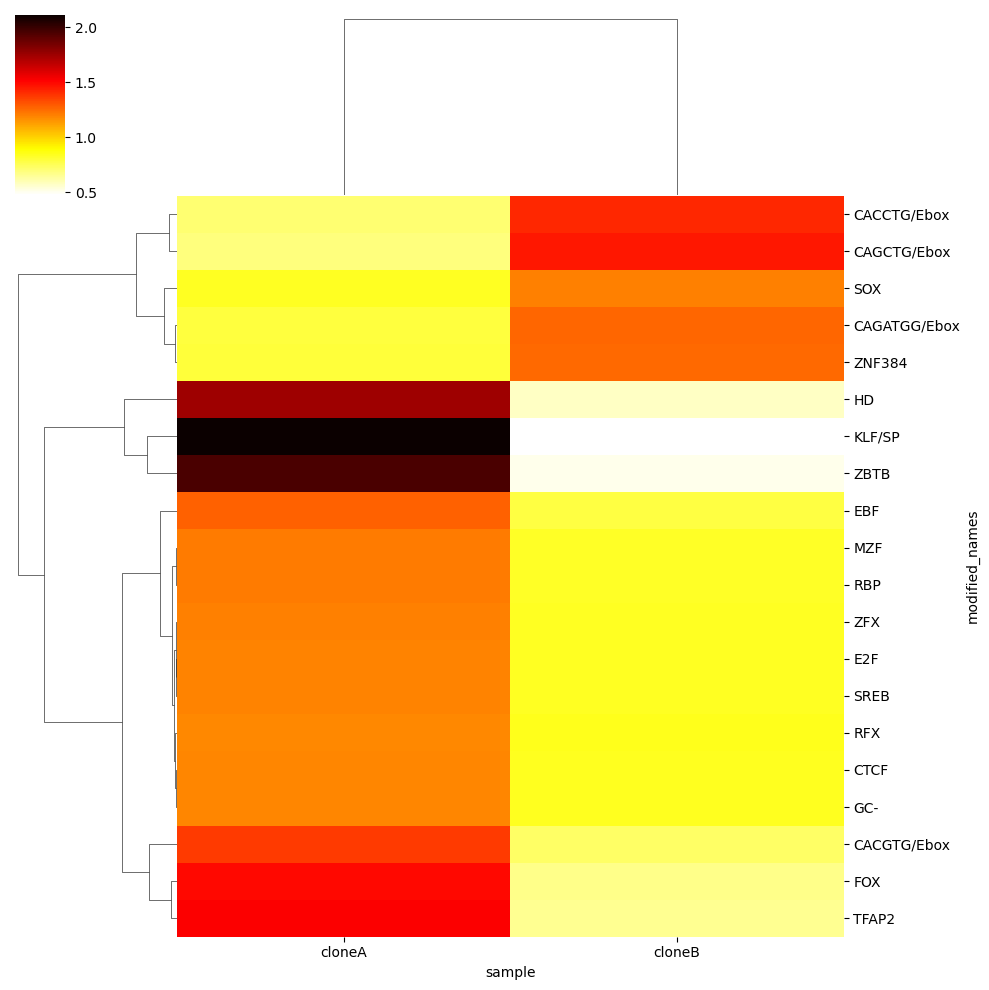

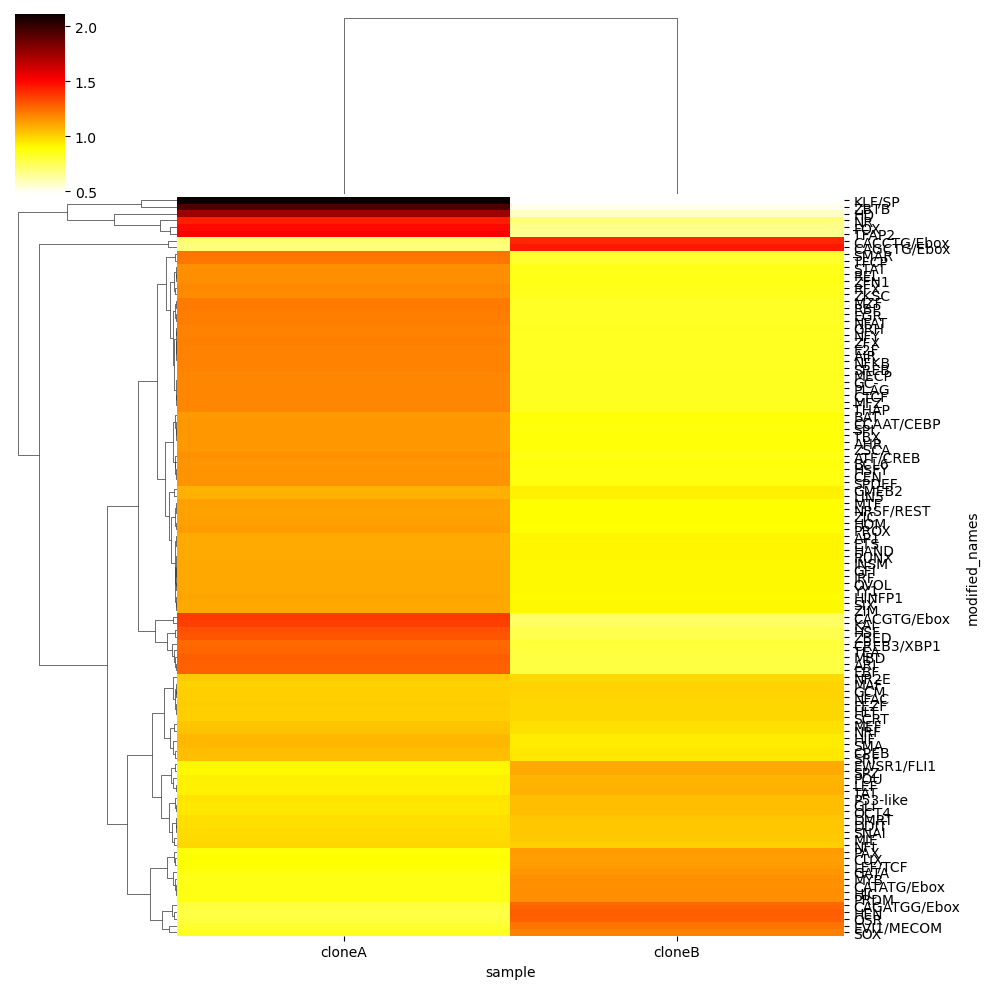

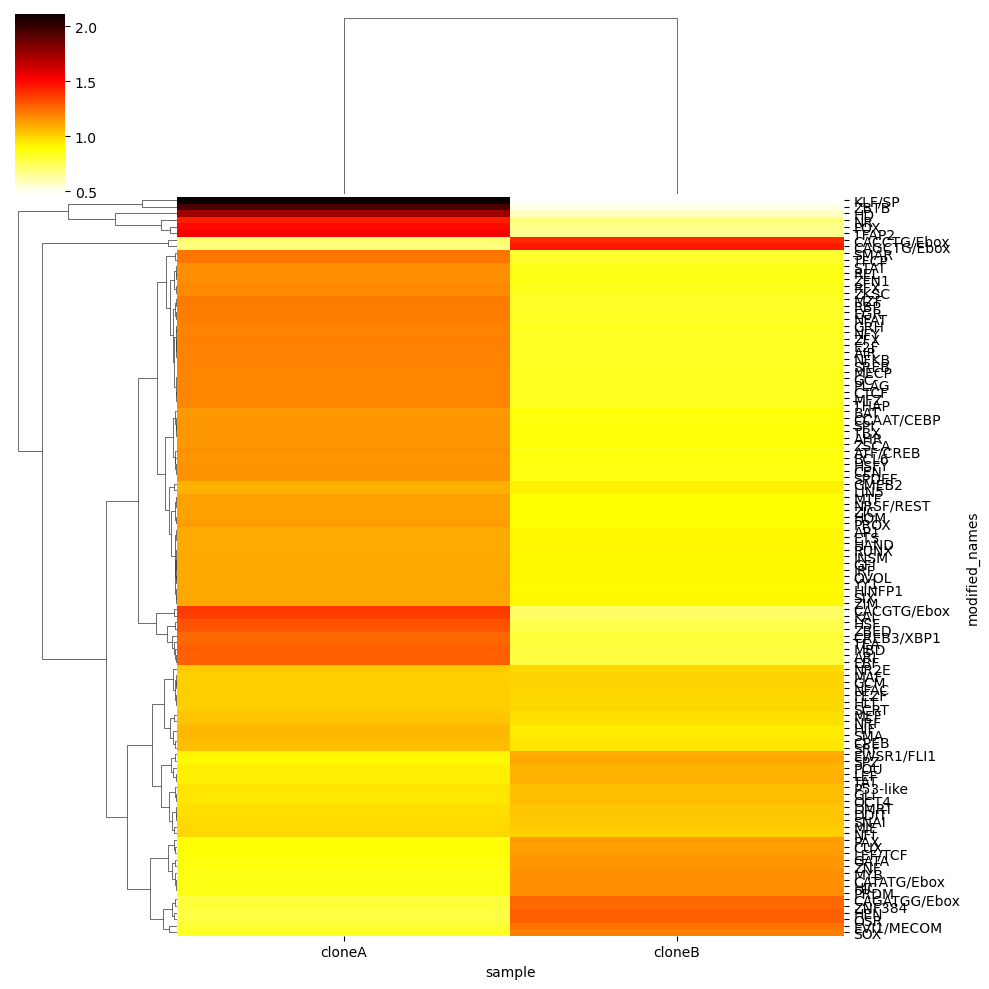

In [82]:
####################################################
# args
####################################################
suffix = 'clstrmp_mtfcmp_gbm45AvB'
grid ={'zscore': ['row', 'col', 'rowcol', None, ],
       'topn': [10, 20, None],
       'drop': ['ZNF', None]}
####################################################

dt = datetime.datetime.now().strftime('%y%m%d')
pfp = os.path.join('/home/nravindra/project/reg_diffs/results/tmp/', dt)
if not os.path.exists(pfp):
    os.makedirs(pfp)

count = 0
for zscore_type in grid['zscore']:
    for n in grid['topn']:
        for drop_motif in grid['drop']:
            print(count, '{}_{}_{}'.format(zscore_type, n, drop_motif))
            agg, p, dt = mtfcmp.viz_compare_enrich(
                enrich_out, 
                name_key=name_key, 
                drop_duplicates_key='modified_names', 
                names2display=None,
                topn=n,
                drop=drop_motif,
                zscore=zscore_type,
                save_plot=None if not export else os.path.join(pfp, '{}_z{}_top{}_drop{}.pdf'.format(suffix, zscore_type, n, drop_motif)),
                save_mat=None if not export else '/illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/{}_z{}_top{}_drop{}.csv'.format(suffix, zscore_type, n, drop_motif),
                return_plot_obj=True,
            )
            if export:
                dt['df_prez'].to_csv('/illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/{}_z{}_top{}_drop{}_preZ.csv'.format(suffix, zscore_type, n, drop_motif))
                print('  wrote {}'.format('/illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/{}_z{}_top{}_drop{}_preZ.csv'.format(suffix, zscore_type, n, drop_motif)))
            count+=1


# restrict to sub-seq

## chr 6



In [84]:
gbm_39_chr6 = {'cloneA': gbm39['cloneA'].loc[gbm39['cloneA']['seqnames']=='chr6'],
               'cloneB': gbm39['cloneB'].loc[gbm39['cloneB']['seqnames']=='chr6']}
gbm_45_chr6 = {'cloneA': gbm45['cloneA'].loc[gbm45['cloneA']['seqnames']=='chr6'],
               'cloneB': gbm45['cloneB'].loc[gbm45['cloneB']['seqnames']=='chr6']}

### gbm 39

In [85]:
# modify dataframe, then plot
# run tst
enrich_out = evalism.chi2ovr(
        data=gbm_39_chr6,
        groups=None,
        notB_key='end_cnt_before', 
        B_key='end_cnt_after',
        return_df=True,
        verbose=True,
        name_key=name_key,
        )

data merged into one df in 0-s
through cloneA. time elapsed: 0-s
through cloneB. time elapsed: 0-s
n_tst: 224


0 row_10_ZNF
  wrote /illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/clstrmp_mtfcmp_gbm39AvB_chr6_zrow_top10_dropZNF_preZ.csv
1 row_10_None
  wrote /illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/clstrmp_mtfcmp_gbm39AvB_chr6_zrow_top10_dropNone_preZ.csv
2 row_20_ZNF
  wrote /illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/clstrmp_mtfcmp_gbm39AvB_chr6_zrow_top20_dropZNF_preZ.csv
3 row_20_None
  wrote /illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/clstrmp_mtfcmp_gbm39AvB_chr6_zrow_top20_dropNone_preZ.csv
4 row_None_ZNF
  wrote /illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/clstrmp_mtfcmp_gbm39AvB_chr6_zrow_topNone_dropZNF_preZ.csv
5 row_None_None
  wrote /illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/clstrmp_mtfcmp_gbm39AvB_chr6_zrow_topNone_dropNone_preZ.csv
6 col_10_ZNF
  wrote /illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/clstrmp_mtfcmp_gbm39AvB_chr6_zcol_top10_dropZNF_p

/home/nravindra/miniconda3/envs/seq2atac/lib/python3.10/site-packages/seaborn/matrix.py:812: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(figsize=figsize)


  wrote /illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/clstrmp_mtfcmp_gbm39AvB_chr6_zNone_top20_dropZNF_preZ.csv
21 None_20_None
  wrote /illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/clstrmp_mtfcmp_gbm39AvB_chr6_zNone_top20_dropNone_preZ.csv
22 None_None_ZNF
  wrote /illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/clstrmp_mtfcmp_gbm39AvB_chr6_zNone_topNone_dropZNF_preZ.csv
23 None_None_None
  wrote /illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/clstrmp_mtfcmp_gbm39AvB_chr6_zNone_topNone_dropNone_preZ.csv


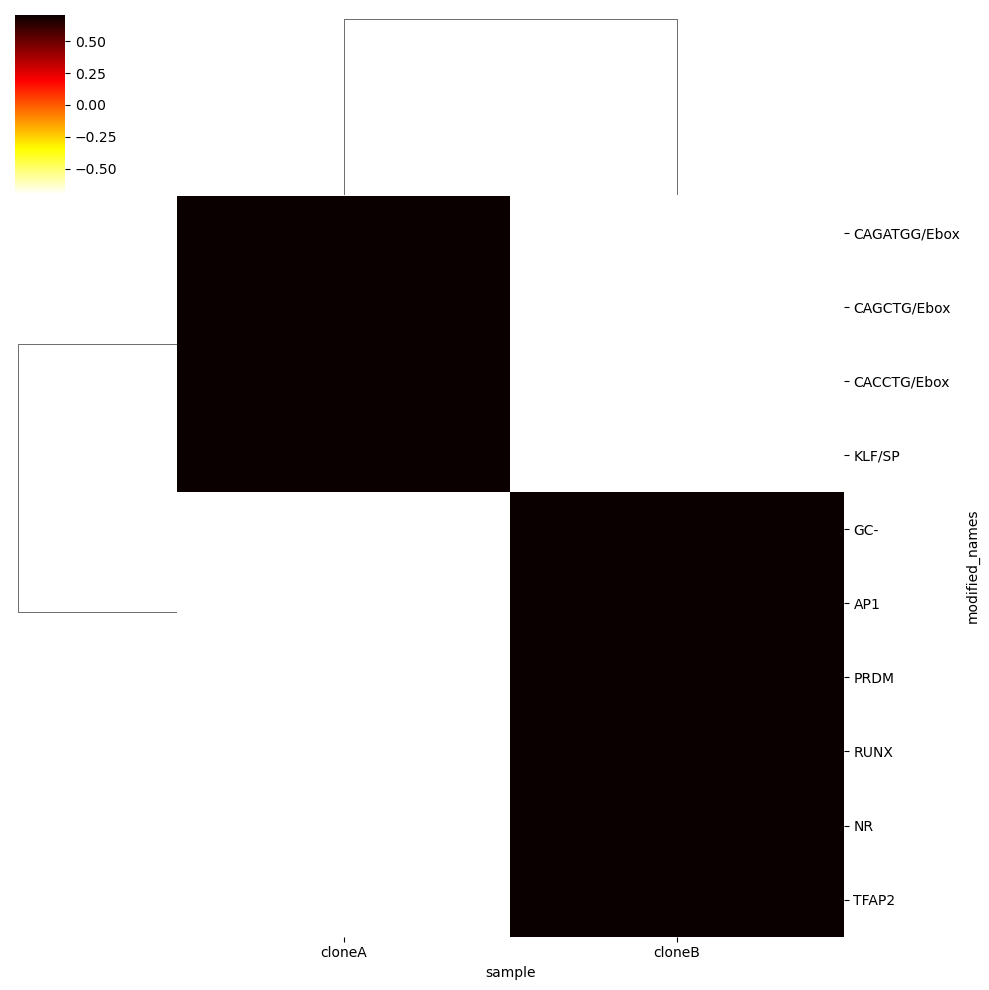

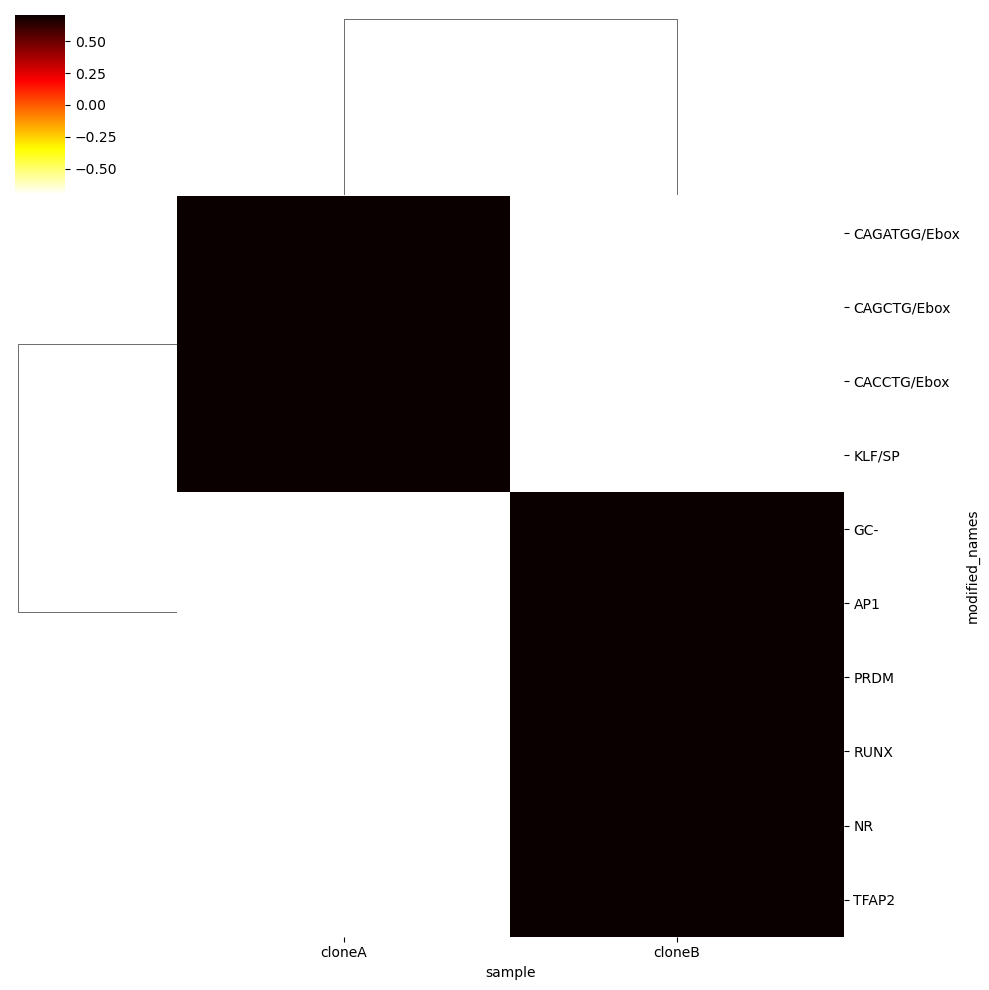

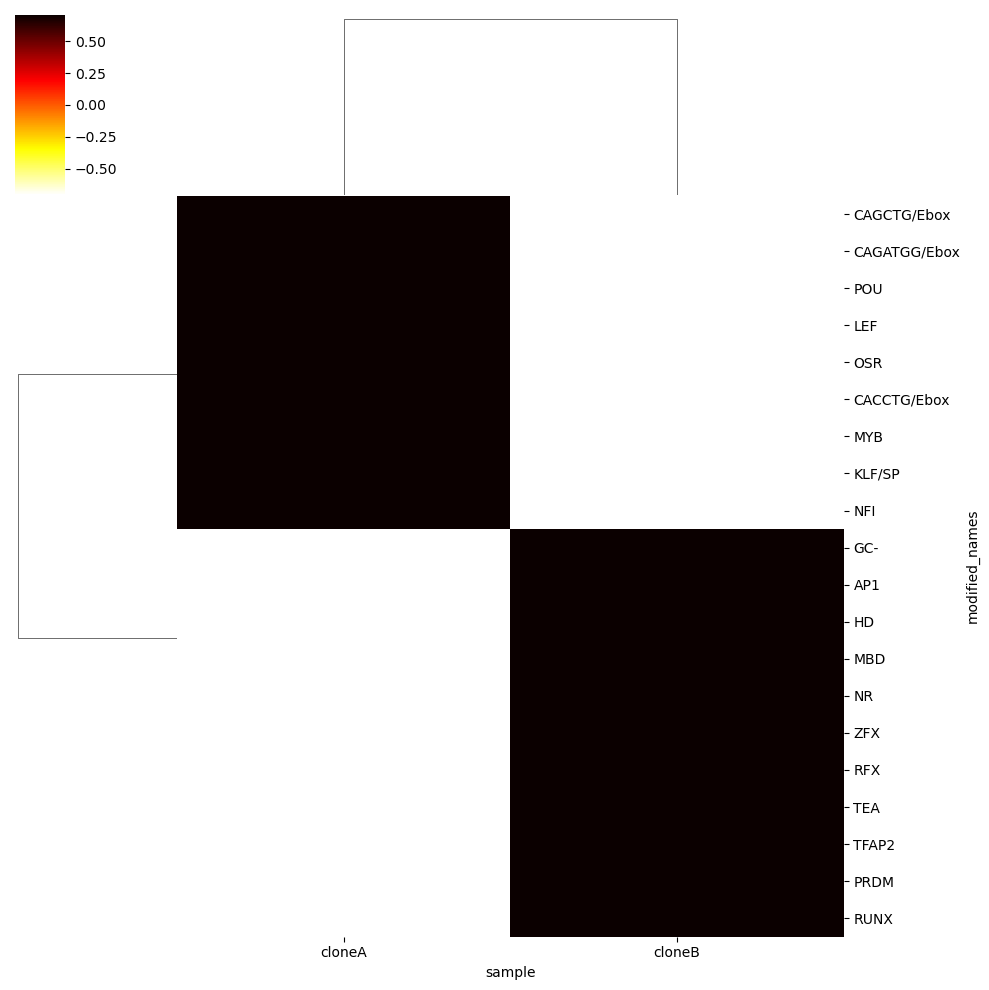

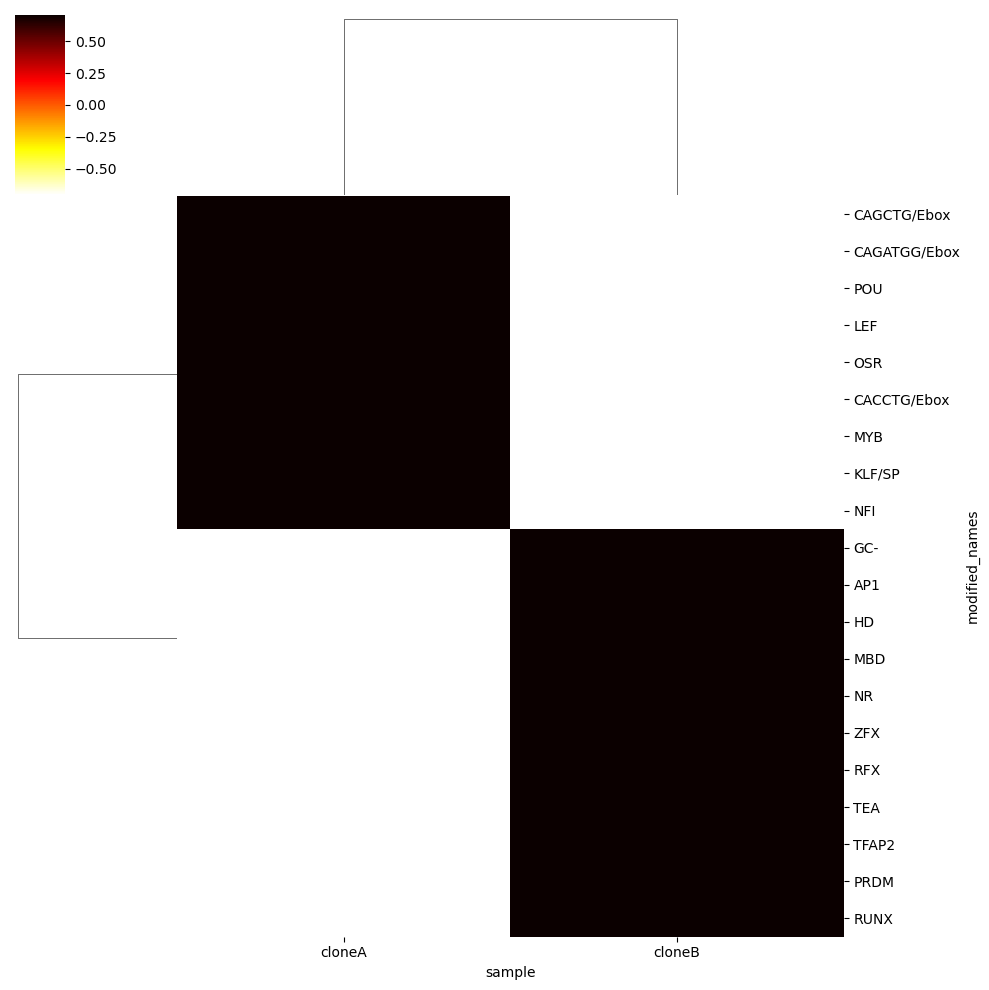

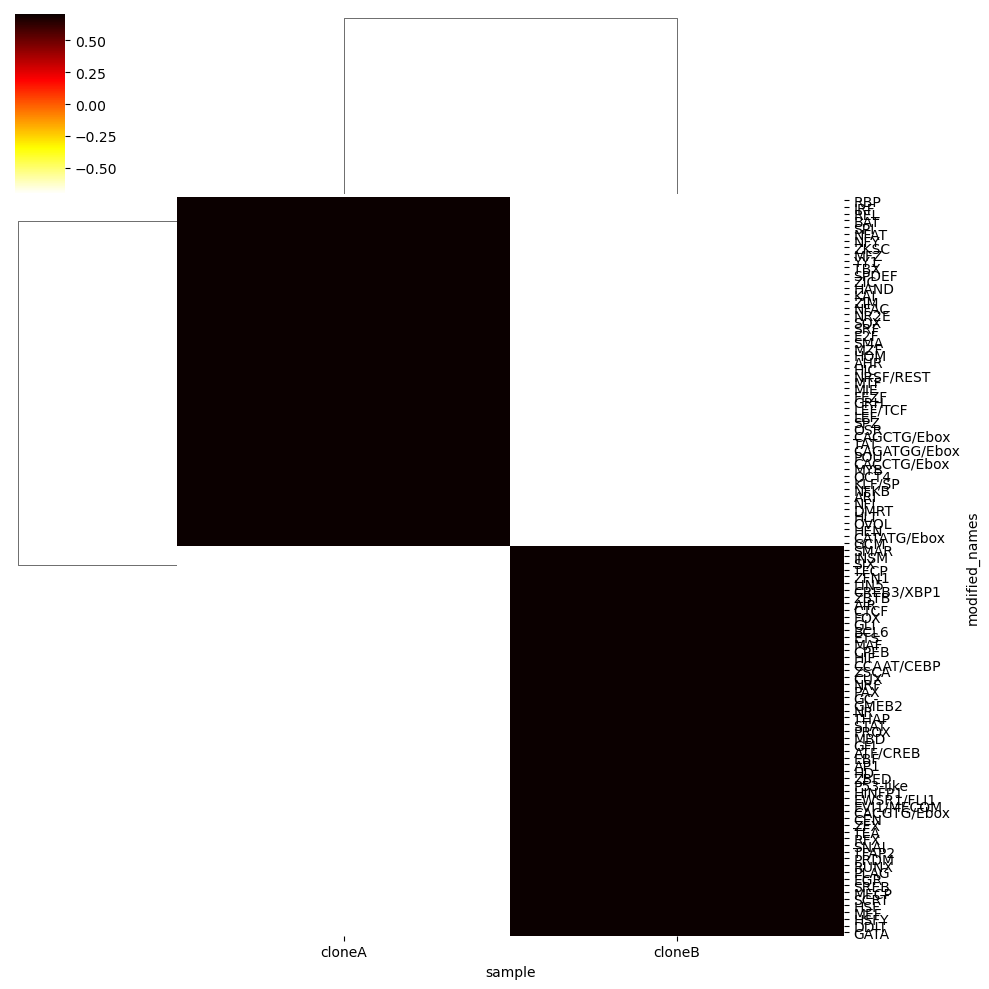

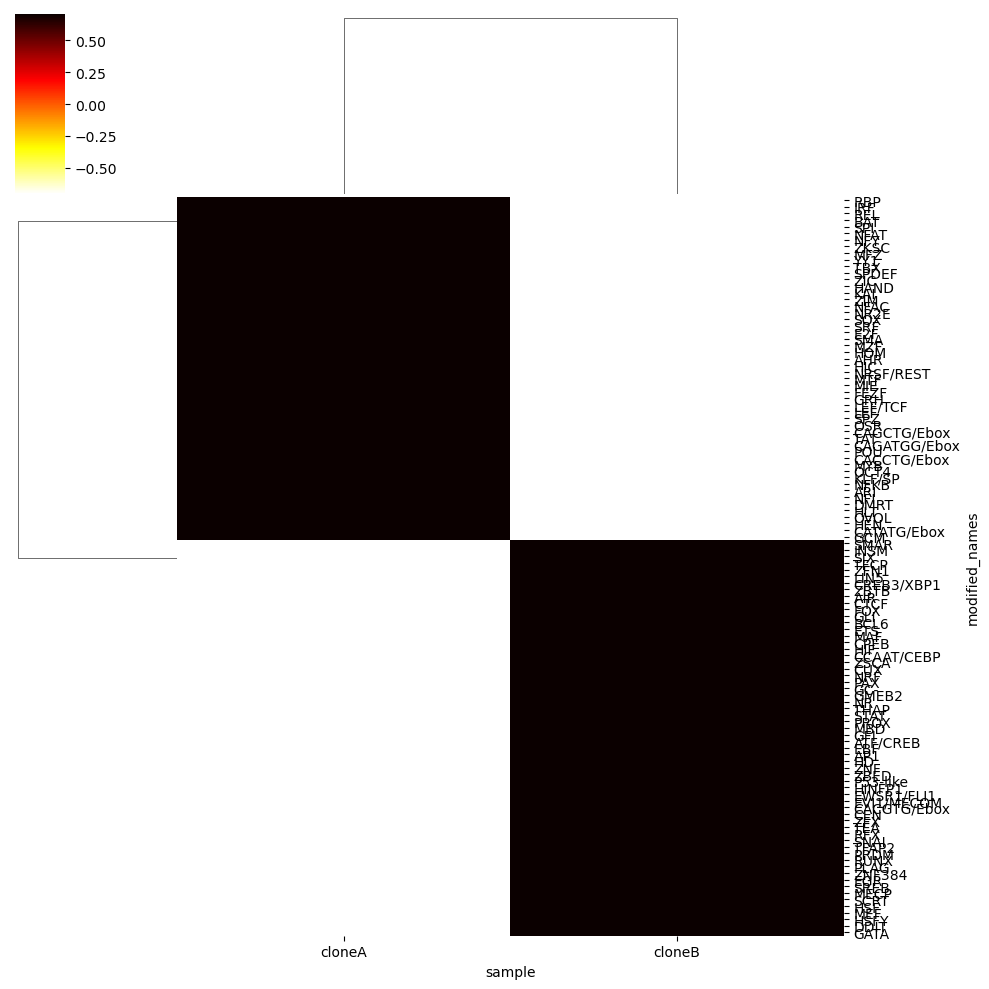

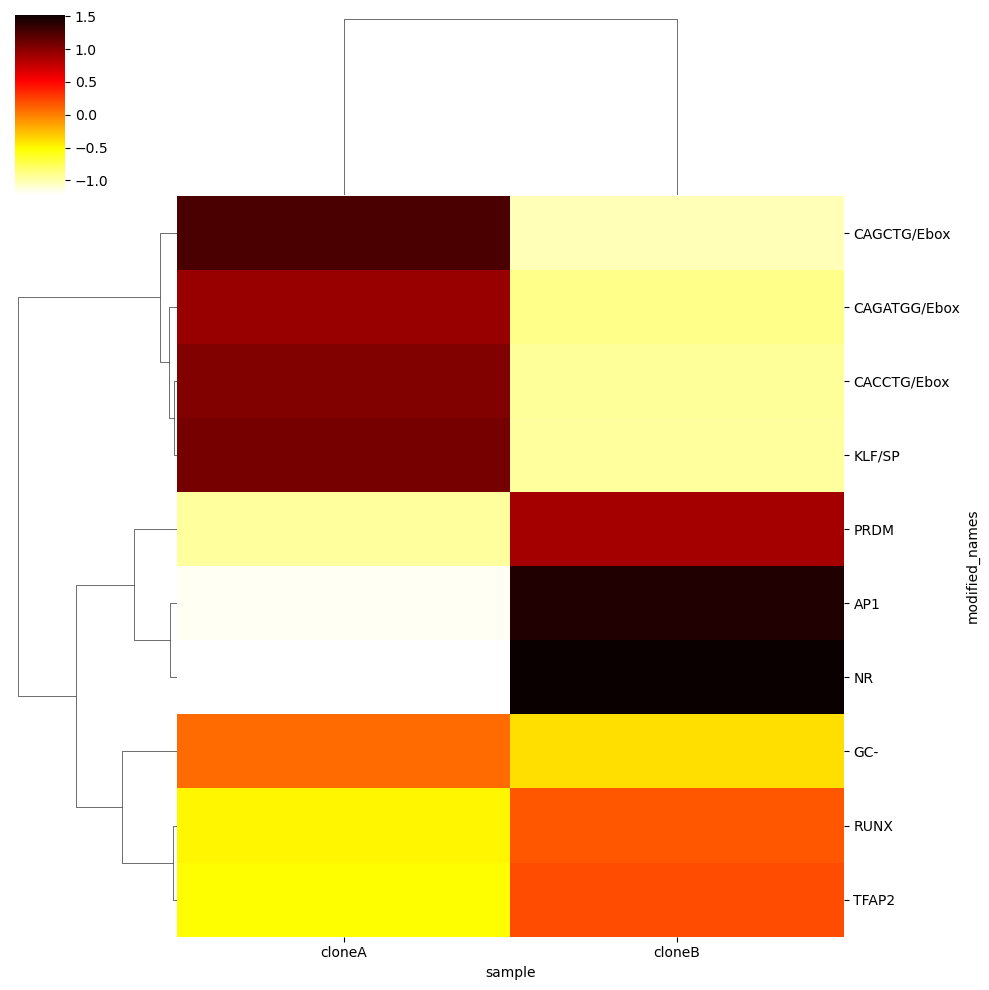

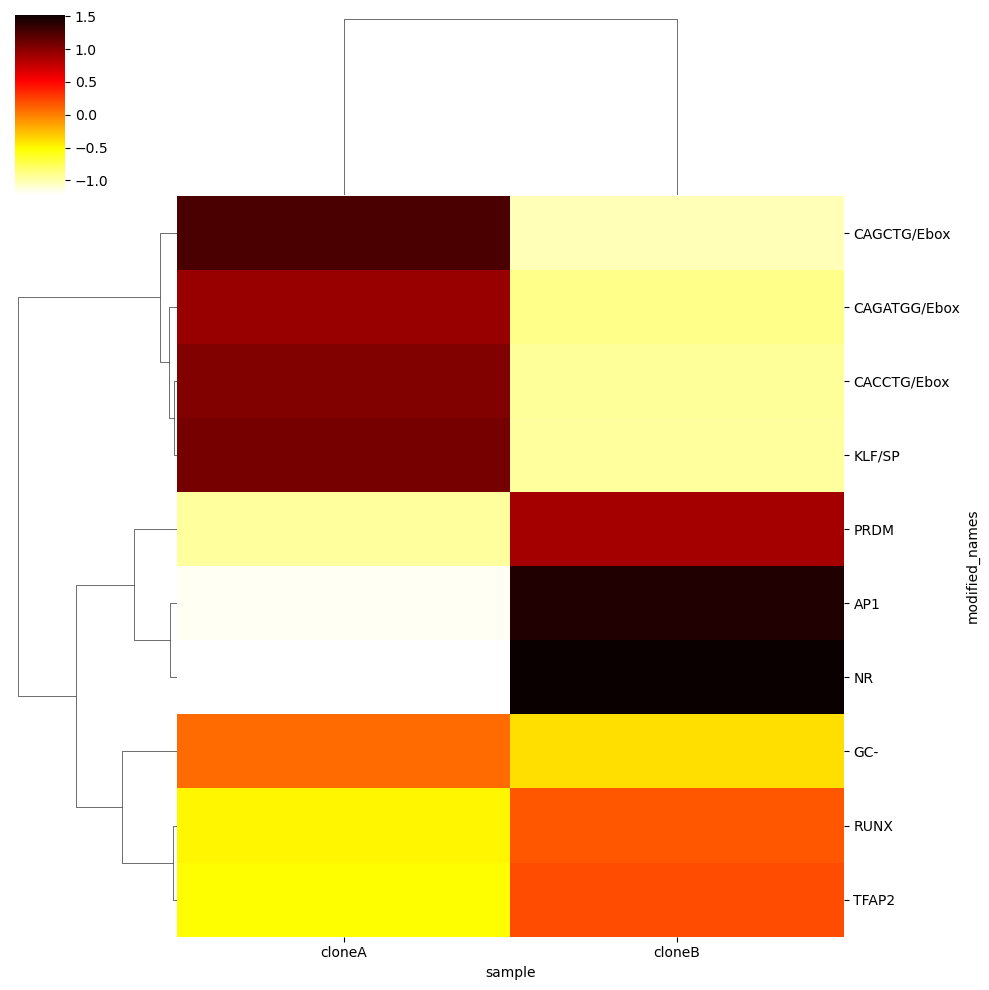

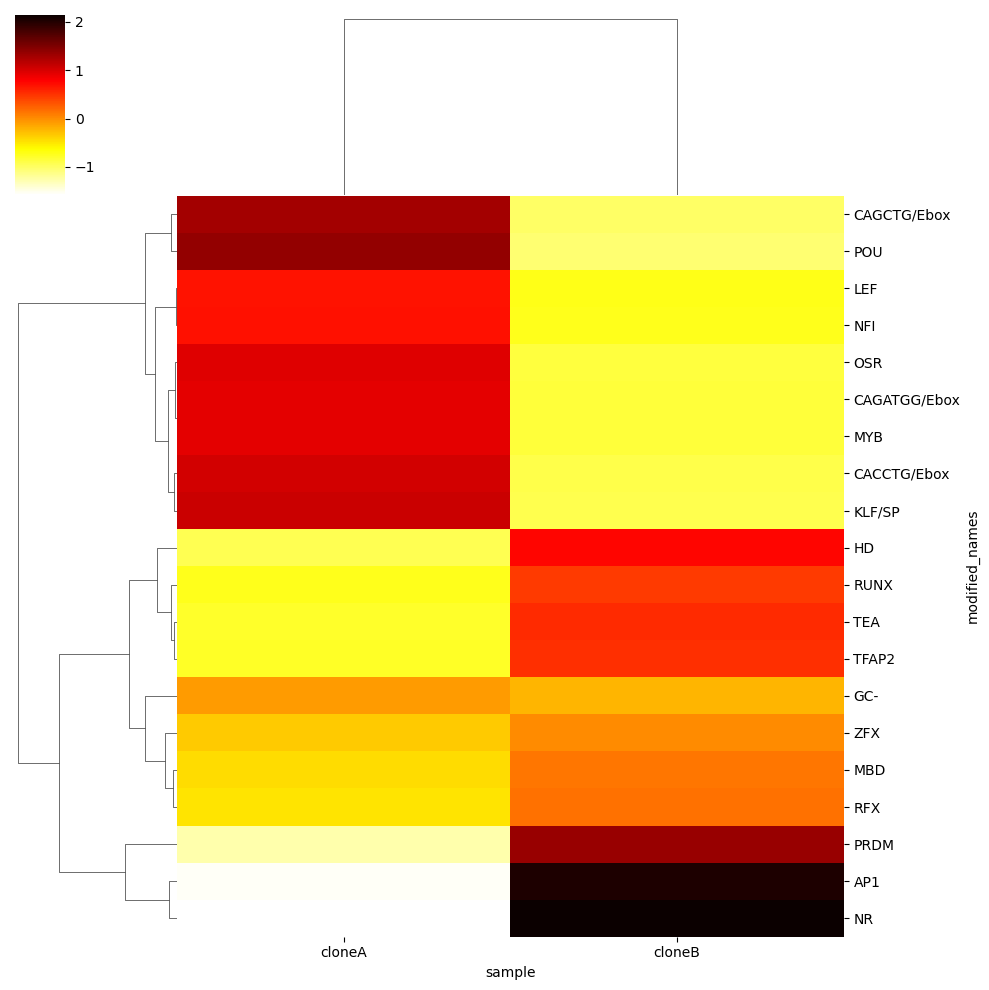

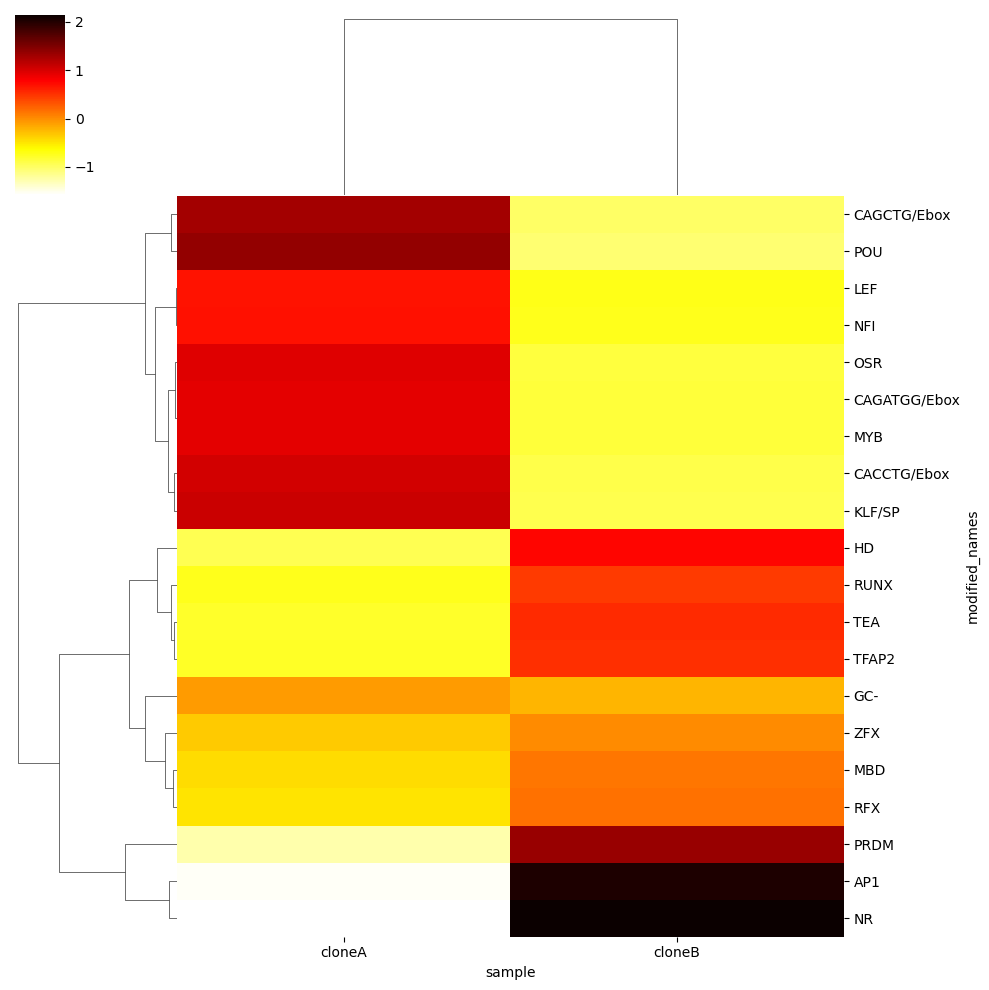

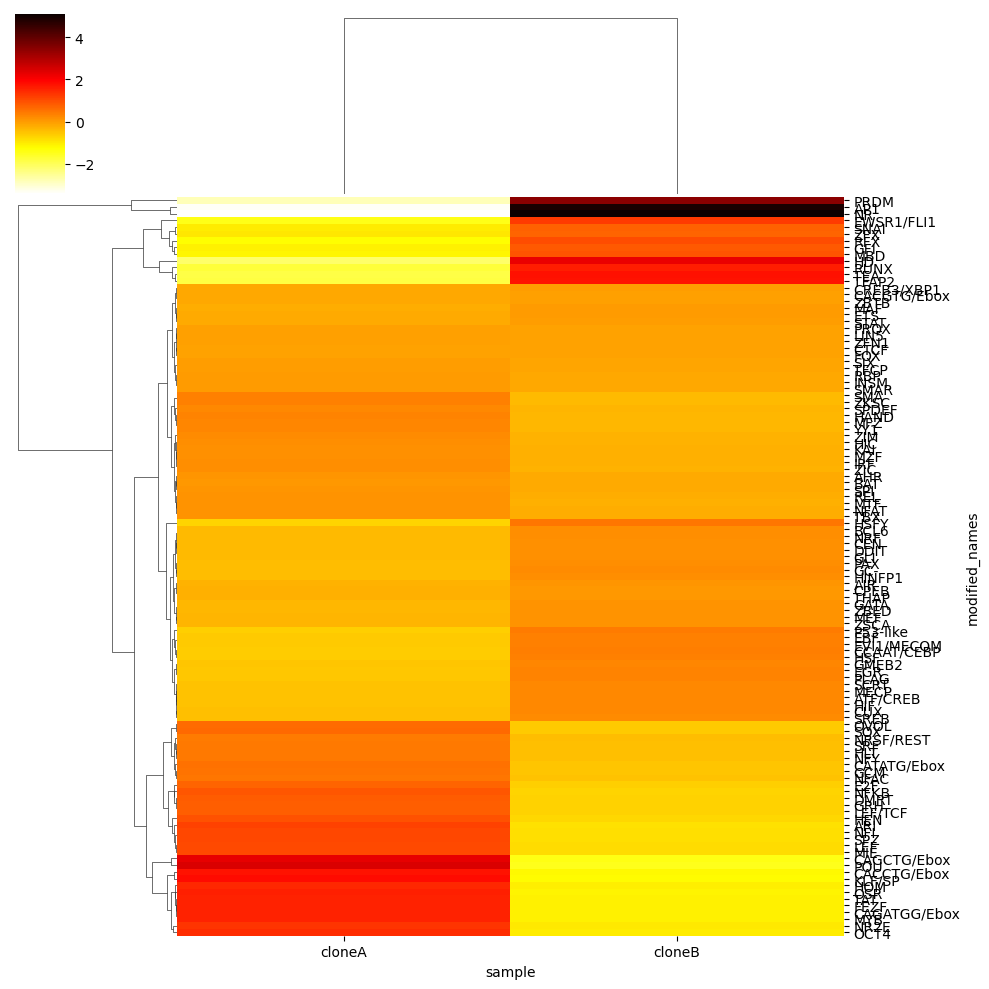

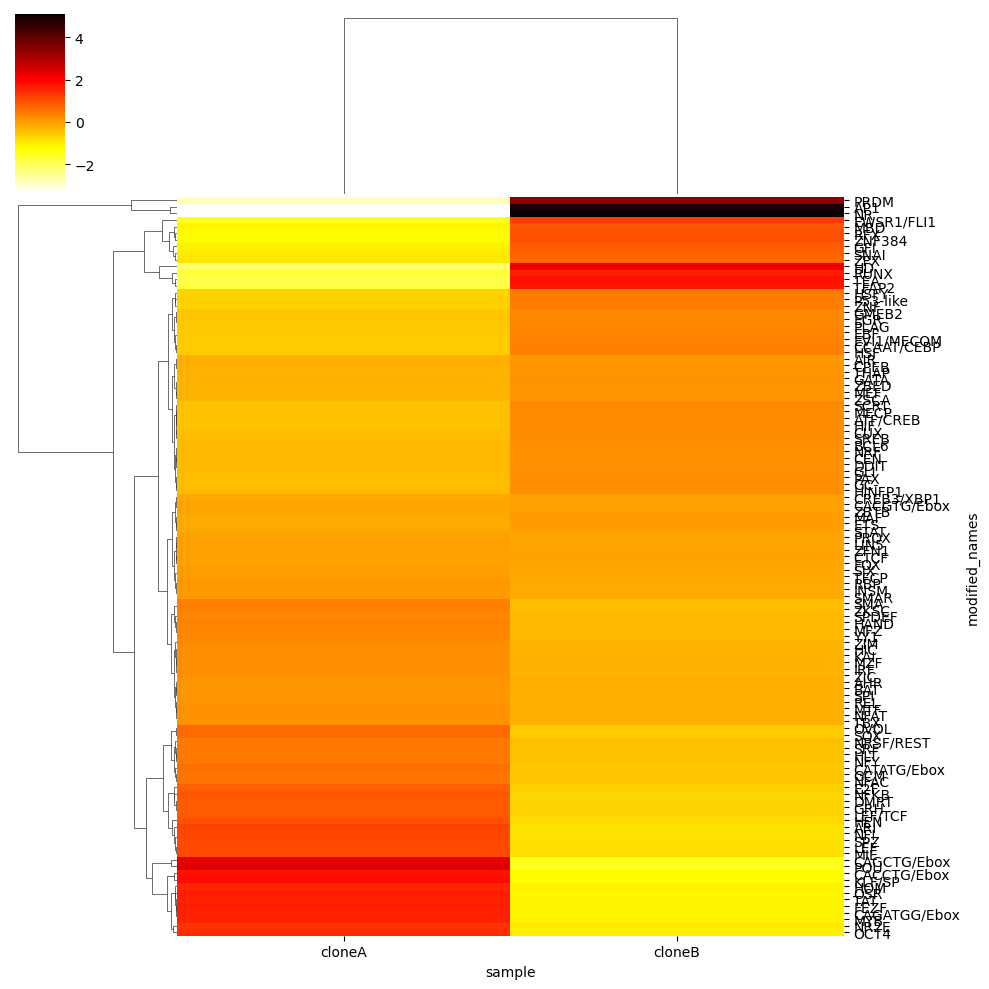

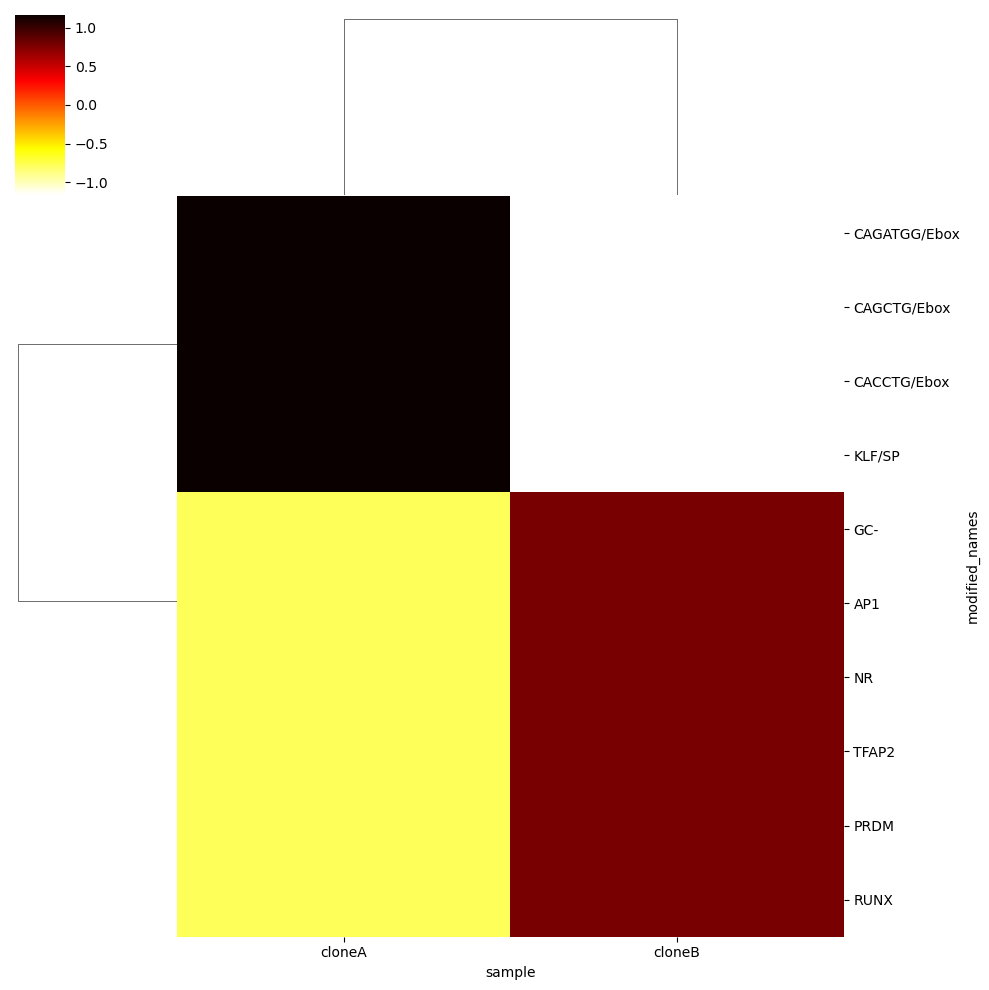

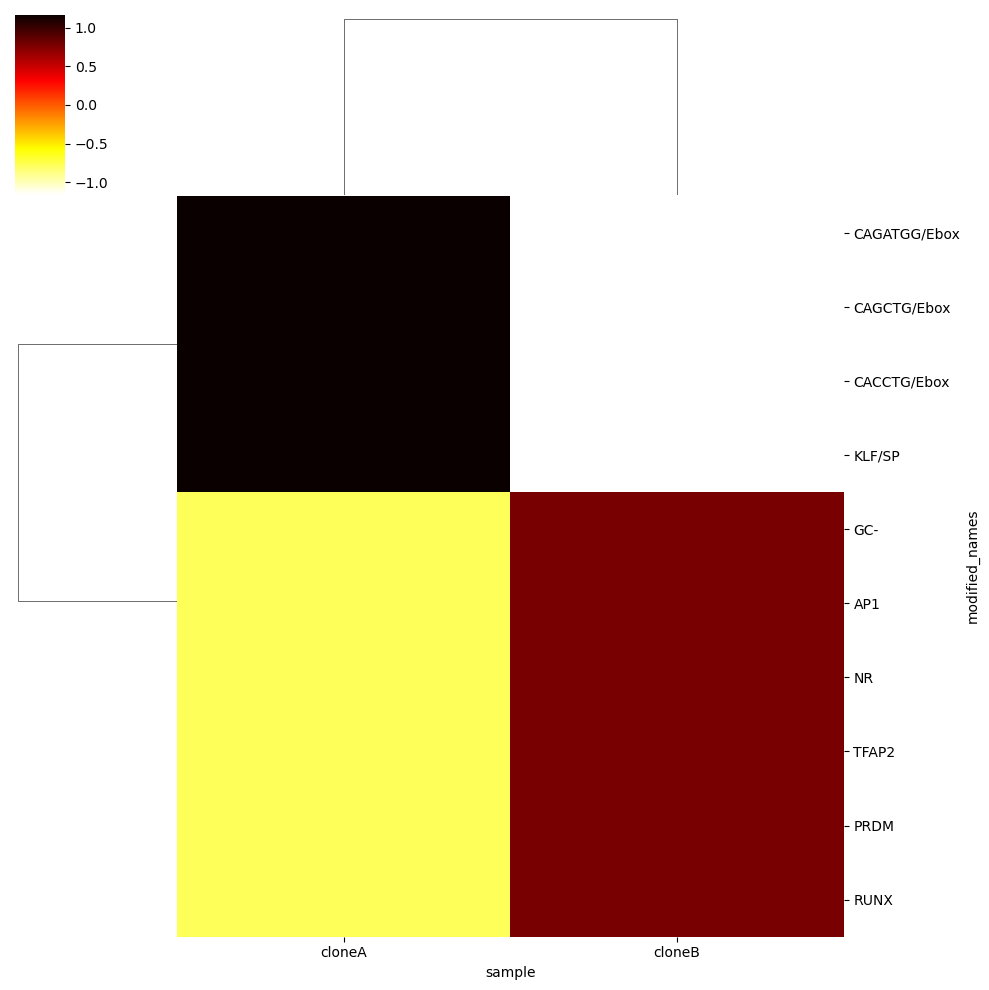

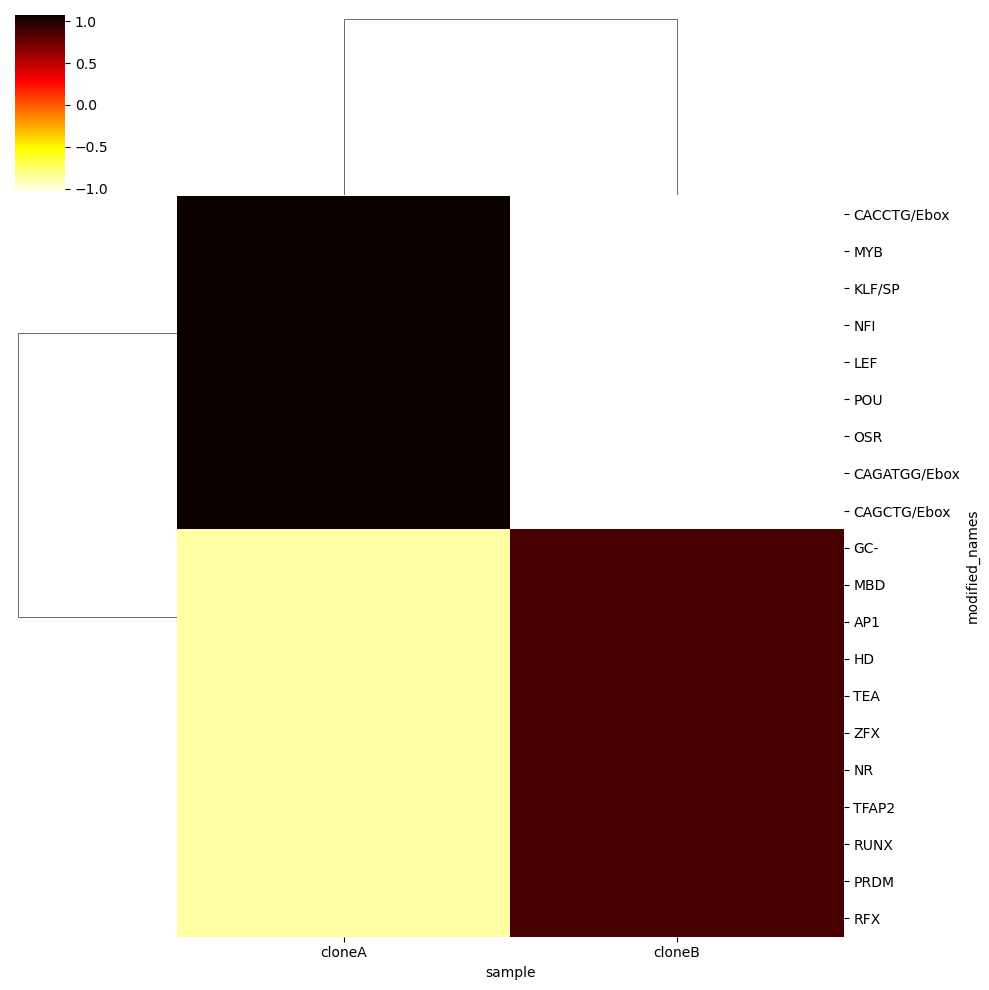

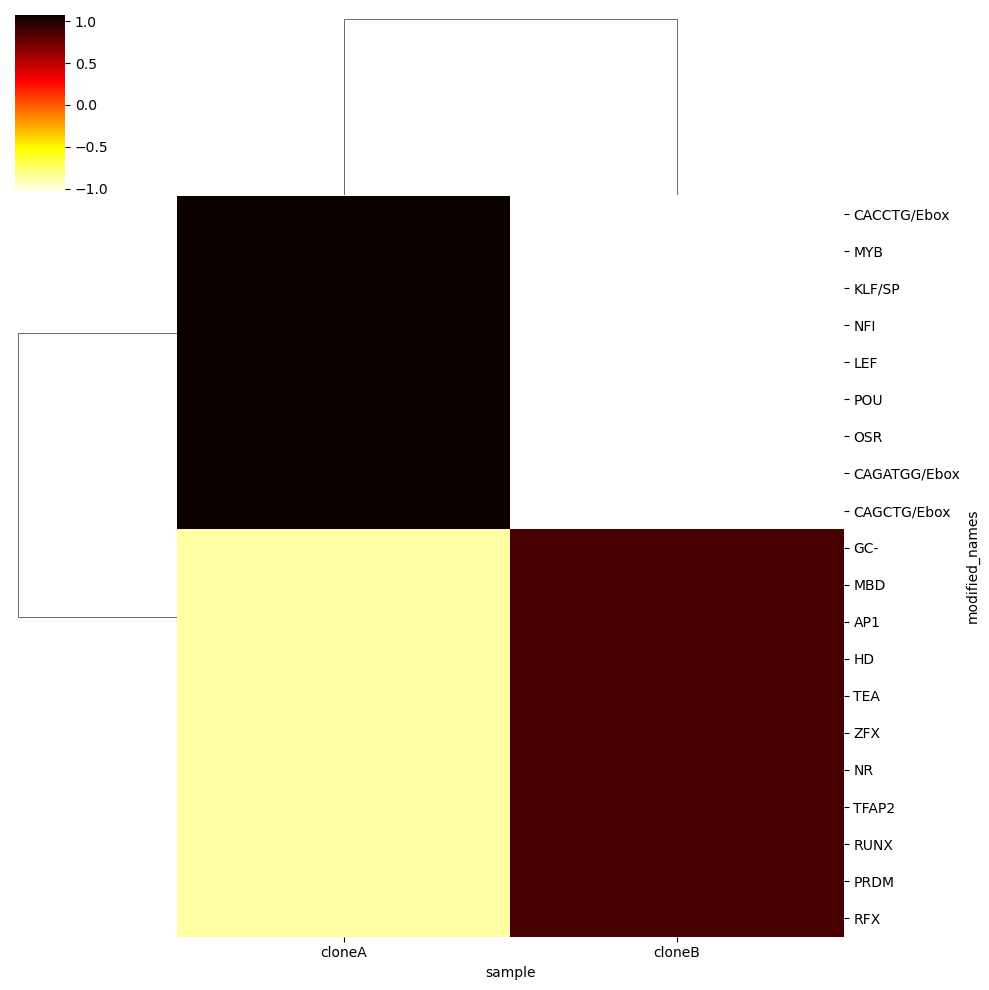

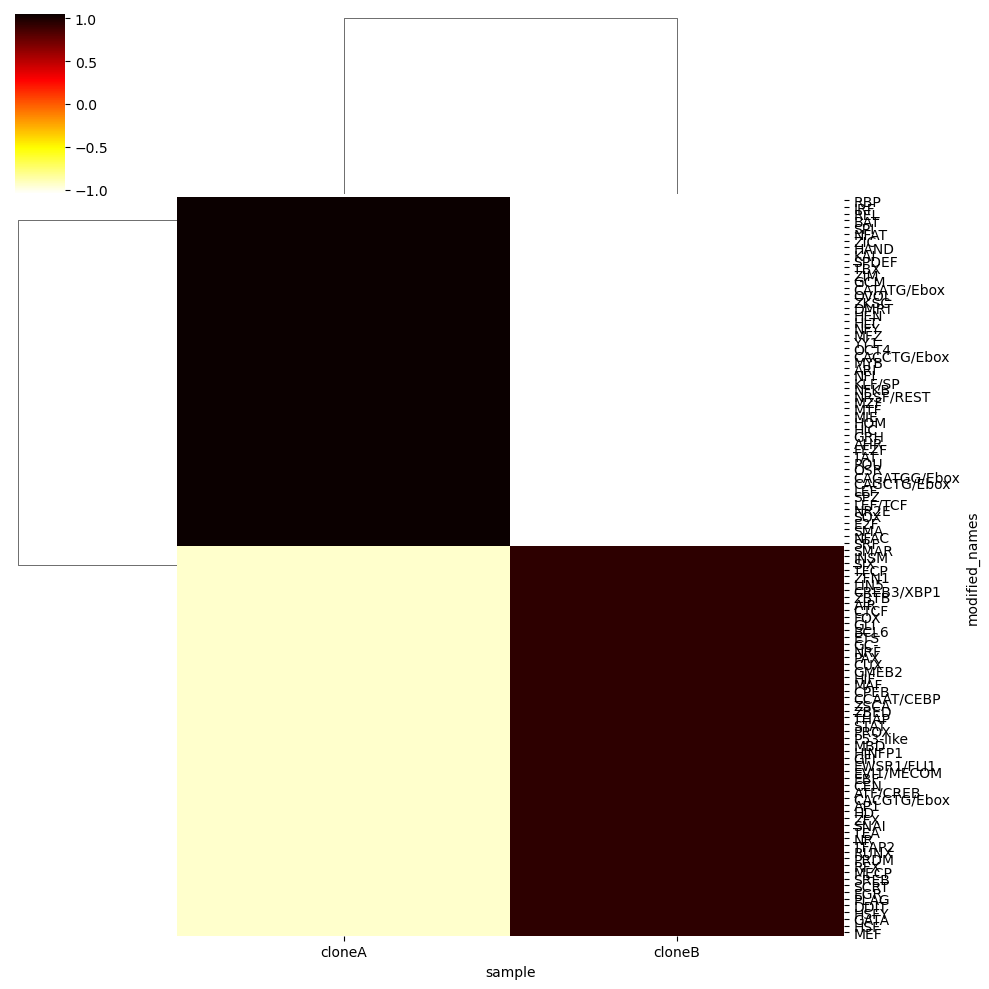

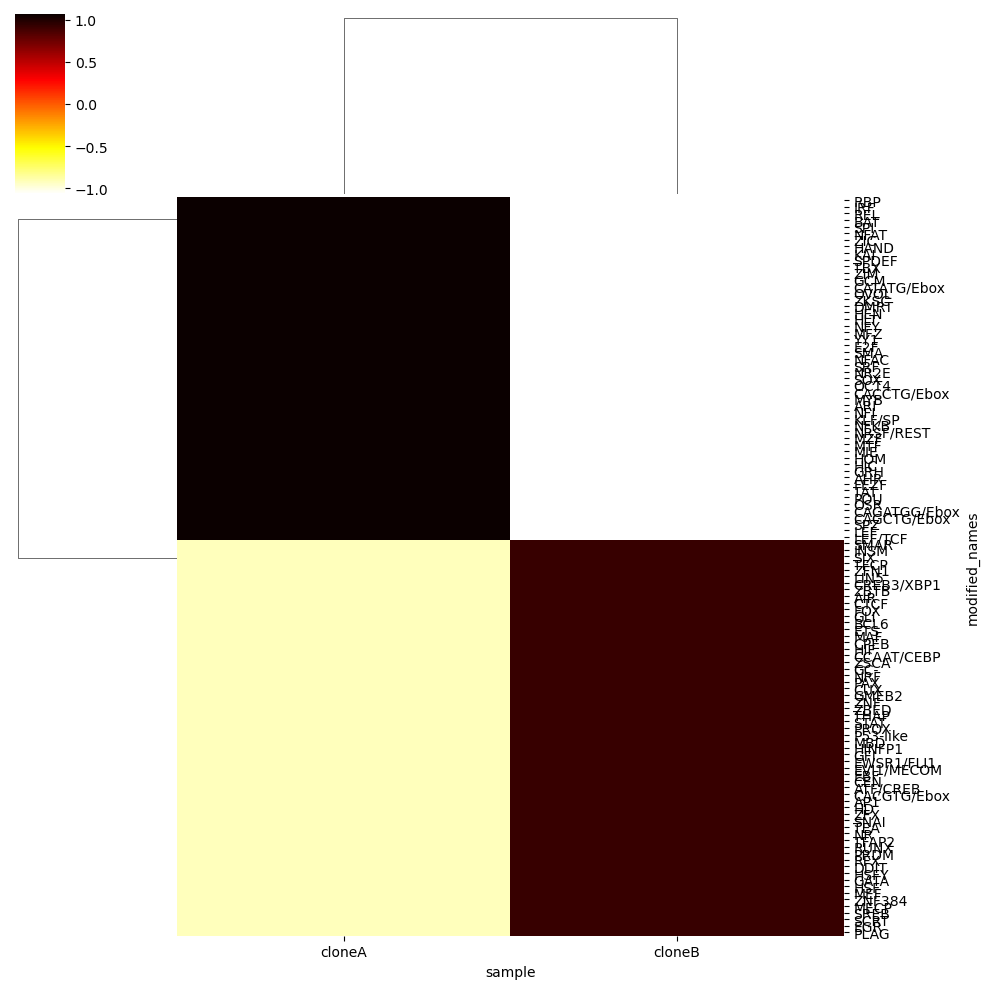

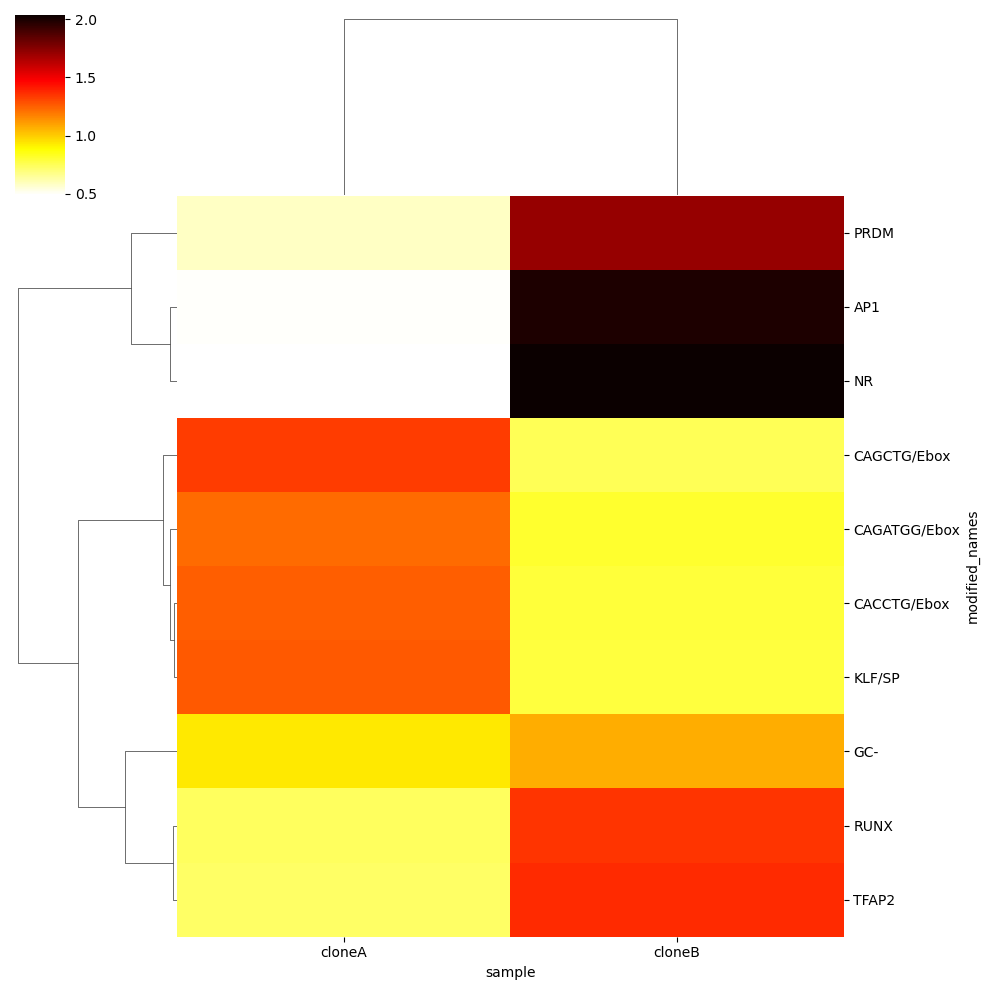

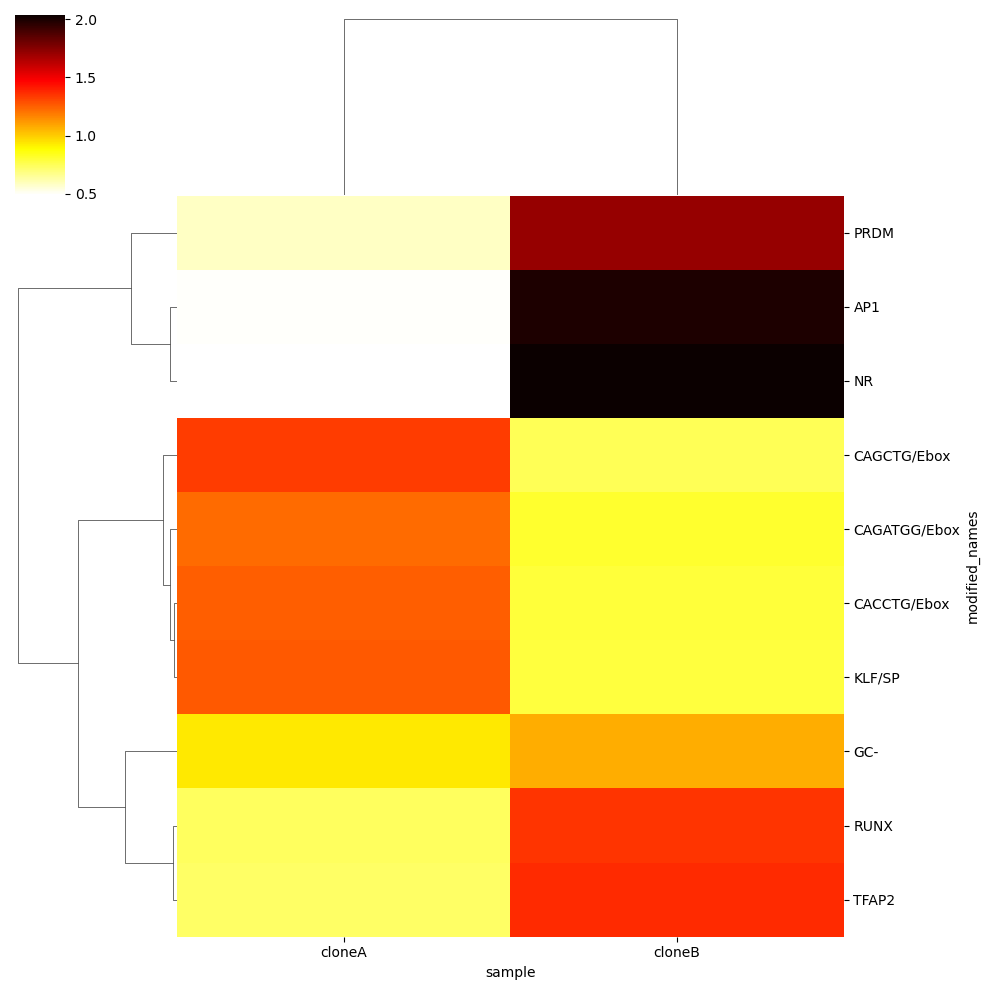

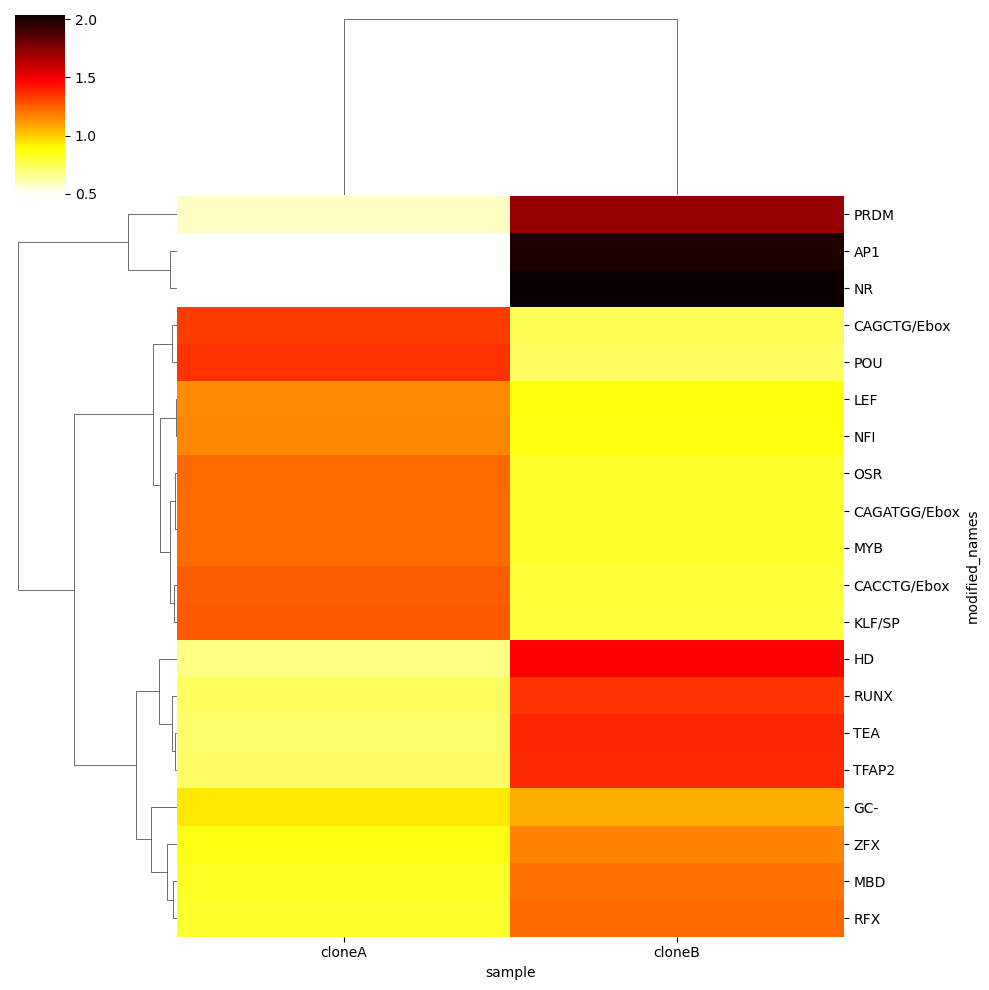

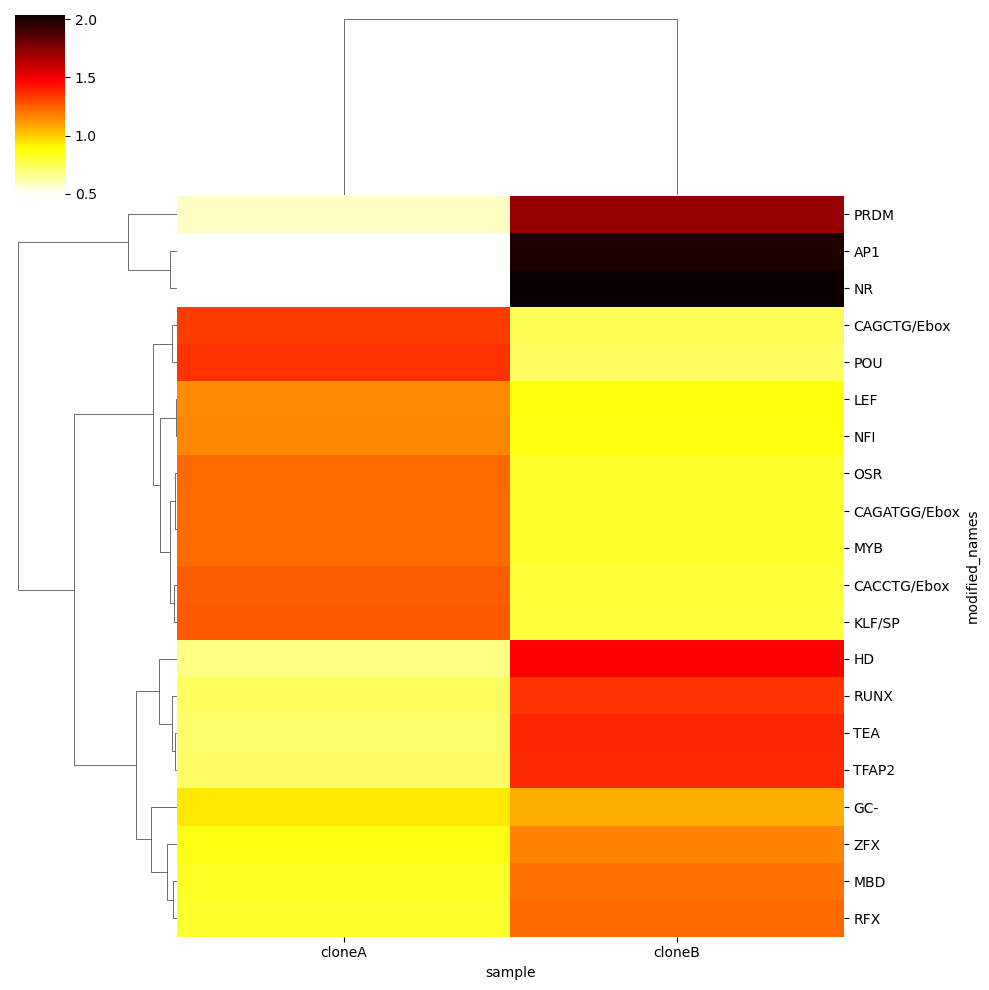

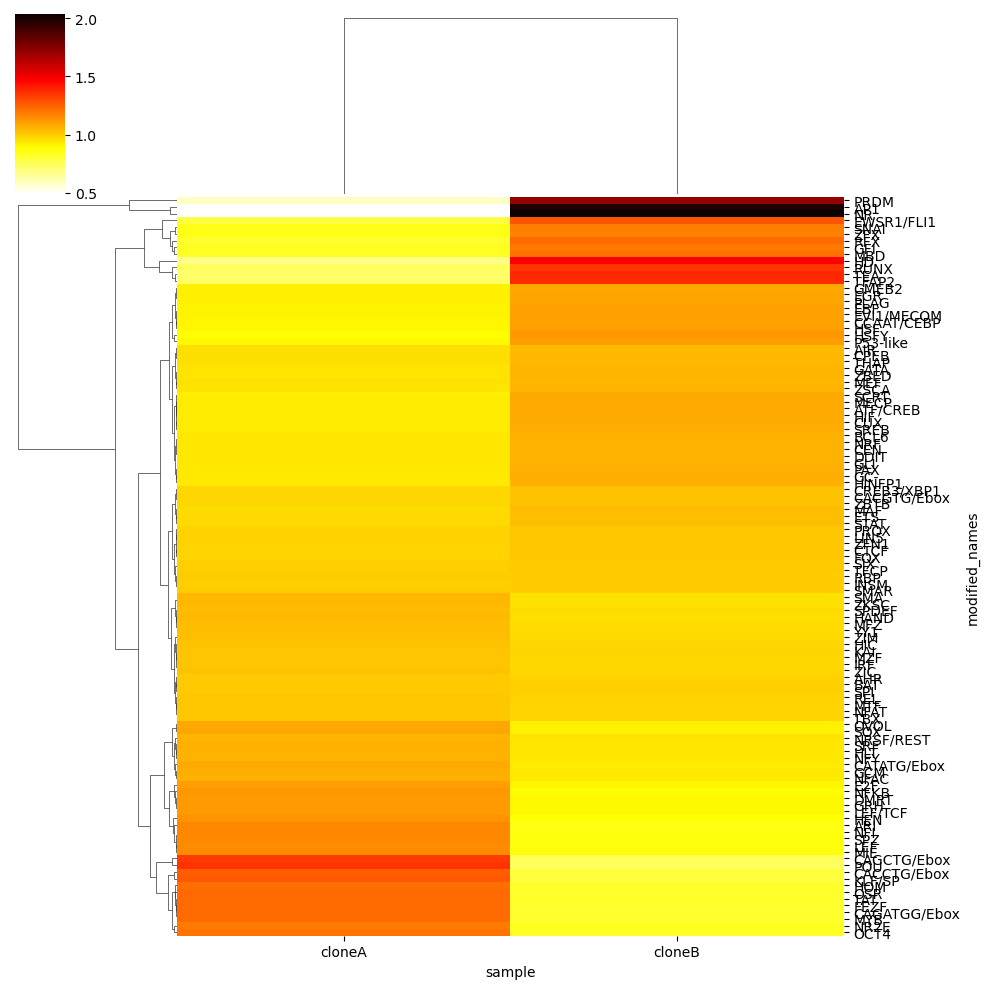

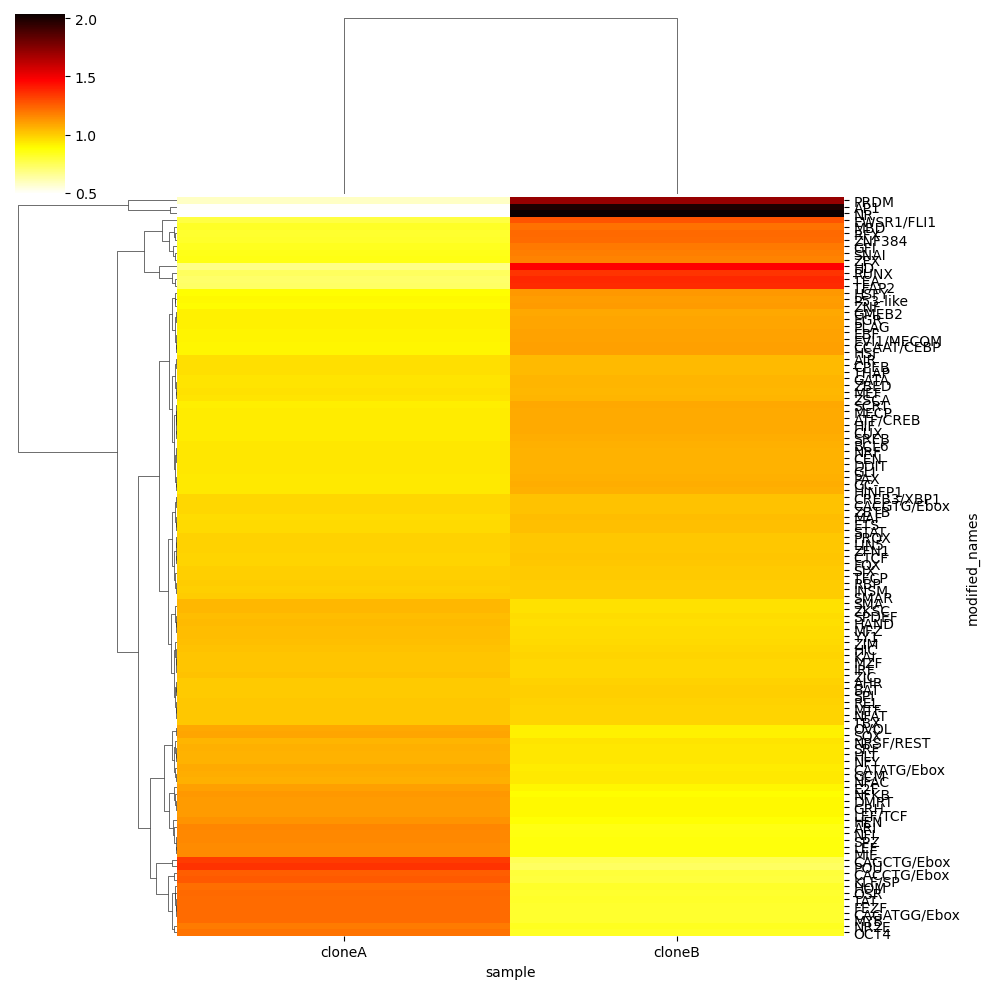

In [86]:
####################################################
# args
####################################################
suffix = 'clstrmp_mtfcmp_gbm39AvB_chr6'
grid ={'zscore': ['row', 'col', 'rowcol', None, ],
       'topn': [10, 20, None],
       'drop': ['ZNF', None]}
####################################################

dt = datetime.datetime.now().strftime('%y%m%d')
pfp = os.path.join('/home/nravindra/project/reg_diffs/results/tmp/', dt)
if not os.path.exists(pfp):
    os.makedirs(pfp)

count = 0
for zscore_type in grid['zscore']:
    for n in grid['topn']:
        for drop_motif in grid['drop']:
            print(count, '{}_{}_{}'.format(zscore_type, n, drop_motif))
            agg, p, dt = mtfcmp.viz_compare_enrich(
                enrich_out, 
                name_key=name_key, 
                drop_duplicates_key='modified_names', 
                names2display=None,
                topn=n,
                drop=drop_motif,
                zscore=zscore_type,
                save_plot=None if not export else os.path.join(pfp, '{}_z{}_top{}_drop{}.pdf'.format(suffix, zscore_type, n, drop_motif)),
                save_mat=None if not export else '/illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/{}_z{}_top{}_drop{}.csv'.format(suffix, zscore_type, n, drop_motif),
                return_plot_obj=True,
            )
            if export:
                dt['df_prez'].to_csv('/illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/{}_z{}_top{}_drop{}_preZ.csv'.format(suffix, zscore_type, n, drop_motif))
                print('  wrote {}'.format('/illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/{}_z{}_top{}_drop{}_preZ.csv'.format(suffix, zscore_type, n, drop_motif)))
            count+=1


### gbm 45

In [87]:
# modify dataframe, then plot
# run tst
enrich_out = evalism.chi2ovr(
        data=gbm_45_chr6,
        groups=None,
        notB_key='end_cnt_before', 
        B_key='end_cnt_after',
        return_df=True,
        verbose=True,
        name_key=name_key,
        )

data merged into one df in 0-s
through cloneA. time elapsed: 0-s
through cloneB. time elapsed: 0-s
n_tst: 224


0 row_10_ZNF
  wrote /illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/clstrmp_mtfcmp_gbm45AvB_chr6_zrow_top10_dropZNF_preZ.csv
1 row_10_None
  wrote /illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/clstrmp_mtfcmp_gbm45AvB_chr6_zrow_top10_dropNone_preZ.csv
2 row_20_ZNF
  wrote /illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/clstrmp_mtfcmp_gbm45AvB_chr6_zrow_top20_dropZNF_preZ.csv
3 row_20_None
  wrote /illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/clstrmp_mtfcmp_gbm45AvB_chr6_zrow_top20_dropNone_preZ.csv
4 row_None_ZNF
  wrote /illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/clstrmp_mtfcmp_gbm45AvB_chr6_zrow_topNone_dropZNF_preZ.csv
5 row_None_None
  wrote /illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/clstrmp_mtfcmp_gbm45AvB_chr6_zrow_topNone_dropNone_preZ.csv
6 col_10_ZNF
  wrote /illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/clstrmp_mtfcmp_gbm45AvB_chr6_zcol_top10_dropZNF_p

/home/nravindra/miniconda3/envs/seq2atac/lib/python3.10/site-packages/seaborn/matrix.py:812: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self._figure = plt.figure(figsize=figsize)


  wrote /illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/clstrmp_mtfcmp_gbm45AvB_chr6_zNone_top20_dropZNF_preZ.csv
21 None_20_None
  wrote /illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/clstrmp_mtfcmp_gbm45AvB_chr6_zNone_top20_dropNone_preZ.csv
22 None_None_ZNF
  wrote /illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/clstrmp_mtfcmp_gbm45AvB_chr6_zNone_topNone_dropZNF_preZ.csv
23 None_None_None
  wrote /illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/clstrmp_mtfcmp_gbm45AvB_chr6_zNone_topNone_dropNone_preZ.csv


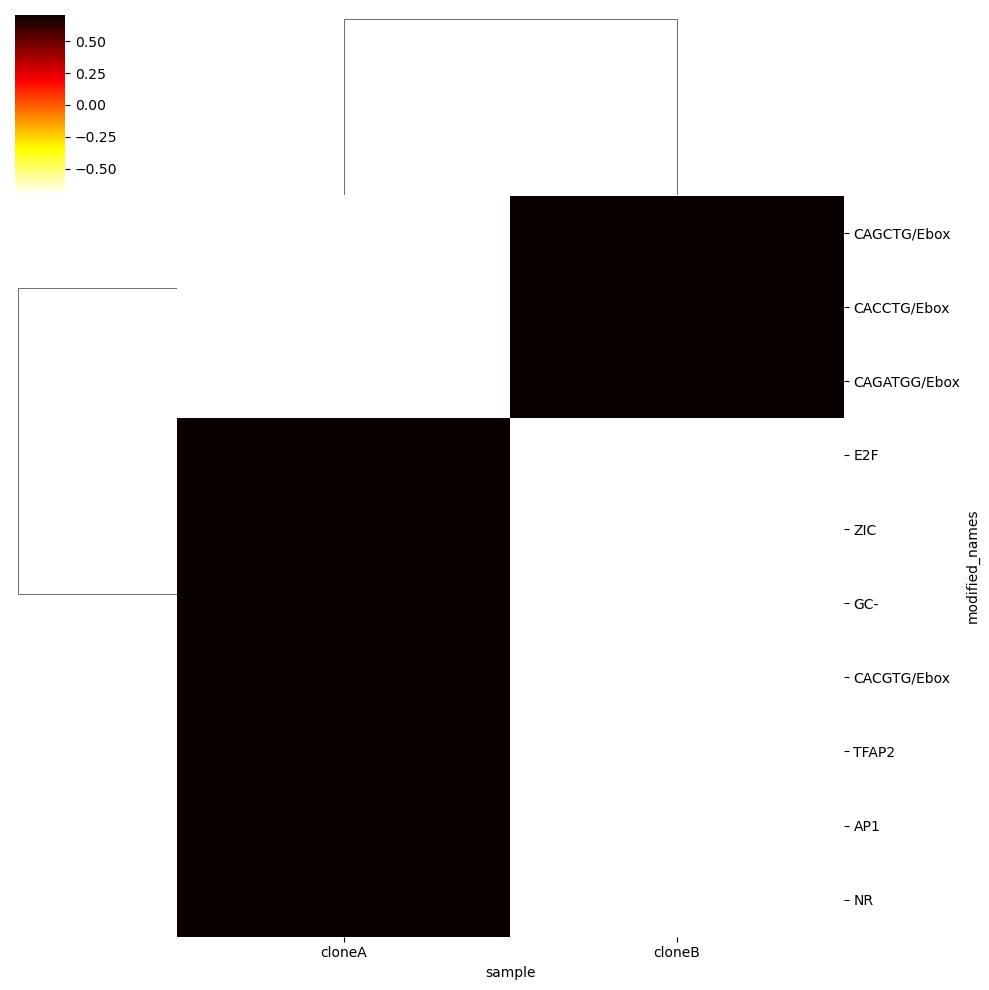

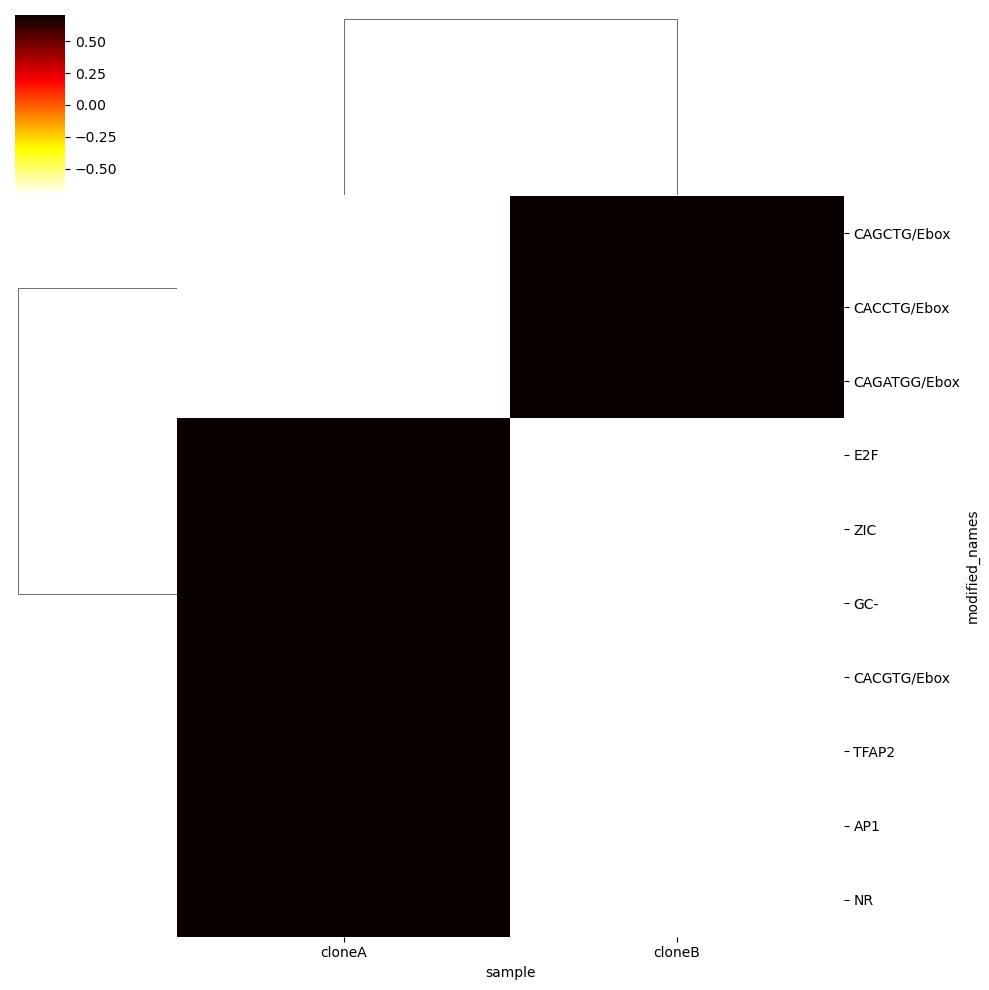

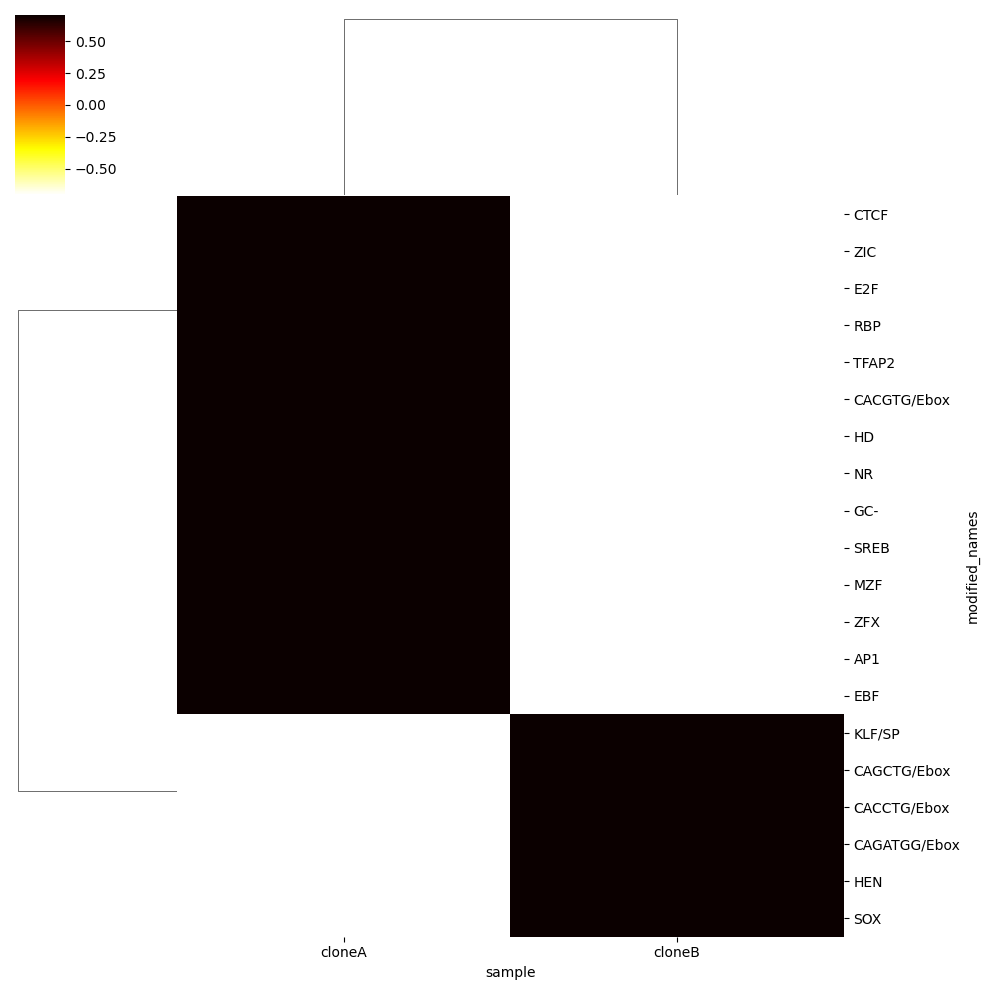

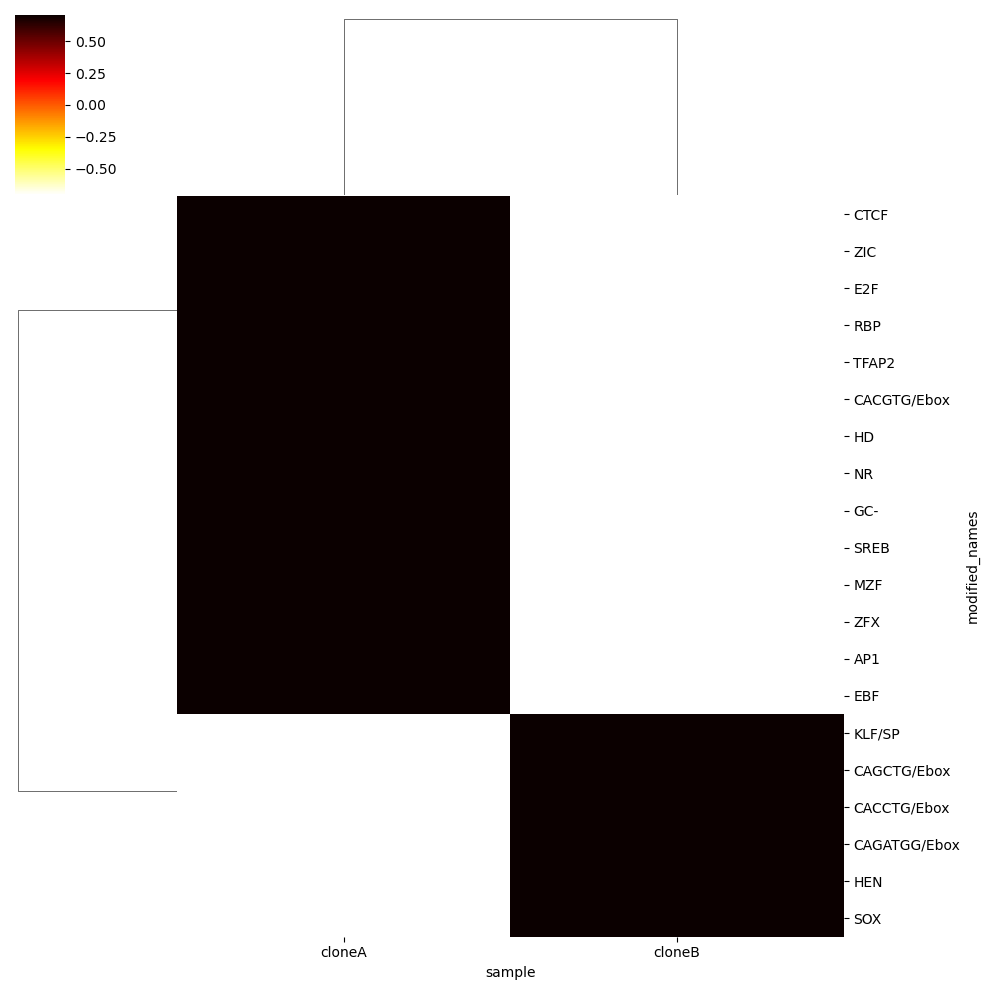

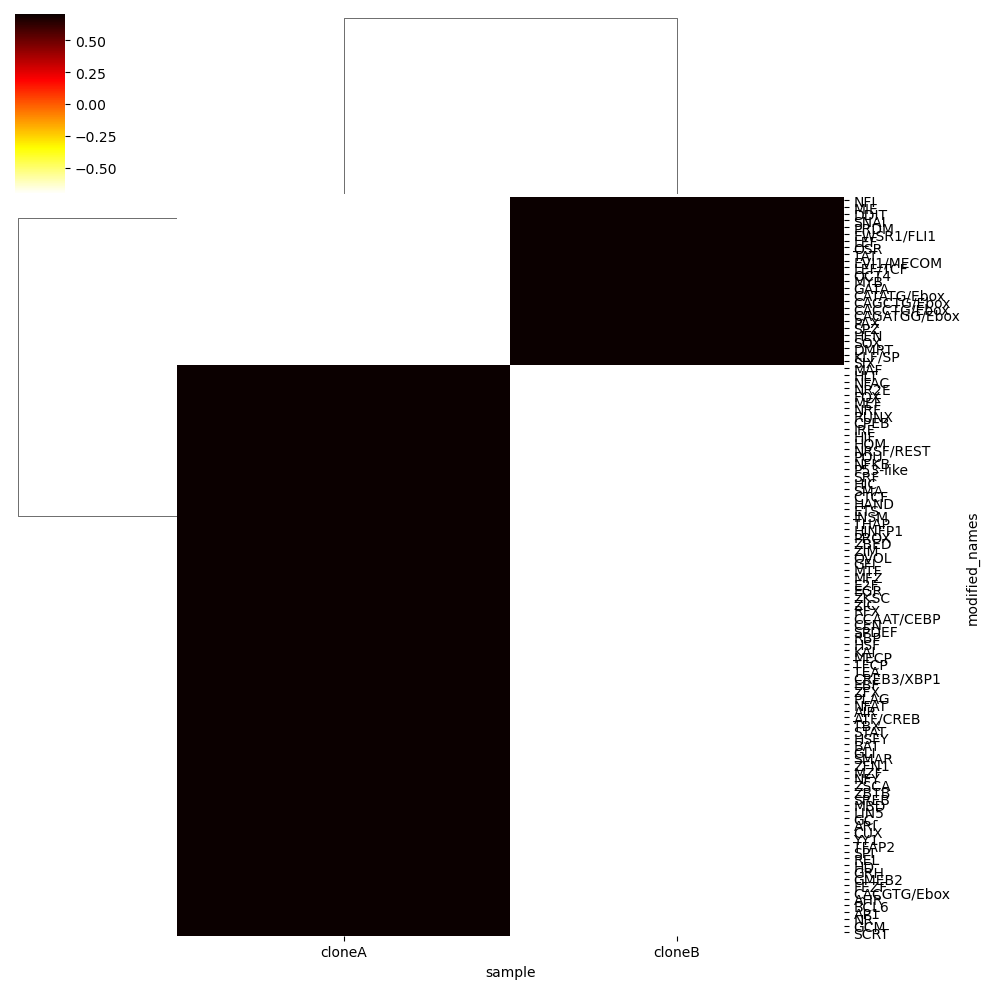

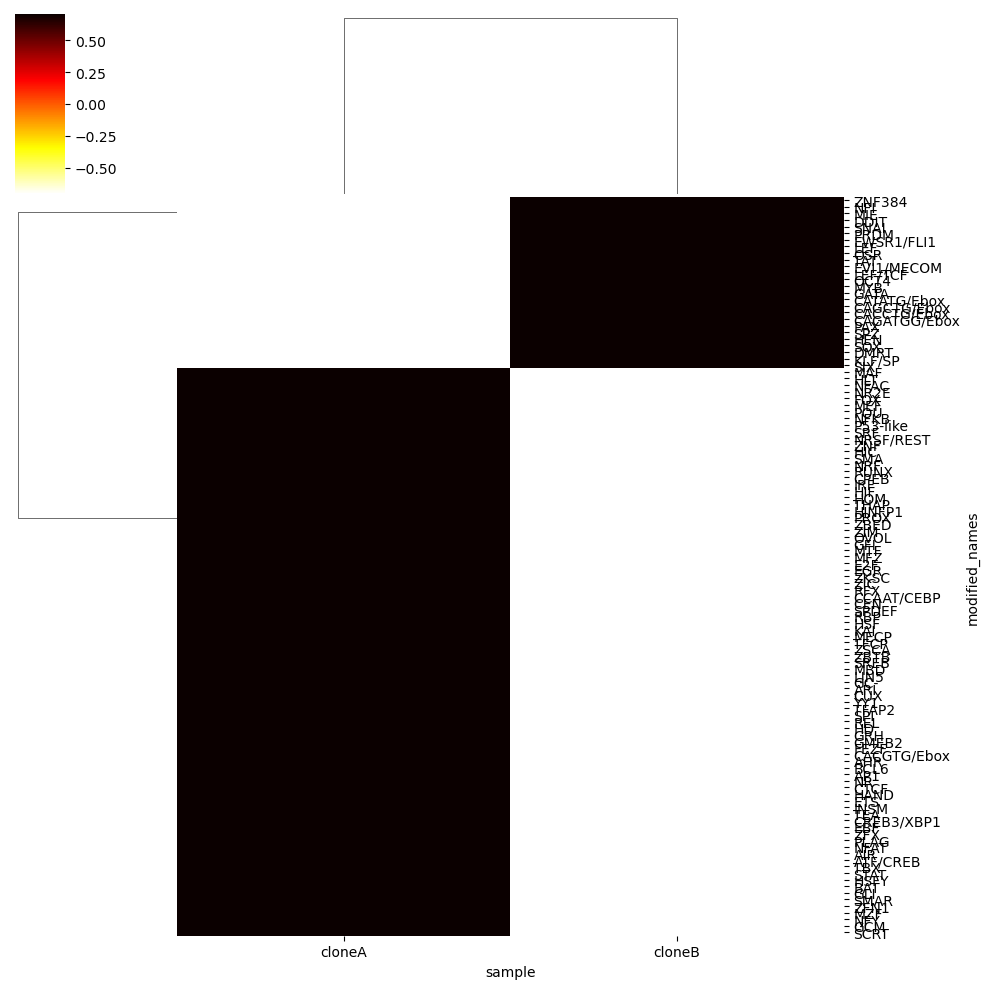

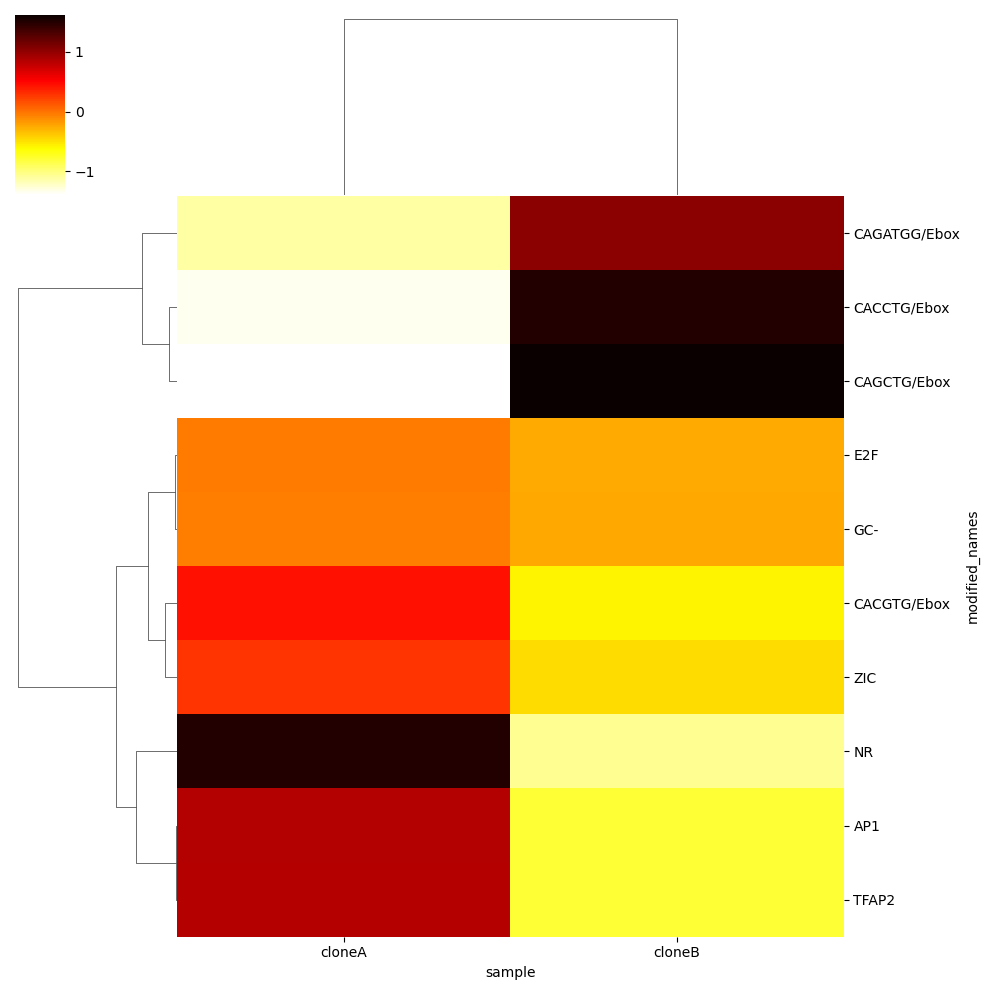

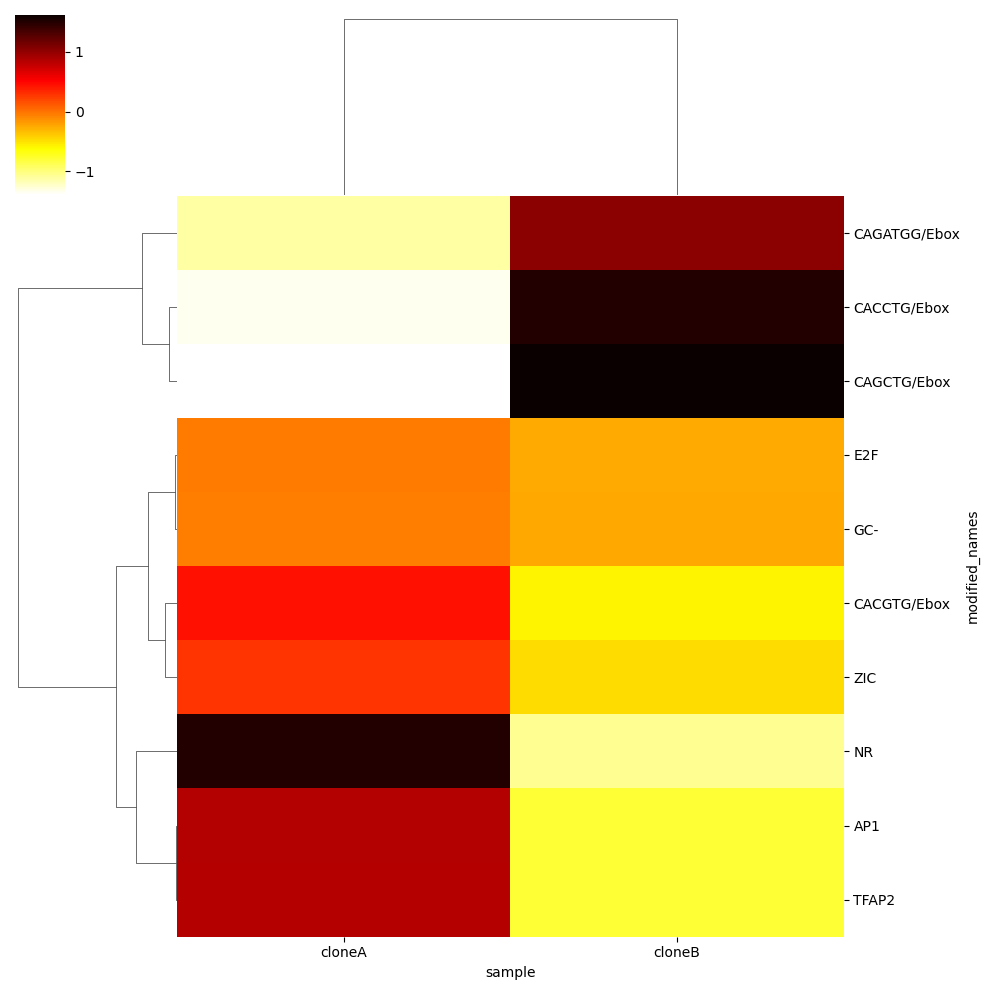

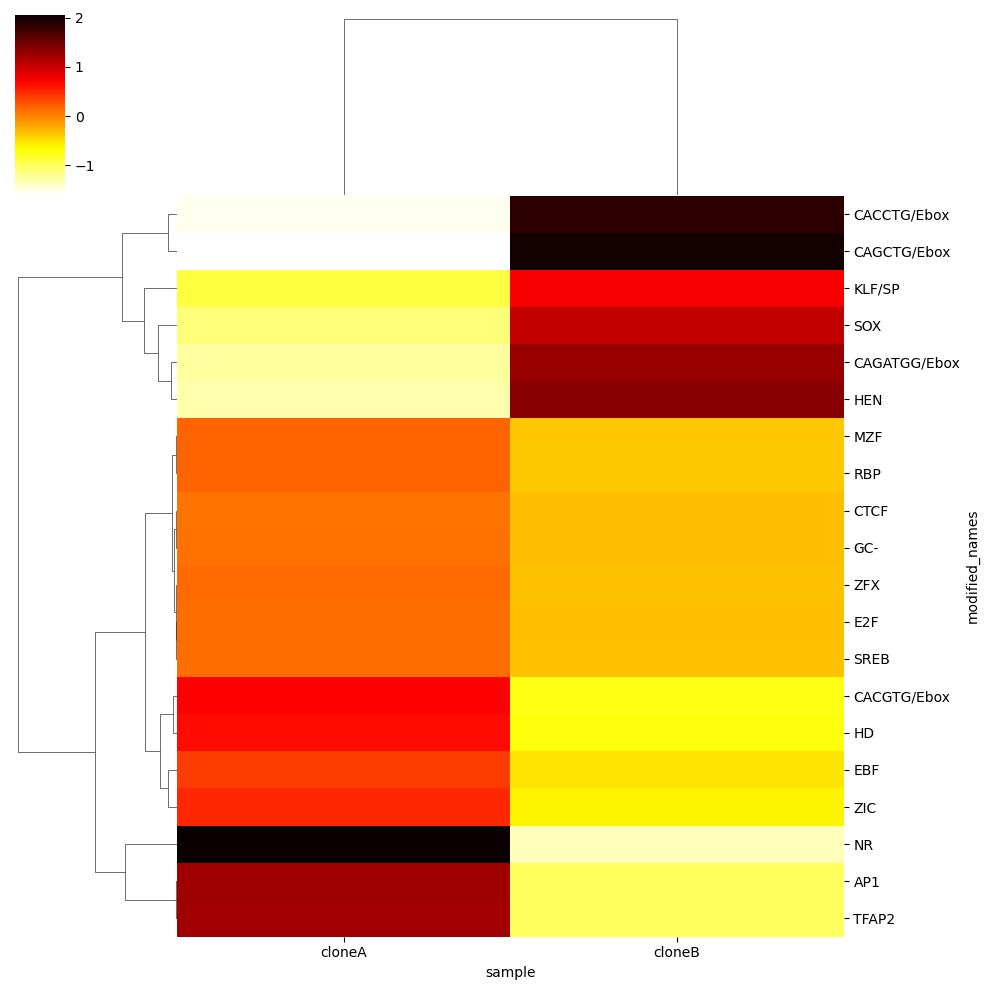

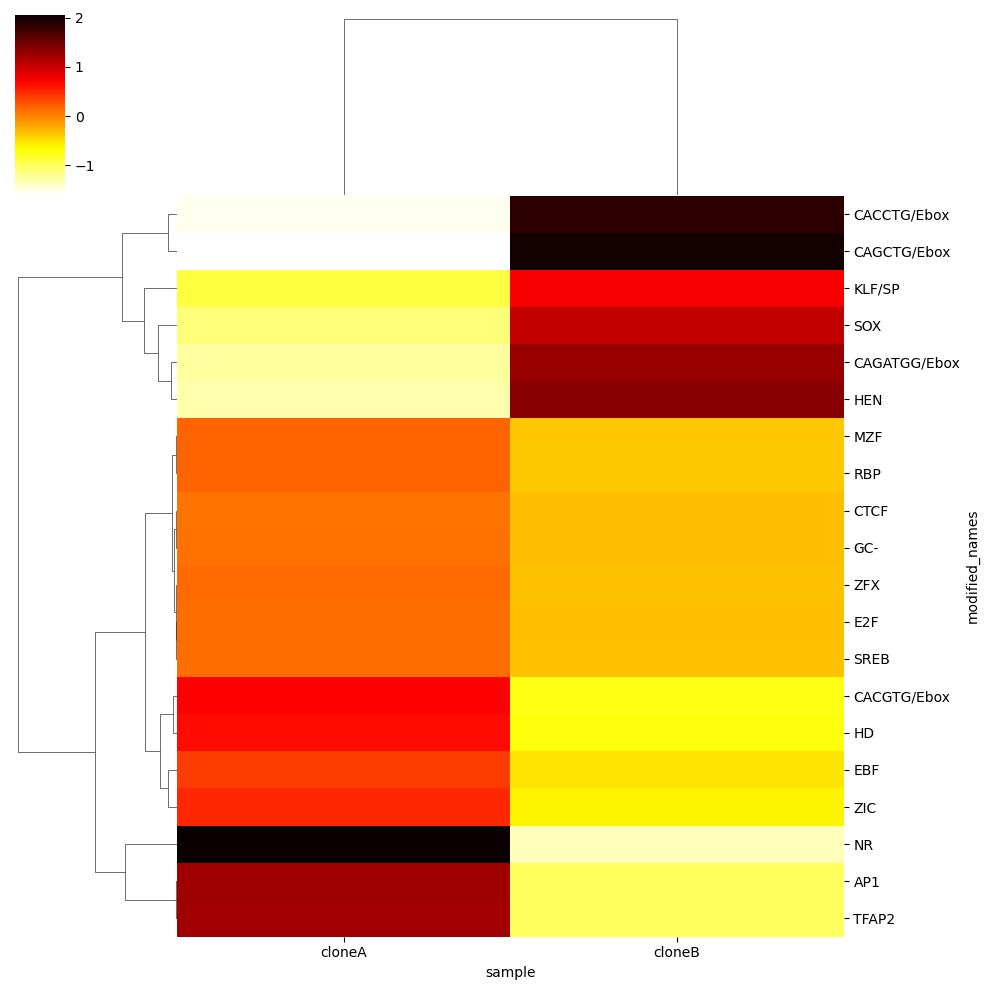

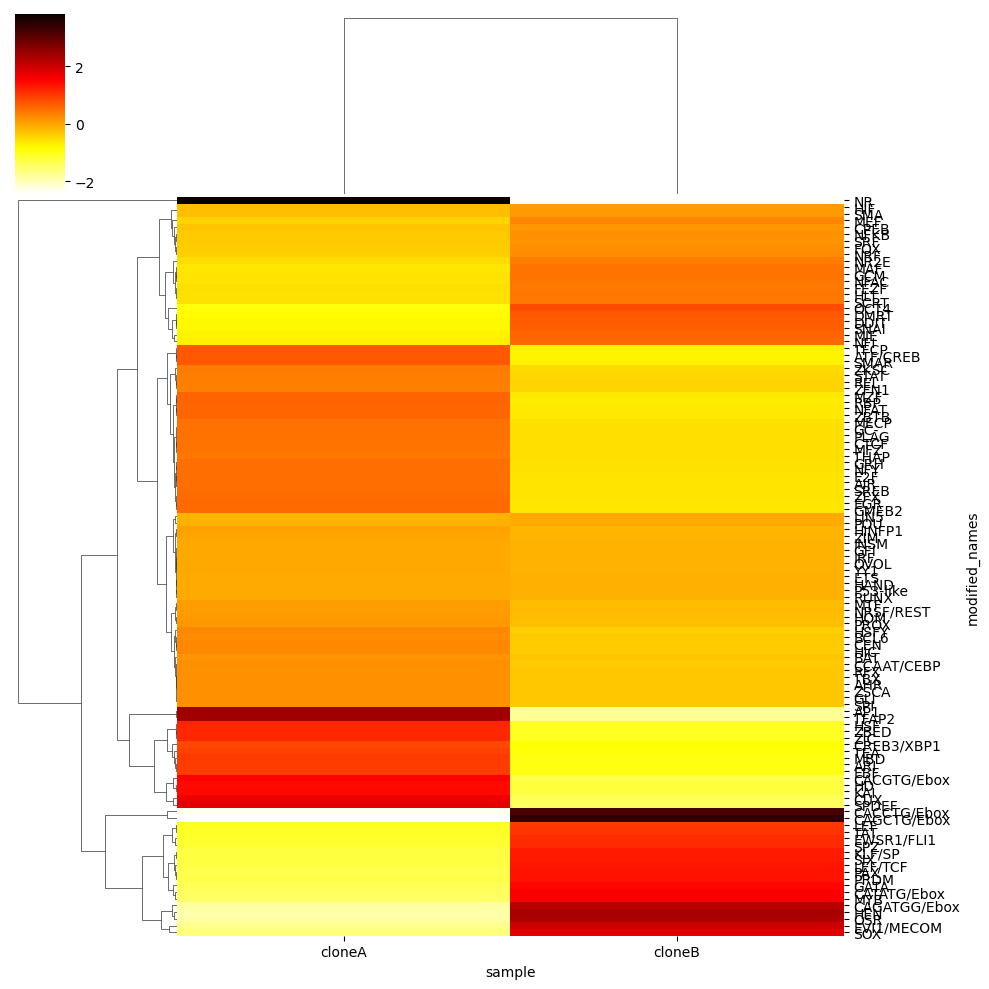

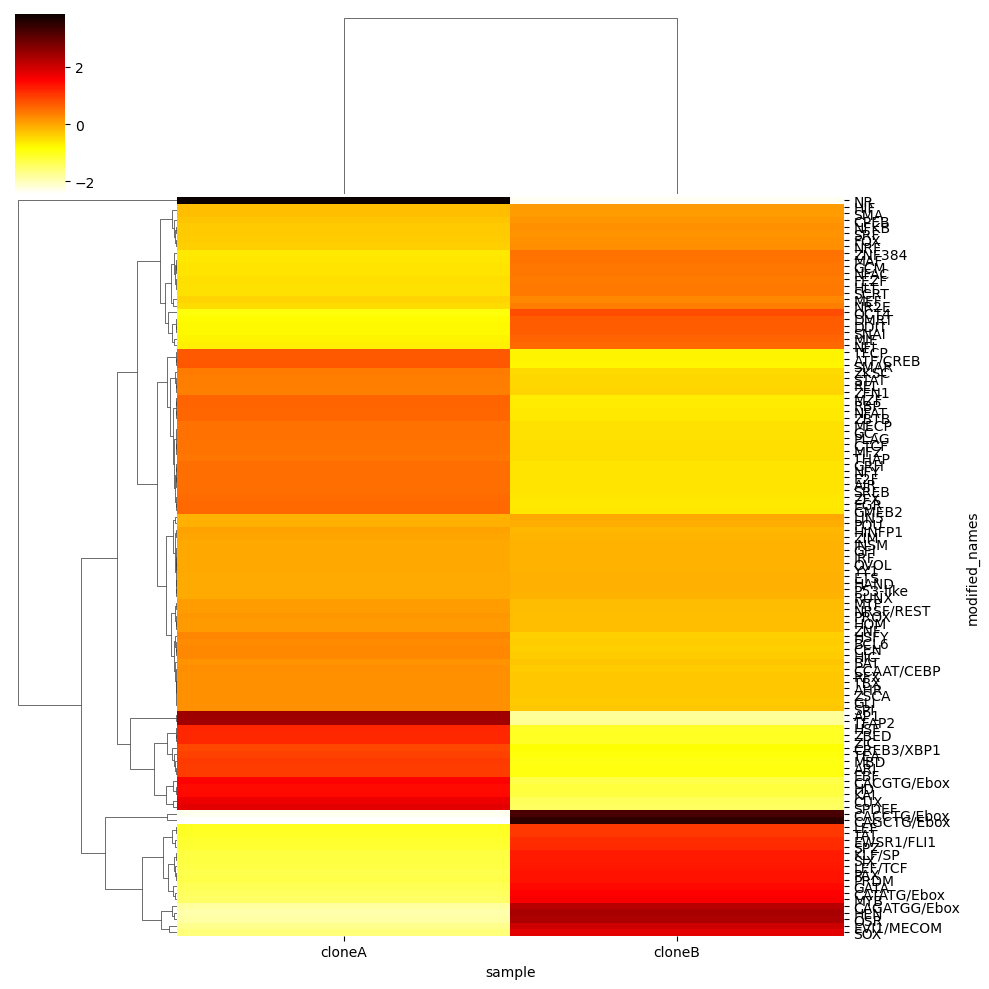

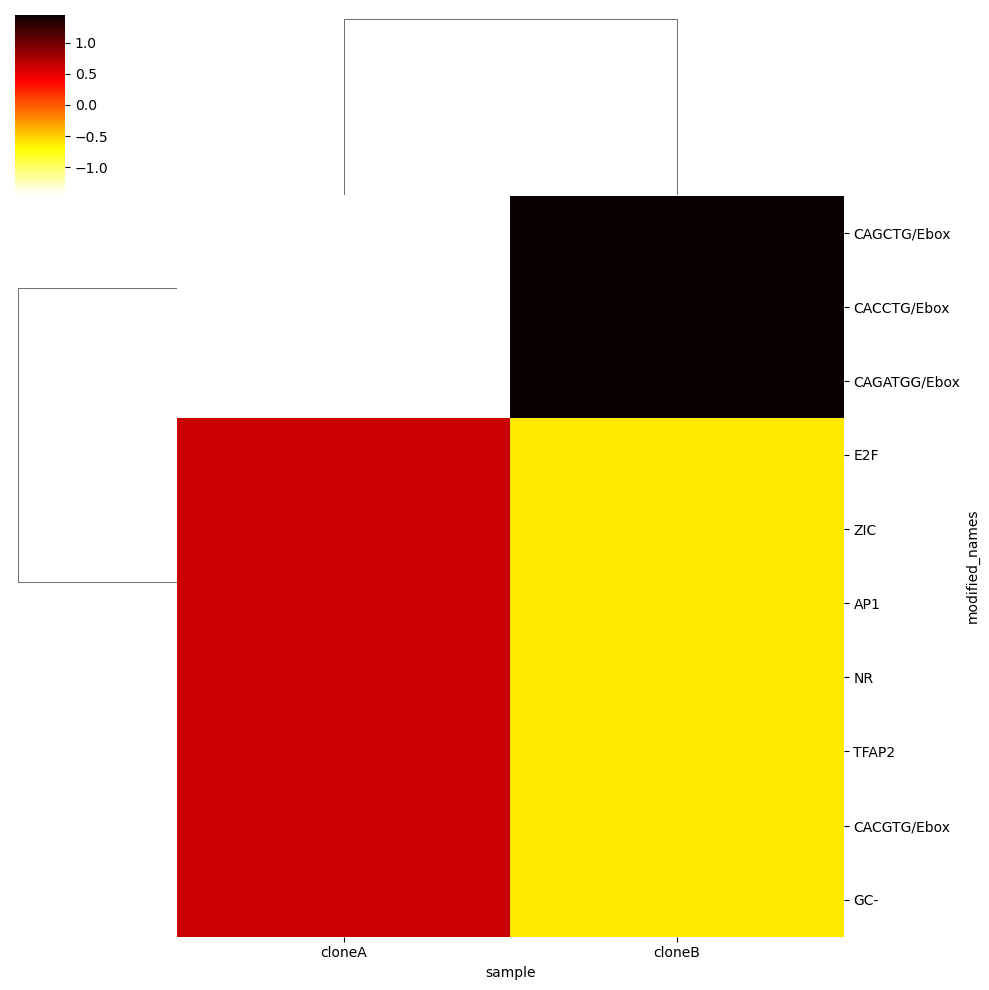

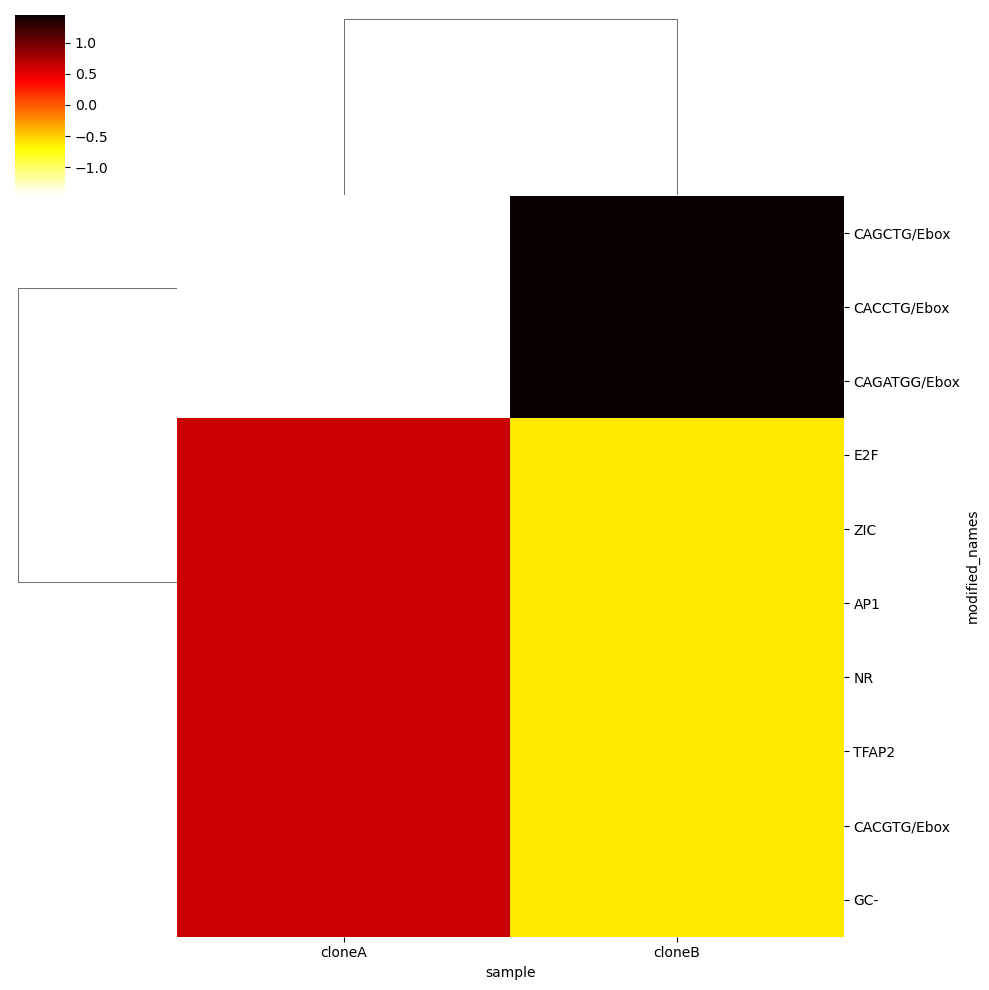

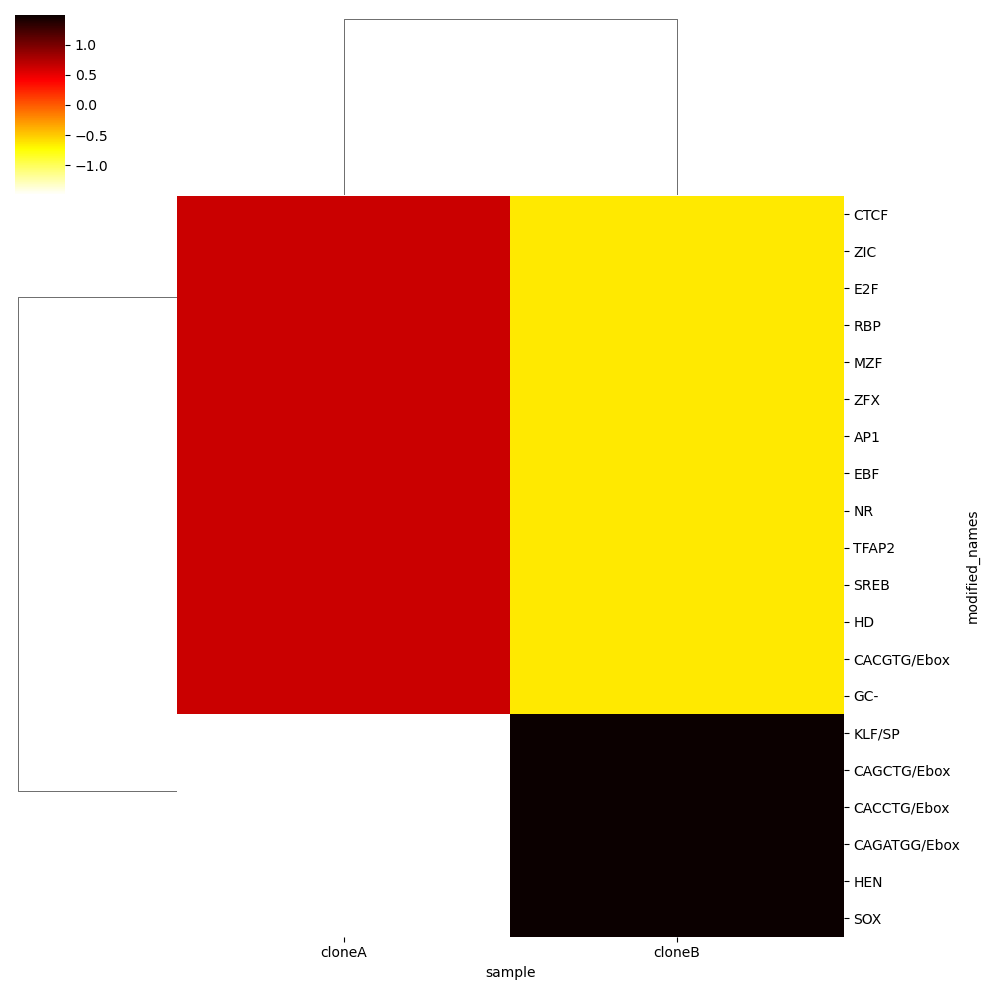

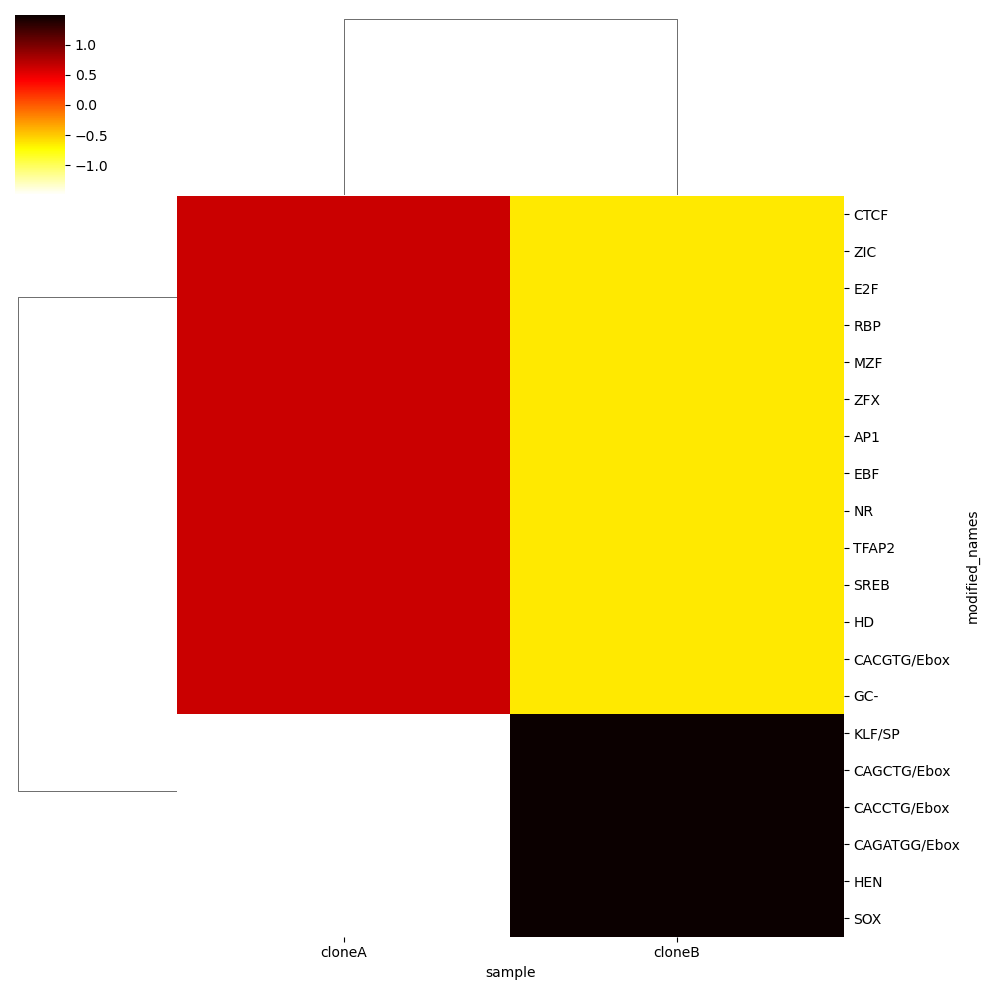

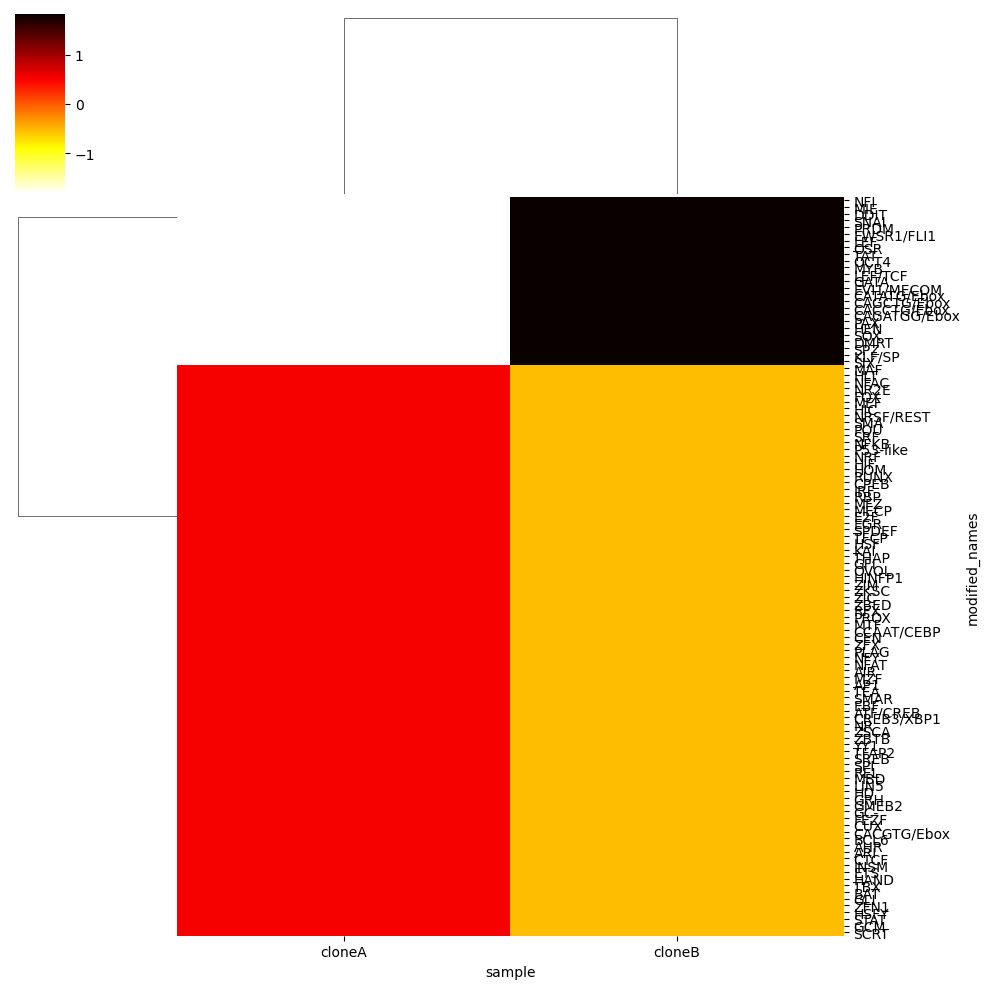

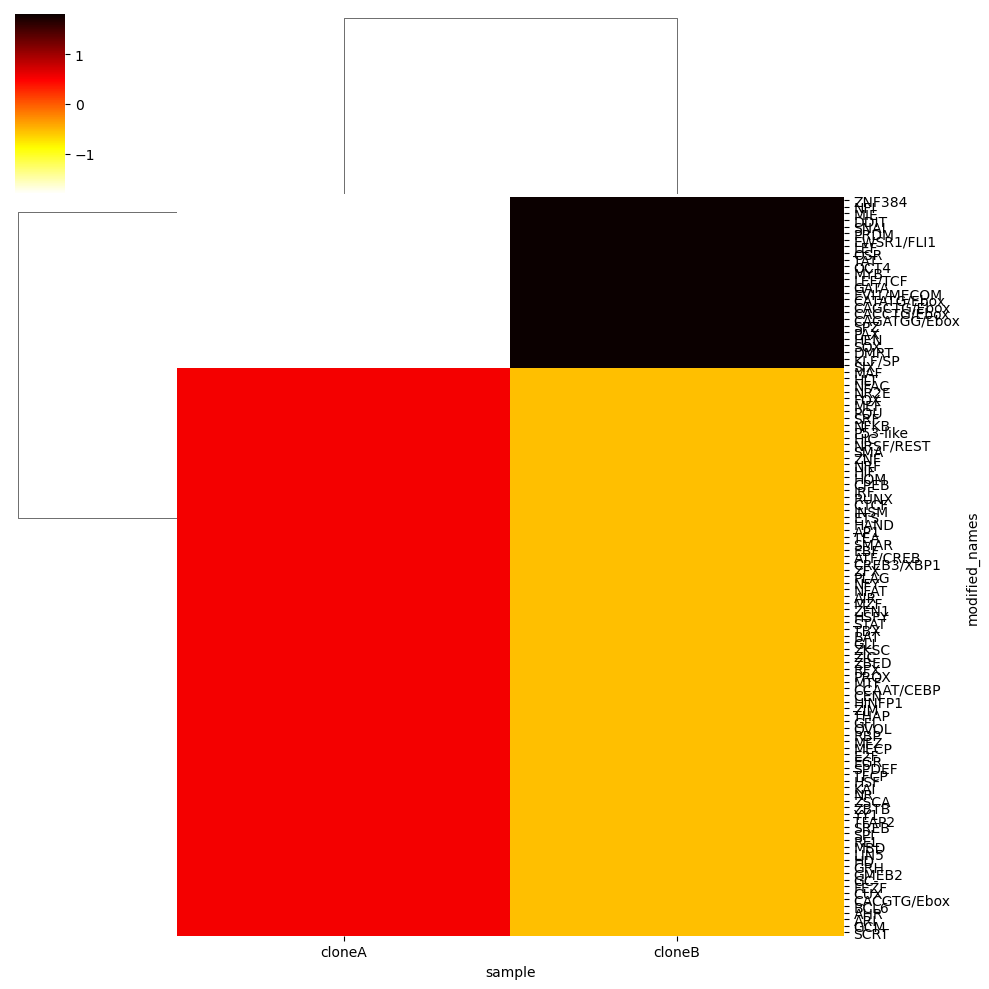

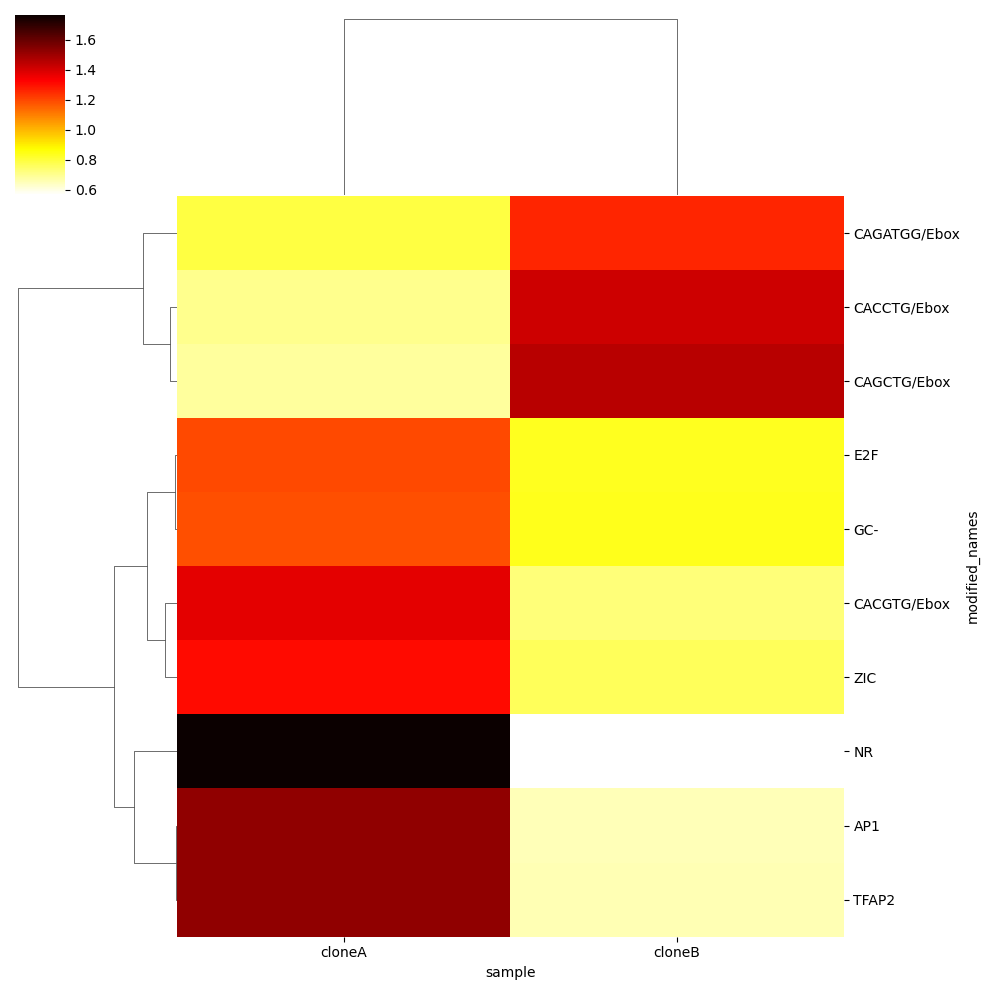

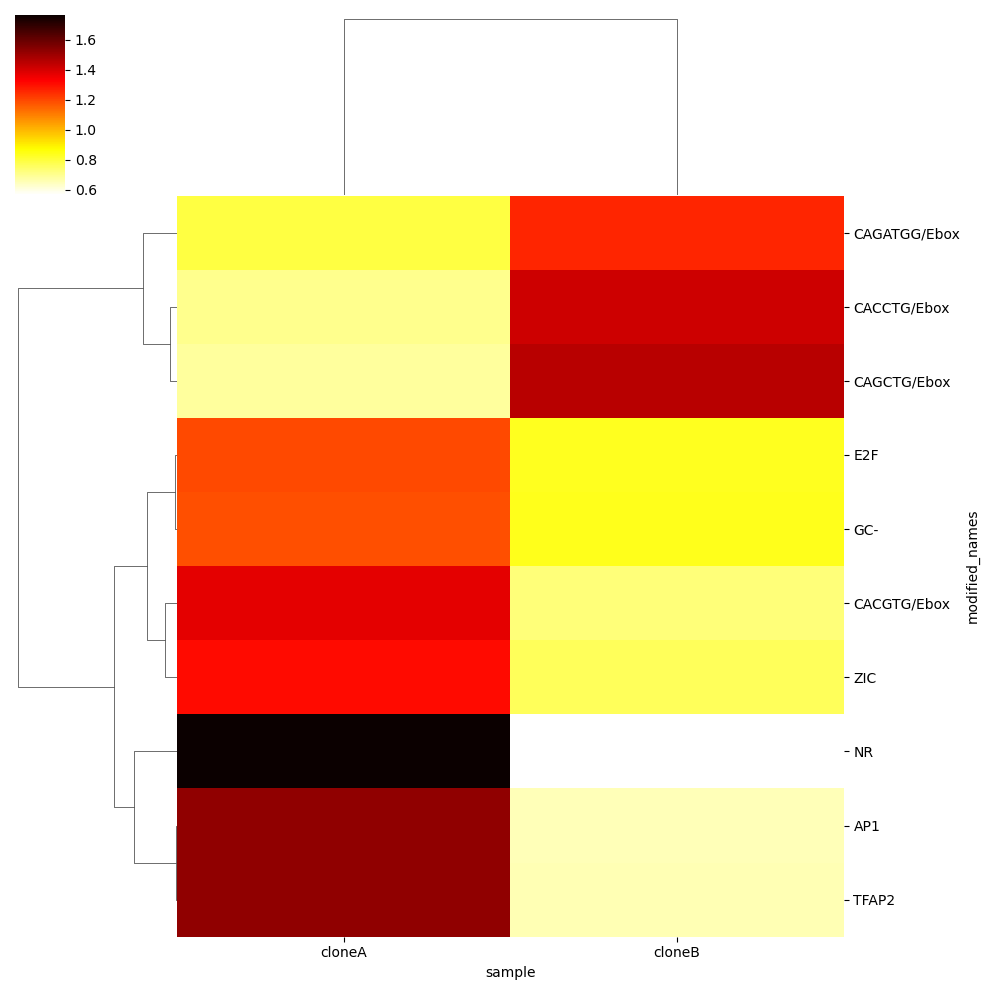

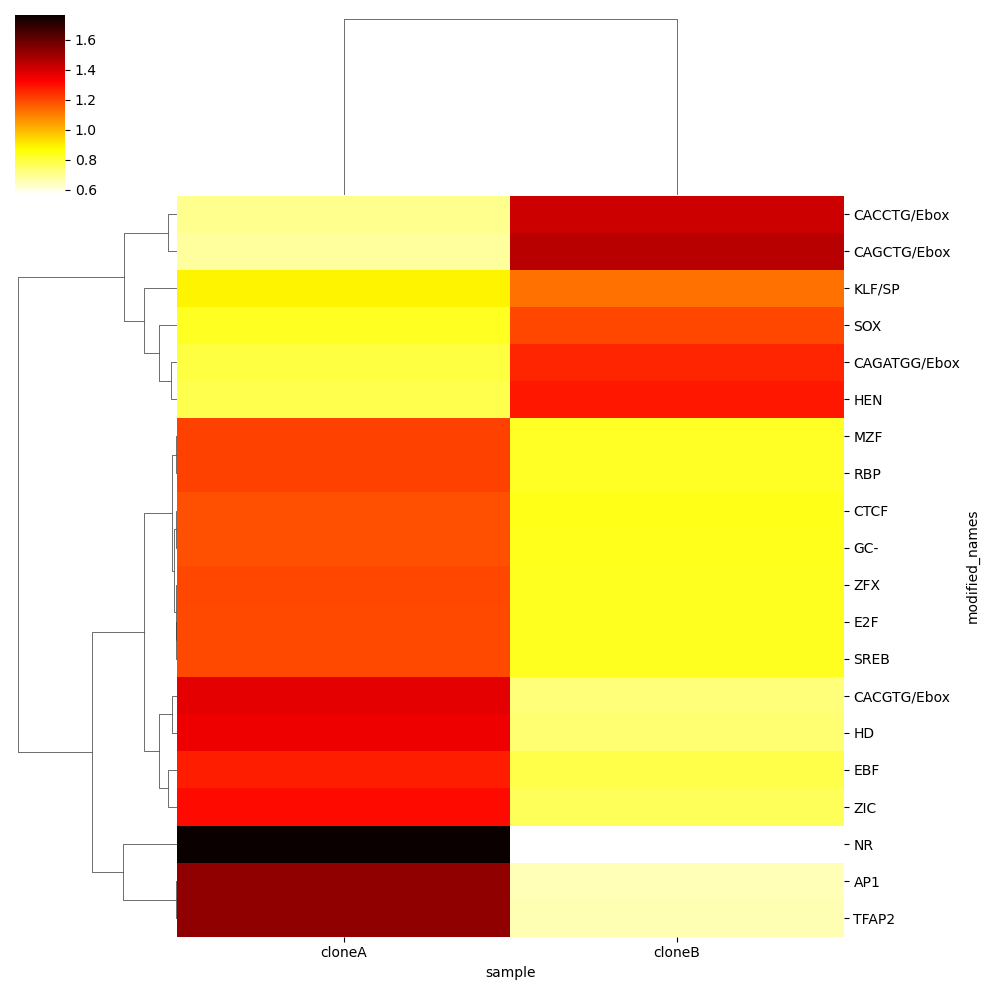

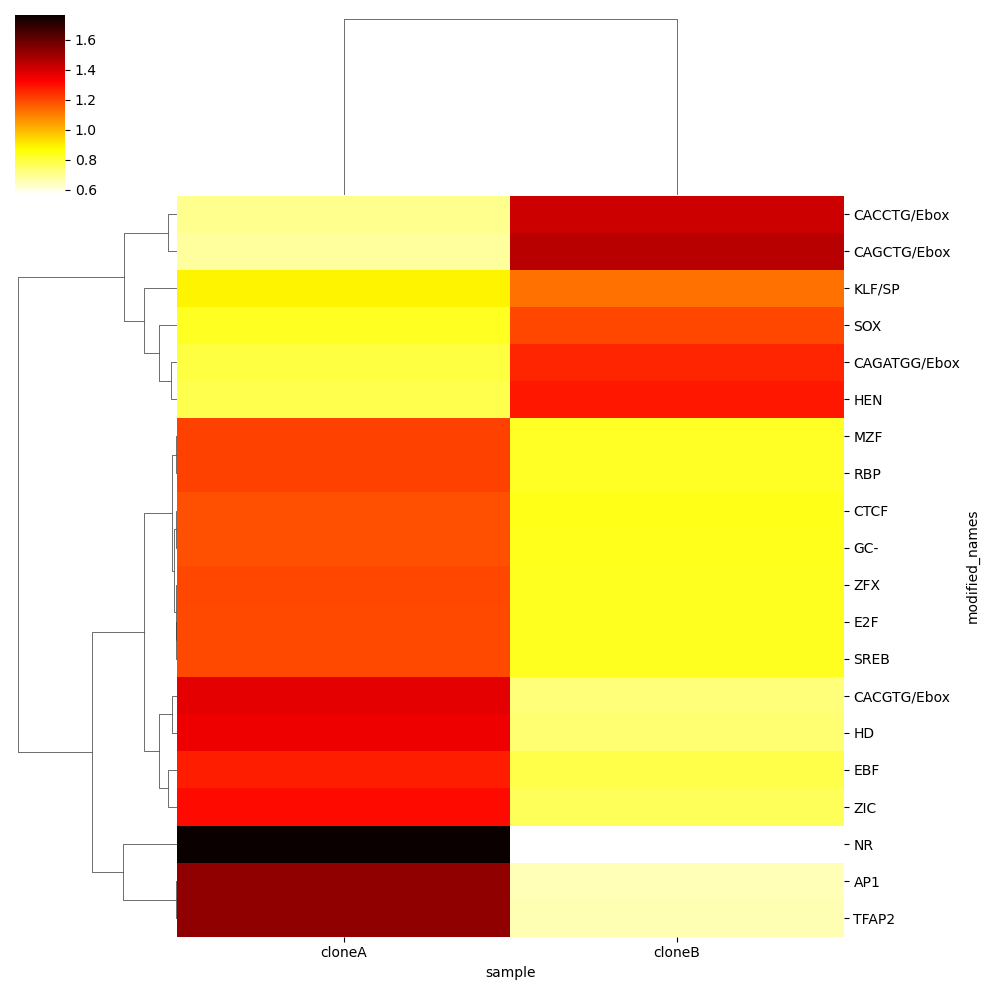

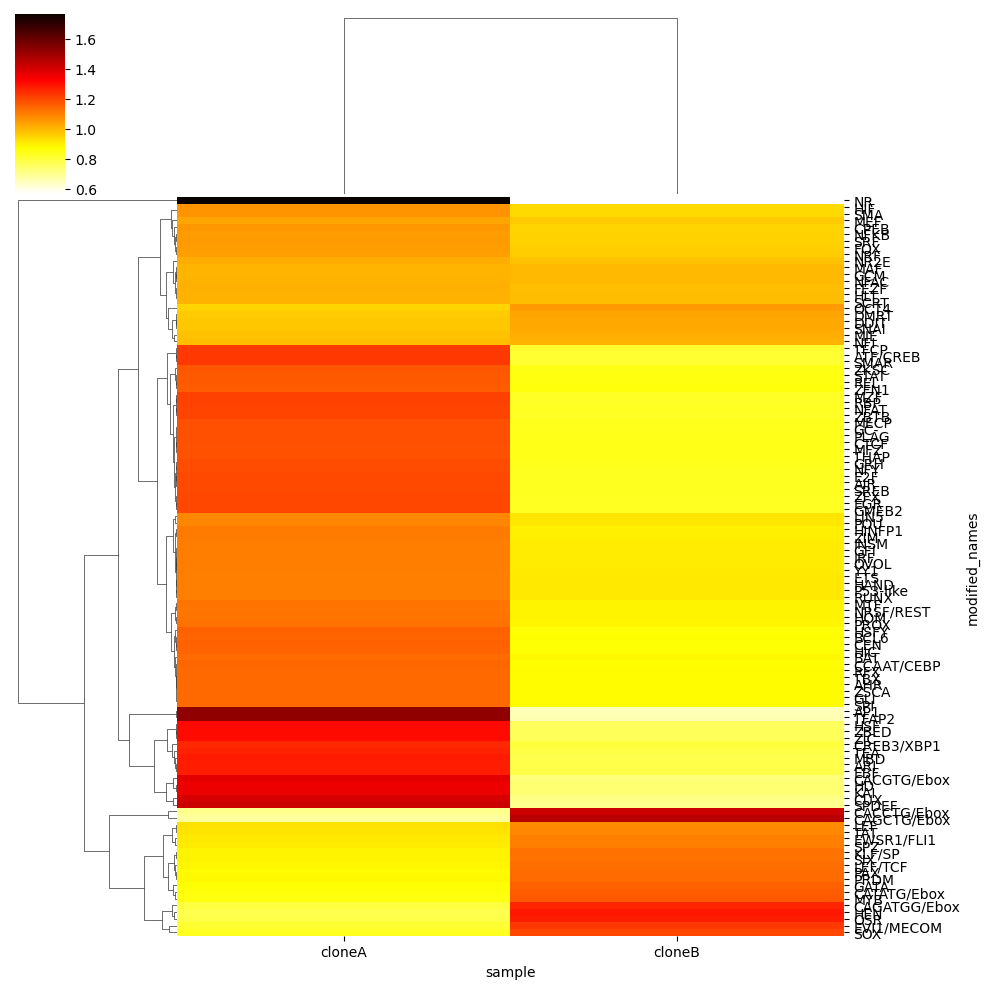

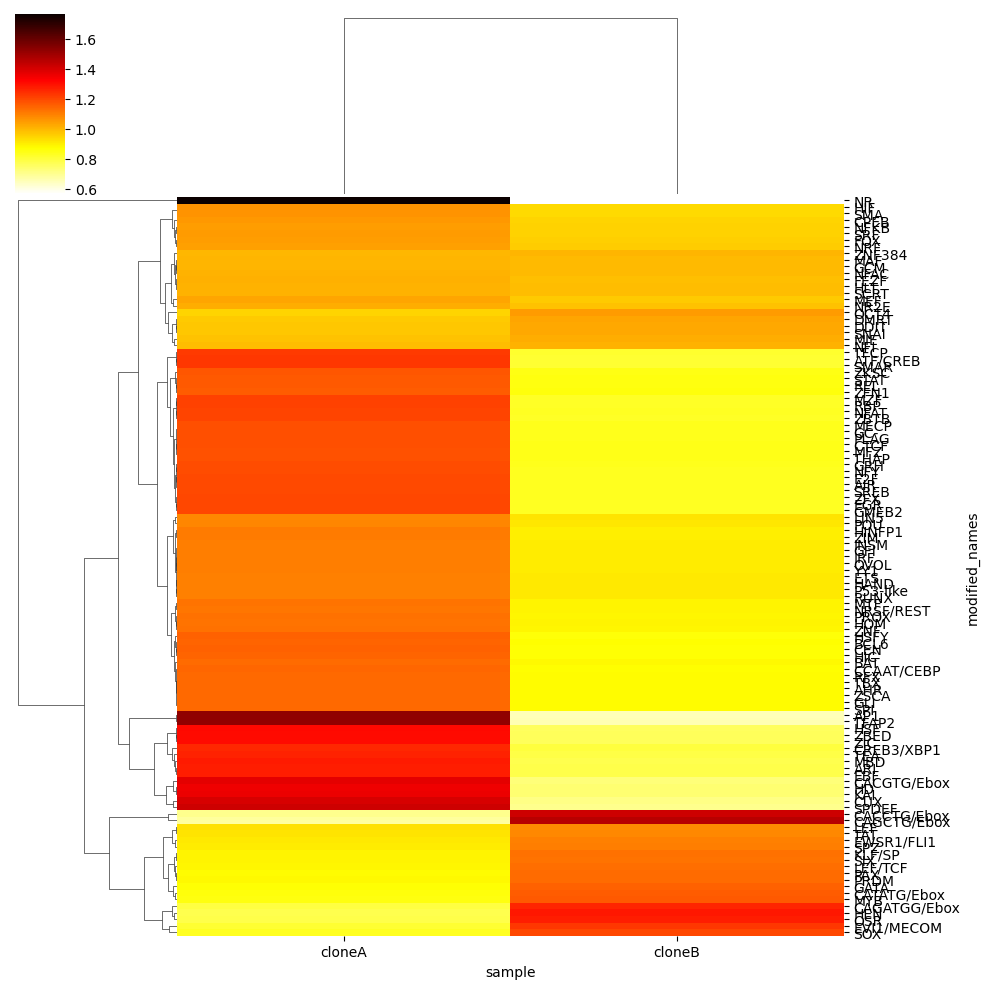

In [88]:
####################################################
# args
####################################################
suffix = 'clstrmp_mtfcmp_gbm45AvB_chr6'
grid ={'zscore': ['row', 'col', 'rowcol', None, ],
       'topn': [10, 20, None],
       'drop': ['ZNF', None]}
####################################################

dt = datetime.datetime.now().strftime('%y%m%d')
pfp = os.path.join('/home/nravindra/project/reg_diffs/results/tmp/', dt)
if not os.path.exists(pfp):
    os.makedirs(pfp)

count = 0
for zscore_type in grid['zscore']:
    for n in grid['topn']:
        for drop_motif in grid['drop']:
            print(count, '{}_{}_{}'.format(zscore_type, n, drop_motif))
            agg, p, dt = mtfcmp.viz_compare_enrich(
                enrich_out, 
                name_key=name_key, 
                drop_duplicates_key='modified_names', 
                names2display=None,
                topn=n,
                drop=drop_motif,
                zscore=zscore_type,
                save_plot=None if not export else os.path.join(pfp, '{}_z{}_top{}_drop{}.pdf'.format(suffix, zscore_type, n, drop_motif)),
                save_mat=None if not export else '/illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/{}_z{}_top{}_drop{}.csv'.format(suffix, zscore_type, n, drop_motif),
                return_plot_obj=True,
            )
            if export:
                dt['df_prez'].to_csv('/illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/{}_z{}_top{}_drop{}_preZ.csv'.format(suffix, zscore_type, n, drop_motif))
                print('  wrote {}'.format('/illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/{}_z{}_top{}_drop{}_preZ.csv'.format(suffix, zscore_type, n, drop_motif)))
            count+=1


## exclude chr 6

In [89]:
gbm_39_nochr6 = {'cloneA': gbm39['cloneA'].loc[gbm39['cloneA']['seqnames']!='chr6'],
               'cloneB': gbm39['cloneB'].loc[gbm39['cloneB']['seqnames']!='chr6']}
gbm_45_nochr6 = {'cloneA': gbm45['cloneA'].loc[gbm45['cloneA']['seqnames']!='chr6'],
               'cloneB': gbm45['cloneB'].loc[gbm45['cloneB']['seqnames']!='chr6']}

In [90]:
# modify dataframe, then plot
# run tst
enrich_out = evalism.chi2ovr(
        data=gbm_45_nochr6,
        groups=None,
        notB_key='end_cnt_before', 
        B_key='end_cnt_after',
        return_df=True,
        verbose=True,
        name_key=name_key,
        )

data merged into one df in 1-s
through cloneA. time elapsed: 1-s
through cloneB. time elapsed: 2-s
n_tst: 224


0 rowcol_None_None
  wrote /illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/clstrmp_mtfcmp_gbm45AvB_nochr6_zrowcol_topNone_dropNone_preZ.csv
1 None_None_None
  wrote /illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/clstrmp_mtfcmp_gbm45AvB_nochr6_zNone_topNone_dropNone_preZ.csv


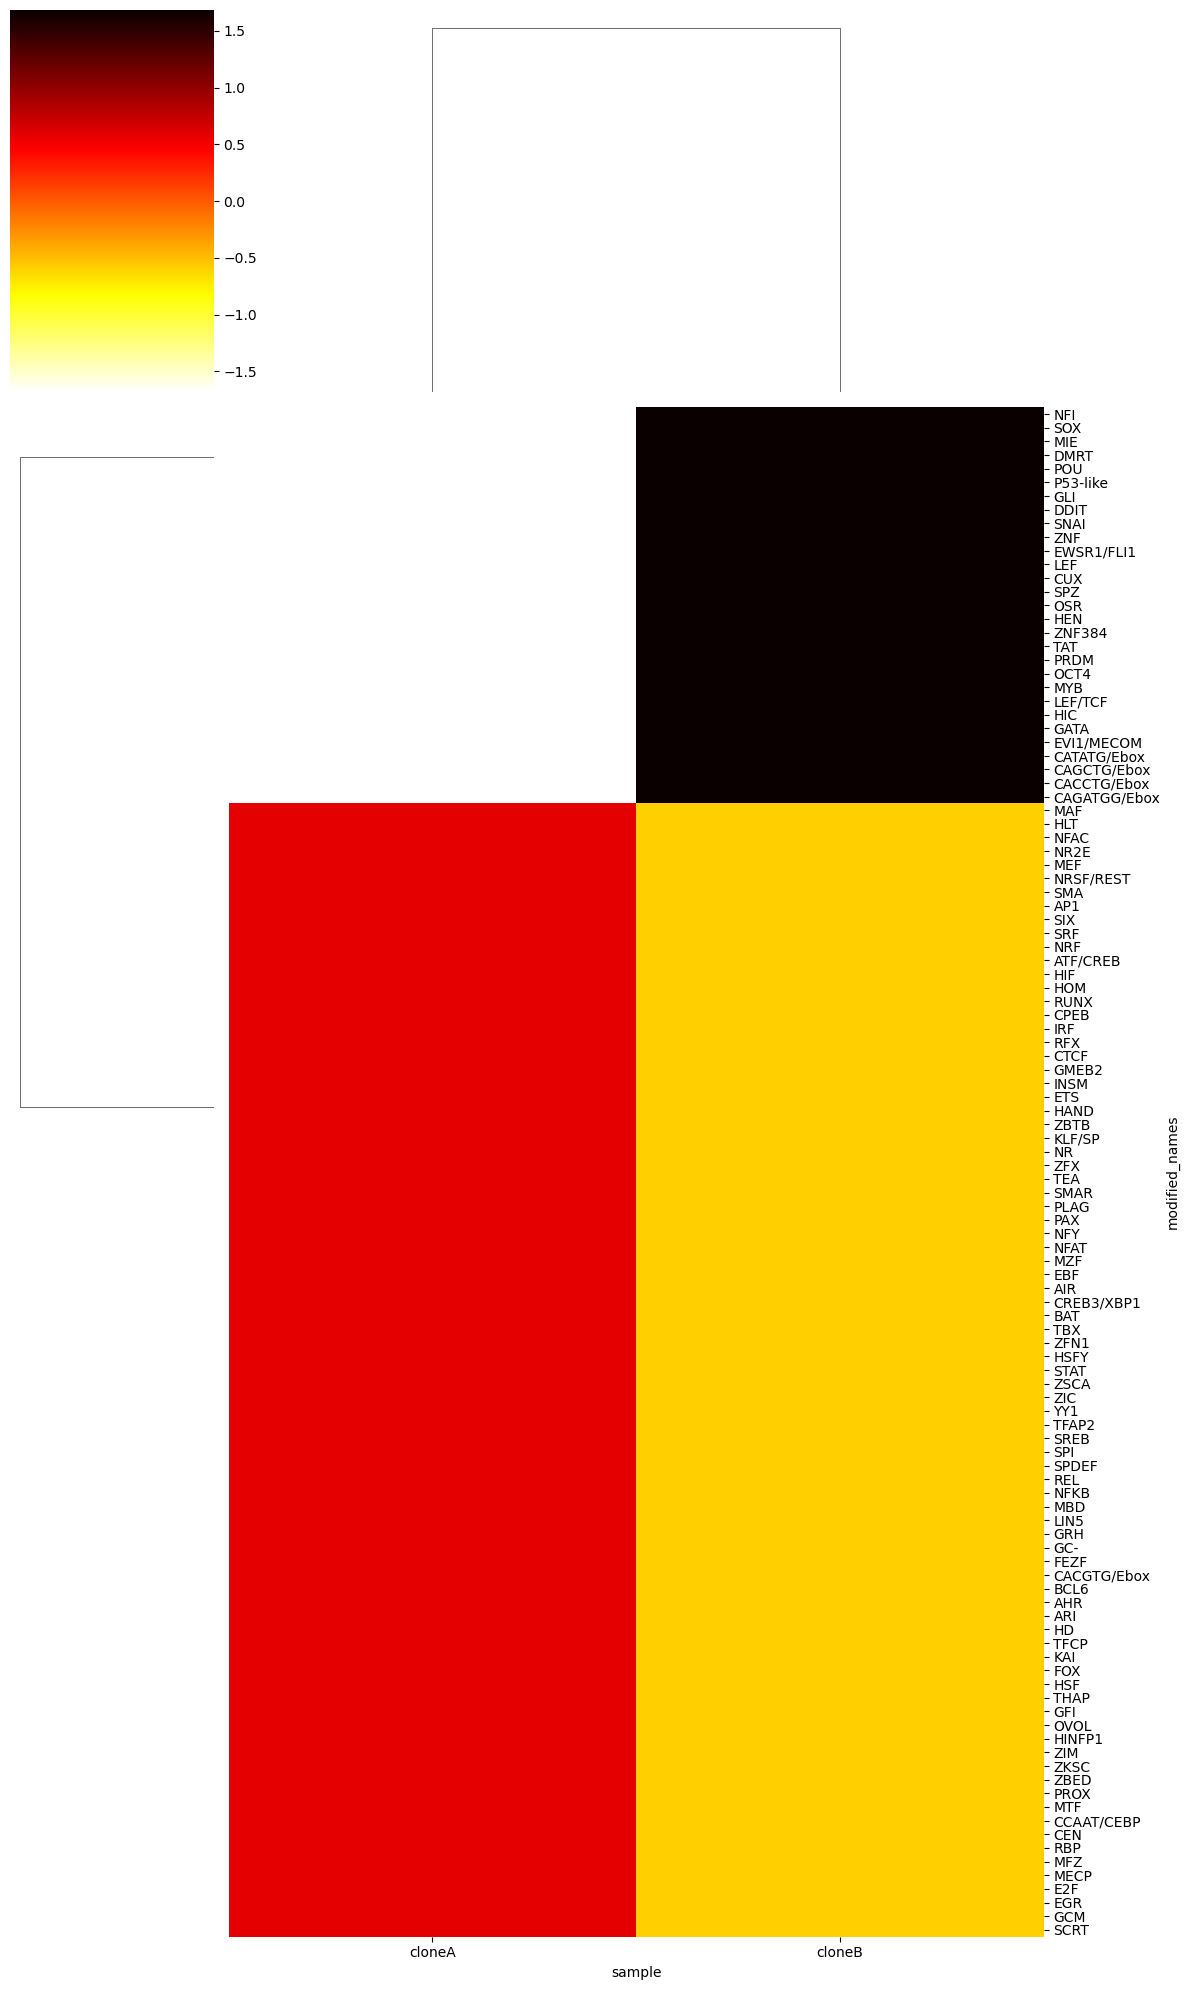

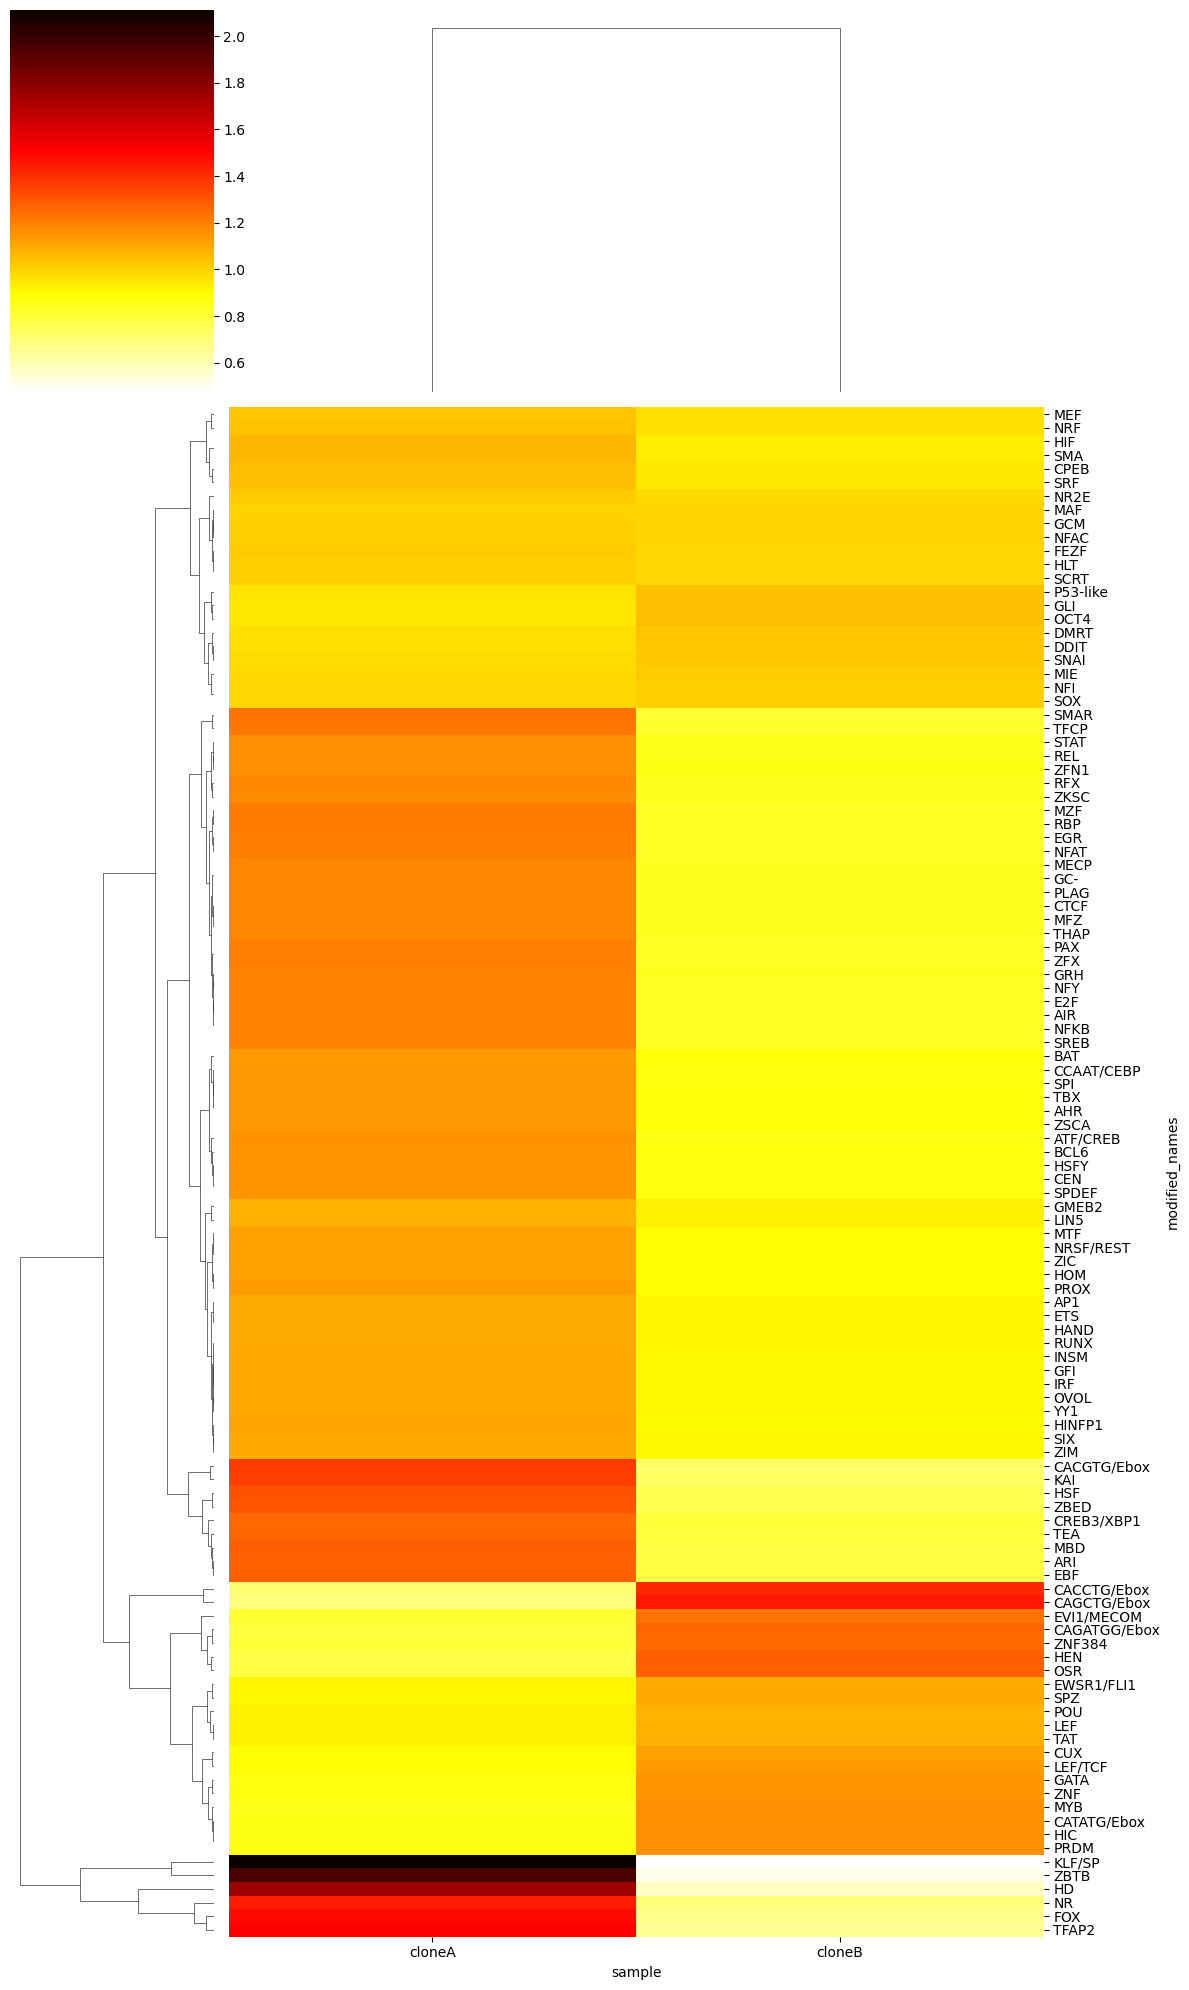

In [105]:
####################################################
# args
####################################################
suffix = 'clstrmp_mtfcmp_gbm45AvB_nochr6'
grid ={'zscore': ['rowcol', None, ],
       'topn': [None],
       'drop': [None]}
####################################################

dt = datetime.datetime.now().strftime('%y%m%d')
pfp = os.path.join('/home/nravindra/project/reg_diffs/results/tmp/', dt)
if not os.path.exists(pfp):
    os.makedirs(pfp)

count = 0
for zscore_type in grid['zscore']:
    for n in grid['topn']:
        for drop_motif in grid['drop']:
            print(count, '{}_{}_{}'.format(zscore_type, n, drop_motif))
            agg, p, dt = mtfcmp.viz_compare_enrich(
                enrich_out, 
                name_key=name_key, 
                drop_duplicates_key='modified_names', 
                names2display=None,
                topn=n,
                drop=drop_motif,
                zscore=zscore_type,
                save_plot=None if not export else os.path.join(pfp, '{}_z{}_top{}_drop{}.pdf'.format(suffix, zscore_type, n, drop_motif)),
                save_mat=None if not export else '/illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/{}_z{}_top{}_drop{}.csv'.format(suffix, zscore_type, n, drop_motif),
                return_plot_obj=True,
            )
            if export:
                dt['df_prez'].to_csv('/illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/{}_z{}_top{}_drop{}_preZ.csv'.format(suffix, zscore_type, n, drop_motif))
                print('  wrote {}'.format('/illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/{}_z{}_top{}_drop{}_preZ.csv'.format(suffix, zscore_type, n, drop_motif)))
            count+=1


In [101]:
agg

modified_names         p_chi2        OR  sample   p_bonferonni
0           KLF/SP   0.000000e+00  2.111925  cloneA   0.000000e+00
1              GC-   0.000000e+00  1.188411  cloneA   0.000000e+00
2      CAGCTG/Ebox   0.000000e+00  0.687055  cloneA   0.000000e+00
3            TFAP2  8.566774e-307  1.522313  cloneA  1.918957e-304
4             ZBTB  2.538365e-298  1.954011  cloneA  5.685937e-296
..             ...            ...       ...     ...            ...
219           NR2E   7.552392e-01  0.981101  cloneB   1.691736e+02
220            GCM   8.130956e-01  0.995005  cloneB   1.821334e+02
221           SCRT   8.168501e-01  0.990561  cloneB   1.829744e+02
222            MAF   8.510980e-01  0.997130  cloneB   1.906459e+02
223            HLT   9.035765e-01  0.990939  cloneB   2.024011e+02

[224 rows x 5 columns]

In [104]:
import importlib
importlib.reload(mtfcmp)

<module 'reg_diffs.scripts.analysis.motif_enrichment_cmp' from '/home/nravindra/project/reg_diffs/scripts/analysis/motif_enrichment_cmp.py'>

# find genes in chr 6

In [130]:
tss = '/illumina/scratch/deep_learning/nersaro/promoterAI/data/ref_data/gencodev39_cage_ratio_to_sum_refined_tss_positions_transcripts_protein_coding_inclZeros_withTranscriptID.tsv'
tss = pd.read_csv(tss, sep='\t')
tss_chr6 = tss.loc[tss['chrom']=='chr6']
tss_chr6['endB'] = tss_chr6['tss_pos'] + 1
gbm45_cloneB_mtf_chr6 = data['GBM45_cloneB'].loc[data['GBM45_cloneB']['seqnames']=='chr6']

/scratch/5819083.1.0_gpu_a100_12h_/ipykernel_5197/839619140.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tss_chr6['endB'] = tss_chr6['tss_pos'] + 1


In [131]:
gbm_39_nochr6['cloneA'].loc[gbm_39_nochr6['cloneA']['modified_names']=='POU']
gbm_39_nochr6['cloneB'].loc[gbm_39_nochr6['cloneB']['modified_names']=='POU']
gbm_45_nochr6['cloneA'].loc[gbm_45_nochr6['cloneA']['modified_names']=='POU']
gbm_45_nochr6['cloneB'].loc[gbm_45_nochr6['cloneB']['modified_names']=='POU']

group_name seqnames      start        end        es enrichment  \
70733         POU/1    chr19    1173018    1173027  0.851855    cleaned   
70737         POU/1    chr19    1246412    1246421  0.245146    cleaned   
70738         POU/1    chr19    1246447    1246456  0.252170    cleaned   
70739         POU/1    chr19    1246482    1246491  0.323797    cleaned   
70746         POU/1    chr19    1415442    1415451  0.435672    cleaned   
...             ...      ...        ...        ...       ...        ...   
17825696      POU/3    chr10  114683578  114683590  0.231572    cleaned   
17825697      POU/3    chr10  114684328  114684340  0.256067    cleaned   
17825703      POU/3    chr10  116163525  116163537  0.381791    cleaned   
17825704      POU/3    chr10  116163527  116163539  0.882973    cleaned   
17825705      POU/3    chr10  116163535  116163547  1.155438    cleaned   

          contribution  enrichment_shap  end_cnt_before  end_cnt_after  \
70733         0.000211            False           22751           5131   
70737        -0.000498            False           22751           5131   
70738        -0.000451            False           22751           5131   
70739         0.000400            False           22751           5131   
70746         0.001488            False           22751           5131   
...                ...              ...             ...            ...   
17825696     -0.000103            False           26736           5425   
17825697      0.002550            False           26736           5425   
17825703      0.002020            False           26736           5425   
17825704      0.001665            False           26736           5425   
17825705     -0.000952            False           26736           5425   

         modified_names  
70733               POU  
70737               POU  
70738               POU  
70739               POU  
70746               POU  
...                 ...  
17825696            POU  
17825697            POU  
17825703            POU  
17825704            POU  
17825705            POU  

[12760 rows x 11 columns]

In [132]:
import pybedtools
Acol = ['seqnames', 'start', 'end'] + [c for c in gbm45_cloneB_mtf_chr6.columns if c not in ['seqnames', 'start', 'end']]
Bcol = ['chrom', 'tss_pos', 'endB'] + [c for c in tss_chr6.columns if c not in ['chrom', 'tss_pos', 'endB']]
A = pybedtools.BedTool.from_dataframe(gbm45_cloneB_mtf_chr6[Acol])
B = pybedtools.BedTool.from_dataframe(tss_chr6[Bcol])

In [133]:
df = A.sort().closest(B.sort(), d=True, t="first")  
target_names = Acol + Bcol + ["distance_to_tss"]
df = df.to_dataframe(names=target_names)#.drop('peak_summit_1',axis=1)

In [137]:
df.loc[df['modified_names']=='POU']

seqnames      start        end group_name        es enrichment  \
299        chr6     189231     189240      POU/1  0.265214    cleaned   
428        chr6     456732     456744      POU/3  0.357574    cleaned   
430        chr6     456732     456744      POU/2  0.396044    cleaned   
432        chr6     456738     456747      POU/1  0.250601    cleaned   
684        chr6     721979     721991      POU/3  0.468538    cleaned   
...         ...        ...        ...        ...       ...        ...   
174674     chr6  170441541  170441553      POU/3  0.334172    cleaned   
175547     chr6  170565188  170565197      POU/1  0.596381    cleaned   
175577     chr6  170581263  170581275      POU/3  0.216713    cleaned   
175578     chr6  170581264  170581276      POU/2  0.331182    cleaned   
175579     chr6  170581265  170581277      POU/2  0.211733    cleaned   

        contribution  enrichment_shap  end_cnt_before  end_cnt_after  ...  \
299        -0.000424            False           22751           5131  ...   
428         0.004428            False           26736           5425  ...   
430         0.004428            False           13030           3433  ...   
432         0.005155            False           22751           5131  ...   
684        -0.000090            False           26736           5425  ...   
...              ...              ...             ...            ...  ...   
174674      0.001668            False           26736           5425  ...   
175547      0.001582            False           22751           5131  ...   
175577     -0.000186            False           26736           5425  ...   
175578     -0.000014            False           13030           3433  ...   
175579      0.000104            False           13030           3433  ...   

          tss_pos       endB  strand          gene_id  CAGE_count   CAGE_sum  \
299        292486     292487       1  ENSG00000112679    3.829193  10.092133   
428        391751     391752       1  ENSG00000137265   54.304348  54.304348   
430        391751     391752       1  ENSG00000137265   54.304348  54.304348   
432        391751     391752       1  ENSG00000137265   54.304348  54.304348   
684        693138     693139      -1  ENSG00000112685    2.933748   4.303313   
...           ...        ...     ...              ...         ...        ...   
174674  170553306  170553307      -1  ENSG00000008018   91.808487  91.808487   
175547  170554368  170554369       1  ENSG00000112592   10.067287  10.873706   
175577  170584636  170584637      -1  ENSG00000071994   33.255695  37.867497   
175578  170584636  170584637      -1  ENSG00000071994   33.255695  37.867497   
175579  170584636  170584637      -1  ENSG00000071994   33.255695  37.867497   

        CAGE_ratio_to_sum    gene      transcript_id distance_to_tss  
299              0.379424  DUSP22  ENST00000419235.7          103247  
428              1.000000    IRF4  ENST00000380956.9           64981  
430              1.000000    IRF4  ENST00000380956.9           64981  
432              1.000000    IRF4  ENST00000380956.9           64987  
684              0.681742   EXOC2  ENST00000230449.9           28841  
...                   ...     ...                ...             ...  
174674           1.000000   PSMB1  ENST00000262193.7          111754  
175547           0.925838     TBP  ENST00000392092.7           10820  
175577           0.878212   PDCD2  ENST00000541970.6            3362  
175578           0.878212   PDCD2  ENST00000541970.6            3361  
175579           0.878212   PDCD2  ENST00000541970.6            3360  

[1229 rows x 22 columns]

In [144]:
df.loc[df['modified_names']=='POU', ['group_name', 'gene', 'distance_to_tss']].sort_values(by='distance_to_tss').drop_duplicates(subset=['gene']).loc[df['distance_to_tss'] <= 10000]

group_name     gene  distance_to_tss
31859       POU/2     H4C6               31
32074       POU/1   H2BC10               37
31605       POU/1    H2BC6               42
48246       POU/1  HLA-DRA               44
134238      POU/1    NHSL1               91
...           ...      ...              ...
139503      POU/1    SF3B5             9346
126922      POU/2    HDDC2             9487
129503      POU/2    MOXD1             9524
164652      POU/3   SFT2D1             9757
22693       POU/1    ATXN1             9808

[139 rows x 3 columns]

# genes not in chr6

In [146]:
tss = '/illumina/scratch/deep_learning/nersaro/promoterAI/data/ref_data/gencodev39_cage_ratio_to_sum_refined_tss_positions_transcripts_protein_coding_inclZeros_withTranscriptID.tsv'
tss = pd.read_csv(tss, sep='\t')
tss_nochr6 = tss.loc[tss['chrom']!='chr6']
tss_nochr6['endB'] = tss_nochr6['tss_pos'] + 1
gbm_sub = data['GBM45_cloneB'].loc[data['GBM45_cloneB']['seqnames']!='chr6']

Acol = ['seqnames', 'start', 'end'] + [c for c in gbm_sub.columns if c not in ['seqnames', 'start', 'end']]
Bcol = ['chrom', 'tss_pos', 'endB'] + [c for c in tss_nochr6.columns if c not in ['chrom', 'tss_pos', 'endB']]
A = pybedtools.BedTool.from_dataframe(gbm_sub[Acol])
B = pybedtools.BedTool.from_dataframe(tss_nochr6[Bcol])

df = A.sort().closest(B.sort(), d=True, t="first")  
target_names = Acol + Bcol + ["distance_to_tss"]
df = df.to_dataframe(names=target_names)#.drop('peak_summit_1',axis=1)

/scratch/5819083.1.0_gpu_a100_12h_/ipykernel_5197/2388174685.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tss_nochr6['endB'] = tss_nochr6['tss_pos'] + 1
/home/nravindra/miniconda3/envs/seq2atac/lib/python3.10/site-packages/pybedtools/bedtool.py:3714: DtypeWarning: Columns (14,16,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  return pandas.read_csv(self.fn, *args, sep="\t", **kwargs)


In [148]:
tflist_chr6 = ['AGER', 'ARID1B', 'ATF6B', 'BACH2', 'BCLAF1', 'CASP8AP2', 'CDC5L', 'CDKN1A', 'CITED2', 'DAXX', 'DEK', 'DSP', 'E2F3', 'EDN1', 'ESR1', 'ETV7', 'EXOC2', 'FOXC1', 'FOXF2', 'FOXO3', 'FOXP4', 'FOXQ1', 'GCM1', 'GCM2', 'GTF2H4', 'HDAC2', 'HEY2', 'HIVEP1', 'HIVEP2', 'HLA-DQB1', 'HLA-DQB2', 'HLA-DRB1', 'HLA-DRB5', 'HMGA1', 'HMGN3', 'HSF2', 'HSPA1A', 'HSPA1B', 'ID4', 'IRF4', 'JARID2', 'L3MBTL3', 'LIN28B', 'MAP3K7', 'MAPK14', 'MDFI', 'MED23', 'MYB', 'NCOA7', 'NFKBIL1', 'NFYA', 'NR2E1', 'OLIG3', 'PBX2', 'PGBD1', 'PHF1', 'PIM1', 'PKHD1', 'PLAGL1', 'POLH', 'POU3F2', 'POU5F1', 'PPARD', 'PPP1R10', 'PRDM1', 'PRDM13', 'PRIM2', 'PRKN', 'PRR3', 'RFX6', 'RING1', 'RIPK1', 'RREB1', 'RUNX2', 'RXRB', 'SCML4', 'SGK1', 'SHPRH', 'SIM1', 'SNRPC', 'SOGA3', 'SOX4', 'SPDEF', 'SRF', 'TAB2', 'TAF11', 'TAF8', 'TBP', 'TBPL1', 'TBX18', 'TCF19', 'TCF21', 'TDP2', 'TEAD3', 'TFAP2A', 'TFAP2B', 'TFAP2D', 'TFEB', 'TNF', 'TNFAIP3', 'TRERF1', 'TRIM15', 'TRIM26', 'TRIM27', 'TRIM31', 'TRIM38', 'TRIM40', 'TULP4', 'UFL1', 'VEGFA', 'VGLL2', 'ZBED9', 'ZBTB12', 'ZBTB2', 'ZBTB22', 'ZBTB24', 'ZBTB9', 'ZFP57', 'ZKSCAN3', 'ZKSCAN4', 'ZKSCAN8', 'ZNF165', 'ZNF184', 'ZNF292', 'ZNF311', 'ZNF318', 'ZNF322', 'ZNF391', 'ZNF451', 'ZNF76', 'ZSCAN12', 'ZSCAN16', 'ZSCAN23', 'ZSCAN26', 'ZSCAN31', 'ZSCAN9']

In [154]:
df.columns

Index(['seqnames', 'start', 'end', 'group_name', 'es', 'enrichment',
       'contribution', 'enrichment_shap', 'end_cnt_before', 'end_cnt_after',
       'modified_names', 'chrom', 'tss_pos', 'endB', 'strand', 'gene_id',
       'CAGE_count', 'CAGE_sum', 'CAGE_ratio_to_sum', 'gene', 'transcript_id',
       'distance_to_tss'],
      dtype='object')

In [153]:
dt = df.loc[df['modified_names']=='POU', ['group_name', 'gene', 'es', 'distance_to_tss']].sort_values(by=['es', 'distance_to_tss'], ascending=[False, True]).drop_duplicates(subset=['gene']).loc[df['distance_to_tss'] <= 10000]
dt.head(50)

group_name      gene        es  distance_to_tss
860474       POU/2    INTS14  3.286472             1501
1812543      POU/2    RNF180  2.905079             6144
2244454      POU/3         .  2.756711               -1
2110780      POU/1      AQP7  2.694518              952
93492        POU/3    INPP5B  2.678137              253
1769179      POU/1    MAD2L1  2.479835             4548
2077400      POU/1    PTP4A3  2.430653             5272
1221420      POU/3    ZNF776  2.332879             8485
1377613      POU/1   TMEM198  2.243199             2801
1163874      POU/3     OR7D4  2.242405             9344
631459       POU/1    YEATS4  2.195902             1989
224190       POU/3      NUF2  2.180233             5750
1465789      POU/3    COL9A3  2.110051             4706
1446475      POU/1    TP53RK  2.109412             5520
282617       POU/3   BLACAT1  2.062956             2373
2212883      POU/3      DPP7  2.044453             3953
581415       POU/1      P3H3  2.033534              985
1286162      POU/2    STAMBP  2.015342             4708
2113883      POU/2     CNTFR  1.915416             4450
1029946      POU/3    MYO15A  1.906074             1605
46571        POU/1     CROCC  1.893286             4781
1530164      POU/1    TOMM22  1.865316             6256
191511       POU/1    TRIM46  1.864132             2836
2045495      POU/3     DECR1  1.836720             5705
1210973      POU/3     KCNA7  1.820345             2163
858348       POU/3    SLC51B  1.791436             9052
695081       POU/1     HMGB1  1.757624             4061
239548       POU/3    AXDND1  1.720989             3970
837523       POU/2      DPH6  1.714152             1958
1010390      POU/1     GP1BA  1.706143             3758
582781       POU/3      ATN1  1.692584             4892
1841049      POU/3       IL9  1.675980             4029
197630       POU/1   ARHGEF2  1.666557             5314
1974778      POU/3  ATP6V0E2  1.663435             8735
475187       POU/1     UBXN1  1.660874             1855
200961       POU/2      PMF1  1.660352             1422
1349346      POU/2    CHRNA1  1.626562             7067
1523517      POU/2     APOL4  1.626395              307
1422835      POU/2      CST9  1.623586              944
194561       POU/3      FDPS  1.616503             1205
1599874      POU/1    DALRD3  1.570670             4420
261073       POU/2      NAV1  1.568698             5133
1223515      POU/3     SNTG2  1.565182             5538
1150957      POU/2    LINGO3  1.556612             3720
2048800      POU/3   LAPTM4B  1.552744             3928
1081908      POU/1    MAP3K3  1.533670             9882
668381       POU/3    ZCCHC8  1.515997             1351
1347237      POU/3      DLX1  1.511190             9810
1014695      POU/2      DVL2  1.482524             1337
157383       POU/1     RBM15  1.472323             3169

In [163]:
df.columns

Index(['seqnames', 'start', 'end', 'group_name', 'es', 'enrichment',
       'contribution', 'enrichment_shap', 'end_cnt_before', 'end_cnt_after',
       'modified_names', 'chrom', 'tss_pos', 'endB', 'strand', 'gene_id',
       'CAGE_count', 'CAGE_sum', 'CAGE_ratio_to_sum', 'gene', 'transcript_id',
       'distance_to_tss'],
      dtype='object')

In [165]:
df.loc[df['gene'].isin(['NEUROD1', 'ASCL1']) & [True if 'SOX' in s or 'POU' in s else False for s in df['group_name']]].loc[:,  ['group_name', 'gene', 'es', 'contribution', 'distance_to_tss', 'seqnames', 'start', 'end' ]].to_csv('/illumina/scratch/deep_learning/nravindra/tmp/results/gbm_subclones_notchr6_ascl1_neurod1_ebox_sox.csv')

In [166]:
dt = pd.read_csv('/illumina/scratch/deep_learning/nravindra/tmp/results/gbm_subclones_notchr6_ascl1_neurod1_ebox_sox.csv')
dt

Unnamed: 0 group_name     gene        es  contribution  distance_to_tss  \
0       642498      SOX/6    ASCL1  0.632442      0.000960            17936   
1       642500  OCT4+SOX2    ASCL1  0.403155      0.000971            17928   
2       642536      POU/1    ASCL1  0.659551     -0.001533             8729   
3       642539      POU/1    ASCL1  0.365276      0.001284             8710   
4       642553      SOX/1    ASCL1  0.408723      0.000302             8513   
5       642586      SOX/1    ASCL1  0.262377     -0.001549             7096   
6       642735      POU/3    ASCL1  0.231726      0.001307             8816   
7       642753  OCT4+SOX2    ASCL1  0.354323      0.000840            32769   
8       642787      SOX/4    ASCL1  0.362026      0.000748            33226   
9      1352247      SOX/1  NEUROD1  0.287100      0.000102            34847   
10     1352284      SOX/3  NEUROD1  0.321026     -0.000122            99322   
11     1352295      SOX/1  NEUROD1  0.295425      0.001980            99895   

   seqnames      start        end  
0     chr12  102939722  102939738  
1     chr12  102939732  102939746  
2     chr12  102948936  102948945  
3     chr12  102948955  102948964  
4     chr12  102949148  102949161  
5     chr12  102950565  102950578  
6     chr12  102966489  102966501  
7     chr12  102990442  102990456  
8     chr12  102990899  102990914  
9      chr2  181715363  181715376  
10     chr2  181779838  181779851  
11     chr2  181780411  181780424

In [186]:
file = '/illumina/scratch/deep_learning/lsundaram/singlecelldatasets/TCGA/SubClonal_Identification/GBM45_CLONEB_DIFFERENTIALPEAKS.CSV'
dt = pd.read_csv(file, index_col=0)
dt = dt.loc[dt['seqnames']!='chr6'] # omit chr 6


# run enrichment only on this set

In [232]:
gbm_sub2 = {}
for c in ['cloneA', 'cloneB']:
    file = '/illumina/scratch/deep_learning/lsundaram/singlecelldatasets/TCGA/SubClonal_Identification/GBM45_{}_DIFFERENTIALPEAKS.CSV'.format(c.upper())
    dt = pd.read_csv(file, index_col=0)
    dt = dt.loc[dt['seqnames']!='chr6'] # omit chr 6
    Acol = ['seqnames', 'start', 'end'] + [c for c in dt.columns if c not in ['seqnames', 'start', 'end']]
    Bcol = ['seqnames', 'start', 'end'] + [c for c in gbm_sub.columns if c not in ['seqnames', 'start', 'end']]
    Acol_prime = ['seqnames_x', 'start_x', 'end_x'] + [c for c in dt.columns if c not in ['seqnames', 'start', 'end']]
    A = pybedtools.BedTool.from_dataframe(dt[Acol])
    B = pybedtools.BedTool.from_dataframe(gbm_sub[Bcol])
    C = A.intersect(B, wao=True,)
    C = C.to_dataframe(names=Acol_prime + Bcol + ['overlap'])
    gbm_sub2[c] = data['GBM45_{}'.format(c)].merge(C.loc[C['overlap']!=0, ['seqnames', 'start', 'end', 'group_name']], 
                                                   on=['seqnames', 'start', 'end', 'group_name'], how='inner')

In [234]:
import importlib
importlib.reload(evalism)

<module 'reg_diffs.scripts.evalism_v22' from '/home/nravindra/project/reg_diffs/scripts/evalism_v22.py'>

In [235]:
# remove non-overlapping
non_overlapping = list(set(gbm_sub2['cloneB']['modified_names'].unique()) - set(gbm_sub2['cloneA']['modified_names'].unique())) 
non_overlapping += list(set(gbm_sub2['cloneA']['modified_names'].unique()) - set(gbm_sub2['cloneB']['modified_names'].unique())) 
for k,v in gbm_sub2.items():
    gbm_sub2[k] = v.loc[~(v['modified_names'].isin(non_overlapping))]
print('ignored motifs:', non_overlapping)

ignored motifs: []


In [236]:
# modify dataframe, then plot
# run tst
enrich_out = evalism.chi2ovr(
        data=gbm_sub2,
        groups=None,
        notB_key='end_cnt_before', 
        B_key='end_cnt_after',
        return_df=True,
        verbose=True,
        name_key=name_key,
        )

data merged into one df in 0-s
through cloneA. time elapsed: 0-s
through cloneB. time elapsed: 0-s
n_tst: 224


0 rowcol_None_None
  wrote /illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/clstrmp_mtfcmp_gbm45_diffpk_nochr6_zrowcol_topNone_dropNone_preZ.csv


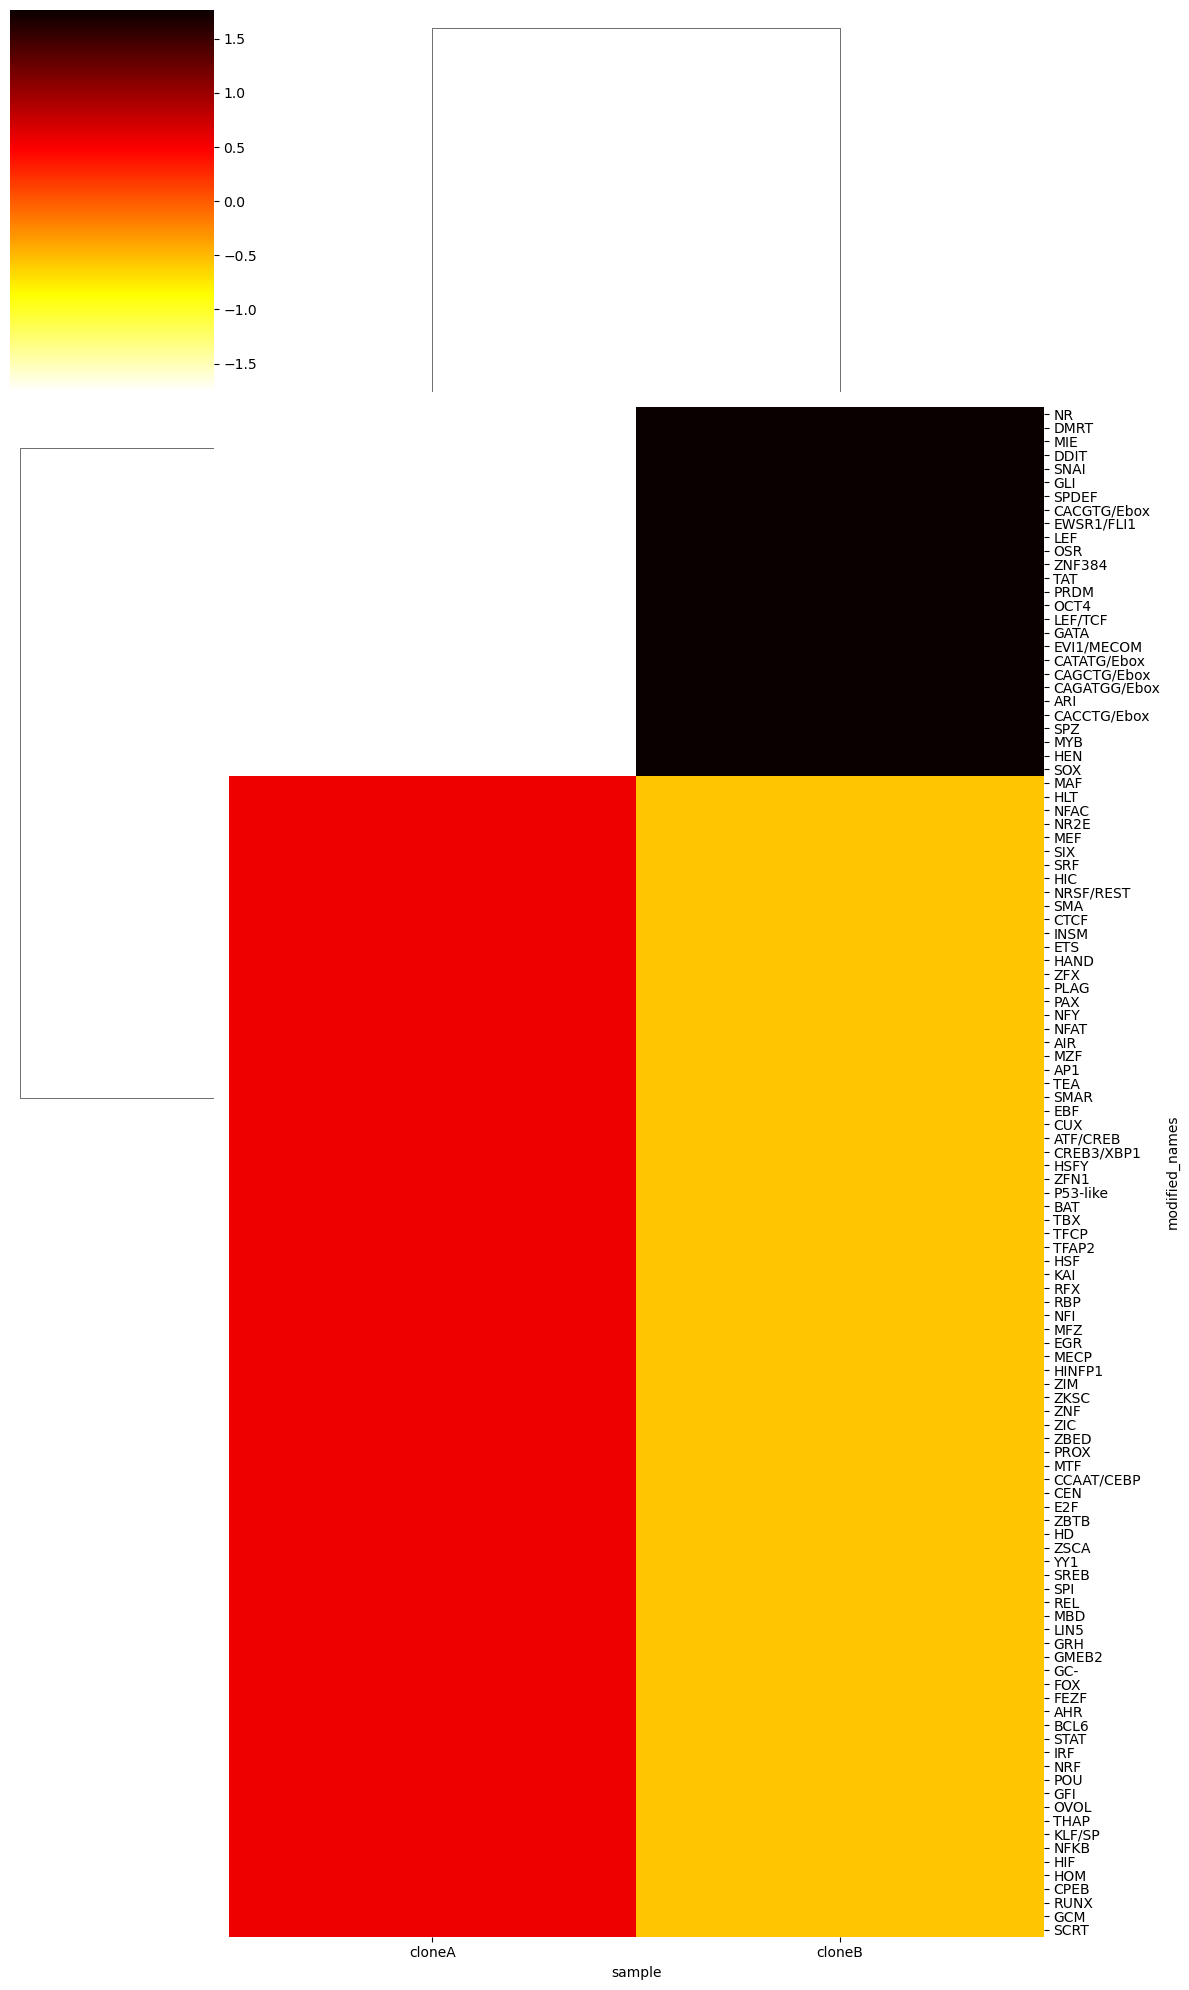

In [35]:
####################################################
# args
####################################################
suffix = 'clstrmp_mtfcmp_gbm45_diffpk_nochr6'
grid ={'zscore': ['rowcol'],
       'topn': [None],
       'drop': [None]}
####################################################

dt = datetime.datetime.now().strftime('%y%m%d')
pfp = os.path.join('/home/nravindra/project/reg_diffs/results/tmp/', dt)
if not os.path.exists(pfp):
    os.makedirs(pfp)

count = 0
for zscore_type in grid['zscore']:
    for n in grid['topn']:
        for drop_motif in grid['drop']:
            print(count, '{}_{}_{}'.format(zscore_type, n, drop_motif))
            agg, p, dt = mtfcmp.viz_compare_enrich(
                enrich_out, 
                name_key=name_key, 
                drop_duplicates_key='modified_names', 
                names2display=None,
                topn=n,
                drop=drop_motif,
                zscore=zscore_type,
                save_plot=None if not export else os.path.join(pfp, '{}_z{}_top{}_drop{}.pdf'.format(suffix, zscore_type, n, drop_motif)),
                save_mat=None if not export else '/illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/{}_z{}_top{}_drop{}.csv'.format(suffix, zscore_type, n, drop_motif),
                return_plot_obj=True,
            )
            if export:
                dt['df_prez'].to_csv('/illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/{}_z{}_top{}_drop{}_preZ.csv'.format(suffix, zscore_type, n, drop_motif))
                print('  wrote {}'.format('/illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/{}_z{}_top{}_drop{}_preZ.csv'.format(suffix, zscore_type, n, drop_motif)))
            count+=1


In [36]:
agg

modified_names         p_chi2        OR  sample   p_bonferonni
0               HD   0.000000e+00  1.865534  cloneA   0.000000e+00
1           KLF/SP   0.000000e+00  1.195778  cloneA   0.000000e+00
2              GC-   0.000000e+00  1.188411  cloneA   0.000000e+00
3      CAGCTG/Ebox   0.000000e+00  0.687055  cloneA   0.000000e+00
4             ZBTB  2.538365e-298  1.954011  cloneA  5.685937e-296
..             ...            ...       ...     ...            ...
219           NR2E   7.552392e-01  0.981101  cloneB   1.691736e+02
220            GCM   8.130956e-01  0.995005  cloneB   1.821334e+02
221           SCRT   8.168501e-01  0.990561  cloneB   1.829744e+02
222            MAF   8.510980e-01  0.997130  cloneB   1.906459e+02
223            HLT   9.035765e-01  0.990939  cloneB   2.024011e+02

[224 rows x 5 columns]

In [240]:
print(dt.index[p.dendrogram_row.reordered_ind])
print(dt.columns[p.dendrogram_col.reordered_ind])

AttributeError: 'dict' object has no attribute 'index'